In [24]:
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, precision_score, recall_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
import argparse
import os
from collections import defaultdict
from scipy import stats
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [25]:
# Configuration
class Args:
    path = './'
    baseline_file = None
    n_bootstrap = 1000
    confidence_level = 0.95

args = Args()

In [26]:
def load_ground_truth(json_file):
    """Loads ground truth labels from a JSON file."""
    with open(json_file, 'r') as f:
        gt_data = json.load(f)
    ap_to_floor = {int(k): v for k, v in gt_data.items()}
    return ap_to_floor


def load_clustering_result(csv_file):
    """Loads clustering results from a CSV file."""
    clusters = []
    with open(csv_file, 'r') as f:
        csv_reader = csv.reader(f)
        for row in csv_reader:
            cluster = [int(item.strip()) for item in row if item.strip() and item.strip().isdigit()]
            if cluster:
                clusters.append(cluster)
    ap_to_cluster = {}
    for cluster_id, aps in enumerate(clusters):
        for ap in aps:
            ap_to_cluster[ap] = cluster_id
    return ap_to_cluster, clusters

In [27]:
def map_clusters_to_floors(ap_to_floor, ap_to_cluster, clusters, min_cluster_size=3):
    """
    Kümeleri katlara eşler, ancak KÜÇÜK KÜMELERİ (-1) OLARAK ETİKETLER.
    """
    cluster_floor_counts = defaultdict(lambda: defaultdict(int))
    
    common_aps = set(ap_to_floor.keys()) & set(ap_to_cluster.keys())
    for ap in common_aps:
        floor = ap_to_floor[ap]
        cluster = ap_to_cluster[ap]
        cluster_floor_counts[cluster][floor] += 1
    
    cluster_to_floor = {}
    
    # clusters listesi burada kullanılıyor
    # clusters[cluster_id] bize o kümenin eleman listesini verir
    for cluster_id, floor_counts in cluster_floor_counts.items():
        
        # Hata koruması: Eğer cluster_id liste sınırları dışındaysa (nadir durum)
        if cluster_id >= len(clusters):
            current_cluster_size = 0
        else:
            current_cluster_size = len(clusters[cluster_id])
        
        # --- KRİTİK KONTROL ---
        if current_cluster_size < min_cluster_size:
            cluster_to_floor[cluster_id] = -1  # GÜRÜLTÜ / NOISE olarak işaretle
        else:
            cluster_to_floor[cluster_id] = max(floor_counts.items(), key=lambda x: x[1])[0]
            
    return cluster_to_floor


def create_true_pred_arrays(ap_to_floor, ap_to_cluster, cluster_to_floor):
    """Creates arrays of true and predicted labels for evaluation."""
    common_aps = sorted(set(ap_to_floor.keys()) & set(ap_to_cluster.keys()))
    y_true = np.array([ap_to_floor[ap] for ap in common_aps])
    y_pred_raw = np.array([ap_to_cluster[ap] for ap in common_aps])
    y_pred_mapped = np.array([cluster_to_floor[ap_to_cluster[ap]] for ap in common_aps])
    return common_aps, y_true, y_pred_raw, y_pred_mapped

In [28]:
def calculate_cluster_quality_metrics(clusters, ap_to_floor):
    """
    YENI FONKSİYON: Kümeleme kalitesini değerlendirir.
    
    Returns:
        dict: Kümeleme kalite metrikleri
    """
    total_aps = sum(len(cluster) for cluster in clusters)
    num_clusters = len(clusters)
    num_unique_floors = len(set(ap_to_floor.values()))
    
    # Cluster boyutları
    cluster_sizes = [len(cluster) for cluster in clusters]
    avg_cluster_size = np.mean(cluster_sizes)
    std_cluster_size = np.std(cluster_sizes)
    
    # Singleton cluster sayısı (tek elemanlı küme)
    singleton_clusters = sum(1 for size in cluster_sizes if size == 1)
    singleton_ratio = singleton_clusters / num_clusters if num_clusters > 0 else 0
    
    # Küme içi homojenlik (her kümedeki dominant floor oranı)
    cluster_purities = []
    for cluster in clusters:
        if not cluster:
            continue
        floor_counts = defaultdict(int)
        valid_count = 0
        for ap in cluster:
            if ap in ap_to_floor:
                floor_counts[ap_to_floor[ap]] += 1
                valid_count += 1
        if valid_count > 0:
            max_count = max(floor_counts.values())
            purity = max_count / valid_count
            cluster_purities.append(purity)
    
    avg_purity = np.mean(cluster_purities) if cluster_purities else 0
    
    # Küme/Kat oranı - idealden ne kadar sapma var?
    cluster_floor_ratio = num_clusters / num_unique_floors if num_unique_floors > 0 else float('inf')
    
    return {
        'num_clusters': num_clusters,
        'num_unique_floors': num_unique_floors,
        'total_aps': total_aps,
        'avg_cluster_size': avg_cluster_size,
        'std_cluster_size': std_cluster_size,
        'singleton_clusters': singleton_clusters,
        'singleton_ratio': singleton_ratio,
        'avg_cluster_purity': avg_purity,
        'cluster_floor_ratio': cluster_floor_ratio,
        'min_cluster_size': min(cluster_sizes) if cluster_sizes else 0,
        'max_cluster_size': max(cluster_sizes) if cluster_sizes else 0
    }


def calculate_adjusted_score(mapped_f1, singleton_ratio, cluster_floor_ratio):
    """
    YENI FONKSİYON: Over-clustering cezası eklenmiş adjusted score
    
    Args:
        mapped_f1: Orijinal F1 skoru
        singleton_ratio: Tek elemanlı küme oranı
        cluster_floor_ratio: Küme sayısı / Kat sayısı oranı
    
    Returns:
        float: Cezalandırılmış F1 skoru
    """
    # Singleton cezası: %50'den fazlası singleton ise ağır ceza
    if singleton_ratio > 0.5:
        singleton_penalty = 0.5 * (1 - singleton_ratio)
    else:
        singleton_penalty = 1.0
    
    # Over-clustering cezası: İdeal oran 1.0-2.0 arası
    if cluster_floor_ratio > 5.0:
        overclustering_penalty = max(0.1, 1.0 / (cluster_floor_ratio / 5.0))
    elif cluster_floor_ratio > 2.0:
        overclustering_penalty = max(0.5, 1.0 / (cluster_floor_ratio / 2.0))
    else:
        overclustering_penalty = 1.0
    
    # Final skor
    adjusted_score = mapped_f1 * singleton_penalty * overclustering_penalty
    
    return adjusted_score

In [29]:
def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000, confidence_level=0.95):
    """Calculate bootstrap confidence intervals for a metric."""
    n_samples = len(y_true)
    bootstrap_scores = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sampling with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        
        try:
            score = metric_func(y_true_boot, y_pred_boot)
            bootstrap_scores.append(score)
        except:
            continue
    
    bootstrap_scores = np.array(bootstrap_scores)
    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (100 - alpha/2)
    
    ci_lower = np.percentile(bootstrap_scores, lower_percentile)
    ci_upper = np.percentile(bootstrap_scores, upper_percentile)
    mean_score = np.mean(bootstrap_scores)
    std_score = np.std(bootstrap_scores)
    
    return mean_score, std_score, ci_lower, ci_upper

def calculate_metrics_with_ci(y_true, y_pred, n_bootstrap=1000, confidence_level=0.95):
    """Calculate performance metrics with confidence intervals."""
    metrics = {}
    
    # Define metric functions
    metric_functions = {
        'mapped_accuracy': lambda yt, yp: accuracy_score(yt, yp),
        'mapped_precision': lambda yt, yp: precision_score(yt, yp, average='weighted', zero_division=0),
        'mapped_recall': lambda yt, yp: recall_score(yt, yp, average='weighted', zero_division=0),
        'mapped_f1': lambda yt, yp: f1_score(yt, yp, average='weighted', zero_division=0),
    }
    
    for metric_name, metric_func in metric_functions.items():
        mean_score, std_score, ci_lower, ci_upper = bootstrap_metric(
            y_true, y_pred, metric_func, n_bootstrap, confidence_level
        )
        metrics[metric_name] = {
            'mean': mean_score,
            'std': std_score,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    
    return metrics

In [30]:
def evaluate_clustering(y_true, y_pred, prefix=""):
    """Evaluates clustering performance and returns metrics."""
    results = {}
    results[f"{prefix}ari"] = adjusted_rand_score(y_true, y_pred)
    results[f"{prefix}nmi"] = normalized_mutual_info_score(y_true, y_pred)
    results[f"{prefix}homogeneity"] = homogeneity_score(y_true, y_pred)
    results[f"{prefix}completeness"] = completeness_score(y_true, y_pred)
    results[f"{prefix}v_measure"] = v_measure_score(y_true, y_pred)
    if prefix == "mapped_":
        results[f"{prefix}accuracy"] = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        results[f"{prefix}precision"] = precision
        results[f"{prefix}recall"] = recall
        results[f"{prefix}f1"] = f1
    return results

In [31]:
def mcnemar_test(y_true, y_pred1, y_pred2):
    """Manual implementation of McNemar's test."""
    # Create contingency table for McNemar's test
    correct1 = (y_true == y_pred1).astype(int)
    correct2 = (y_true == y_pred2).astype(int)
    
    # Count discordant pairs
    only_1_correct = np.sum((correct1 == 1) & (correct2 == 0))
    only_2_correct = np.sum((correct1 == 0) & (correct2 == 1))
    
    # McNemar's test statistic with continuity correction
    if only_1_correct + only_2_correct == 0:
        chi2_stat = 0
        p_value = 1.0
    else:
        chi2_stat = (abs(only_1_correct - only_2_correct) - 1)**2 / (only_1_correct + only_2_correct)
        p_value = 1 - stats.chi2.cdf(chi2_stat, 1)
    
    return chi2_stat, p_value, only_1_correct, only_2_correct

def statistical_significance_test(y_true, y_pred1, y_pred2, test_type='mcnemar'):
    """Perform statistical significance test between two predictions."""
    results = {}
    
    if test_type == 'mcnemar':
        # McNemar's test for paired predictions
        chi2_stat, p_value, only_1_correct, only_2_correct = mcnemar_test(y_true, y_pred1, y_pred2)
        
        results['test_type'] = 'McNemar'
        results['chi2_statistic'] = chi2_stat
        results['p_value'] = p_value
        results['discordant_pairs'] = {
            'only_method1_correct': only_1_correct,
            'only_method2_correct': only_2_correct
        }
        
    elif test_type == 'paired_t':
        # Paired t-test on accuracy differences
        acc1 = (y_true == y_pred1).astype(float)
        acc2 = (y_true == y_pred2).astype(float)
        
        t_stat, p_value = stats.ttest_rel(acc1, acc2)
        
        results['test_type'] = 'Paired t-test'
        results['t_statistic'] = t_stat
        results['p_value'] = p_value
        results['mean_difference'] = np.mean(acc1 - acc2)
        
    elif test_type == 'wilcoxon':
        # Wilcoxon signed-rank test (non-parametric alternative)
        acc1 = (y_true == y_pred1).astype(float)
        acc2 = (y_true == y_pred2).astype(float)
        
        try:
            stat, p_value = stats.wilcoxon(acc1, acc2, alternative='two-sided')
            results['test_type'] = 'Wilcoxon Signed-Rank'
            results['statistic'] = stat
            results['p_value'] = p_value
        except ValueError:
            # All differences are zero
            results['test_type'] = 'Wilcoxon Signed-Rank'
            results['statistic'] = 0
            results['p_value'] = 1.0
            
    return results

In [32]:
def generate_confusion_matrix_with_ci(y_true, y_pred, output_file, title, n_bootstrap=1000):
    """Generates confusion matrix with confidence intervals for each cell."""
    
    # Tüm olası label'ları hem y_true hem de y_pred'den al
    all_labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # Ana confusion matrix - tüm label'ları kullan
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    n_samples = len(y_true)
    
    # Bootstrap confidence intervals for confusion matrix cells
    cm_bootstrap = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        # Aynı label'ları kullan
        cm_boot = confusion_matrix(y_true_boot, y_pred_boot, labels=all_labels)
        cm_bootstrap.append(cm_boot)
    
    cm_bootstrap = np.array(cm_bootstrap)
    cm_std = np.std(cm_bootstrap, axis=0)
    
    # Boyut kontrolü (debugging için)
    assert cm.shape == cm_std.shape, f"Boyut uyuşmazlığı: cm {cm.shape} vs cm_std {cm_std.shape}"
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
    })
    
    # Original confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                annot_kws={'size': 13}, cbar_kws={'shrink': 0.8})
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title(f'{title}\n(Counts)')
    
    # Confusion matrix with standard errors
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            row.append(f'{cm[i,j]}\n±{cm_std[i,j]:.1f}')
        annotations.append(row)
    
    sns.heatmap(cm_std, annot=annotations, fmt='', cmap='Reds', ax=ax2,
                annot_kws={'size': 13}, cbar_kws={'shrink': .8})
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title(f'{title}\n(Counts ± Bootstrap SE)')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    plt.rcParams.update(plt.rcParamsDefault)

def analyze_clusters(clusters, ap_to_floor, output_dir):
    """Analyzes each cluster and visualizes floor distribution."""
    results = []
    for cluster_id, aps in enumerate(clusters):
        floor_counts = defaultdict(int)
        valid_aps = 0
        for ap in aps:
            if ap in ap_to_floor:
                floor_counts[ap_to_floor[ap]] += 1
                valid_aps += 1
        if not valid_aps:
            continue
        percentages = {floor: (count / valid_aps) * 100 for floor, count in floor_counts.items()}
        dominant_floor = max(percentages.items(), key=lambda x: x[1]) if percentages else (None, 0)
        results.append({
            'cluster_id': cluster_id,
            'total_aps': len(aps),
            'valid_aps': valid_aps,
            'floor_counts': dict(floor_counts),
            'floor_percentages': percentages,
            'dominant_floor': dominant_floor[0],
            'dominant_percentage': dominant_floor[1]
        })
    
    with open(os.path.join(output_dir, 'cluster_analysis.json'), 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    return results

In [33]:
def find_the_way(path, file_format, con=""):
    files_add = []
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))
    return files_add

def compile_metrics_to_table(root_dir):
    """
    Belirtilen dizin ve alt dizinlerindeki tüm performance_metrics.json
    dosyalarını okur ve bir Pandas DataFrame (tablo) haline getirir.
    """
    all_data = []

    # os.walk ile tüm alt klasörleri geziyoruz
    for root, dirs, files in os.walk(root_dir):
        if 'performance_metrics.json' in files:
            file_path = os.path.join(root, 'performance_metrics.json')
            
            # Klasör adını al (Örn: Node2Vec_communities)
            folder_name = os.path.basename(root)
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    metrics = json.load(f)
                    
                    # Düzleştirme (Flattening) logic for nested dicts like 'metrics_ci' or 'baseline_comparison'
                    flat_metrics = {}
                    flat_metrics['Algorithm'] = folder_name
                    
                    # Basic keys
                    for k, v in metrics.items():
                        if not isinstance(v, dict):
                            flat_metrics[k] = v
                    
                    # Nested keys (Metrics with CI)
                    if 'metrics_ci' in metrics:
                        for m_name, m_vals in metrics['metrics_ci'].items():
                            flat_metrics[f"{m_name}_mean"] = m_vals['mean']
                            flat_metrics[f"{m_name}_ci_lower"] = m_vals['ci_lower']
                            flat_metrics[f"{m_name}_ci_upper"] = m_vals['ci_upper']

                    # Nested keys (Statistical comparison)
                    if 'baseline_comparison' in metrics:
                        for test_name, test_vals in metrics['baseline_comparison'].items():
                            flat_metrics[f"p_value_{test_name}"] = test_vals['p_value']

                    all_data.append(flat_metrics)
            except Exception as e:
                print(f"Hata: {file_path} dosyası okunamadı. Sebebi: {e}")

    # Listeyi DataFrame'e (Tabloya) çevir
    if all_data:
        df = pd.DataFrame(all_data)
        
        # 'Algorithm' sütununu en başa al
        cols = ['Algorithm'] + [c for c in df.columns if c != 'Algorithm']
        df = df[cols]
        
        # Algoritma ismine göre sırala (isteğe bağlı)
        df = df.sort_values(by='Algorithm').reset_index(drop=True)
        
        return df
    else:
        print("Hiçbir performance_metrics.json dosyası bulunamadı.")
        return None

Found 9 result files.

Processing: ./ValidationGeo/community_results\edge_betweenness_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: edge_betweenness_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 36
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 2.77
Singleton (Tek Elemanlı) Küme Sayısı: 35
Singleton Oranı: 97.22%
Ortalama Küme Boyutu: 3.42
Ortalama Küme Saflığı: 97.86%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0340
Normalized Mutual Information: 0.3904

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1639 (95% CI: [0.0984, 0.2746])
F1-Score (Orijinal): 0.0662 (95% CI: [0.0284, 0.1535])
F1-Score (Adjusted): 0.0007 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (97.2%)!


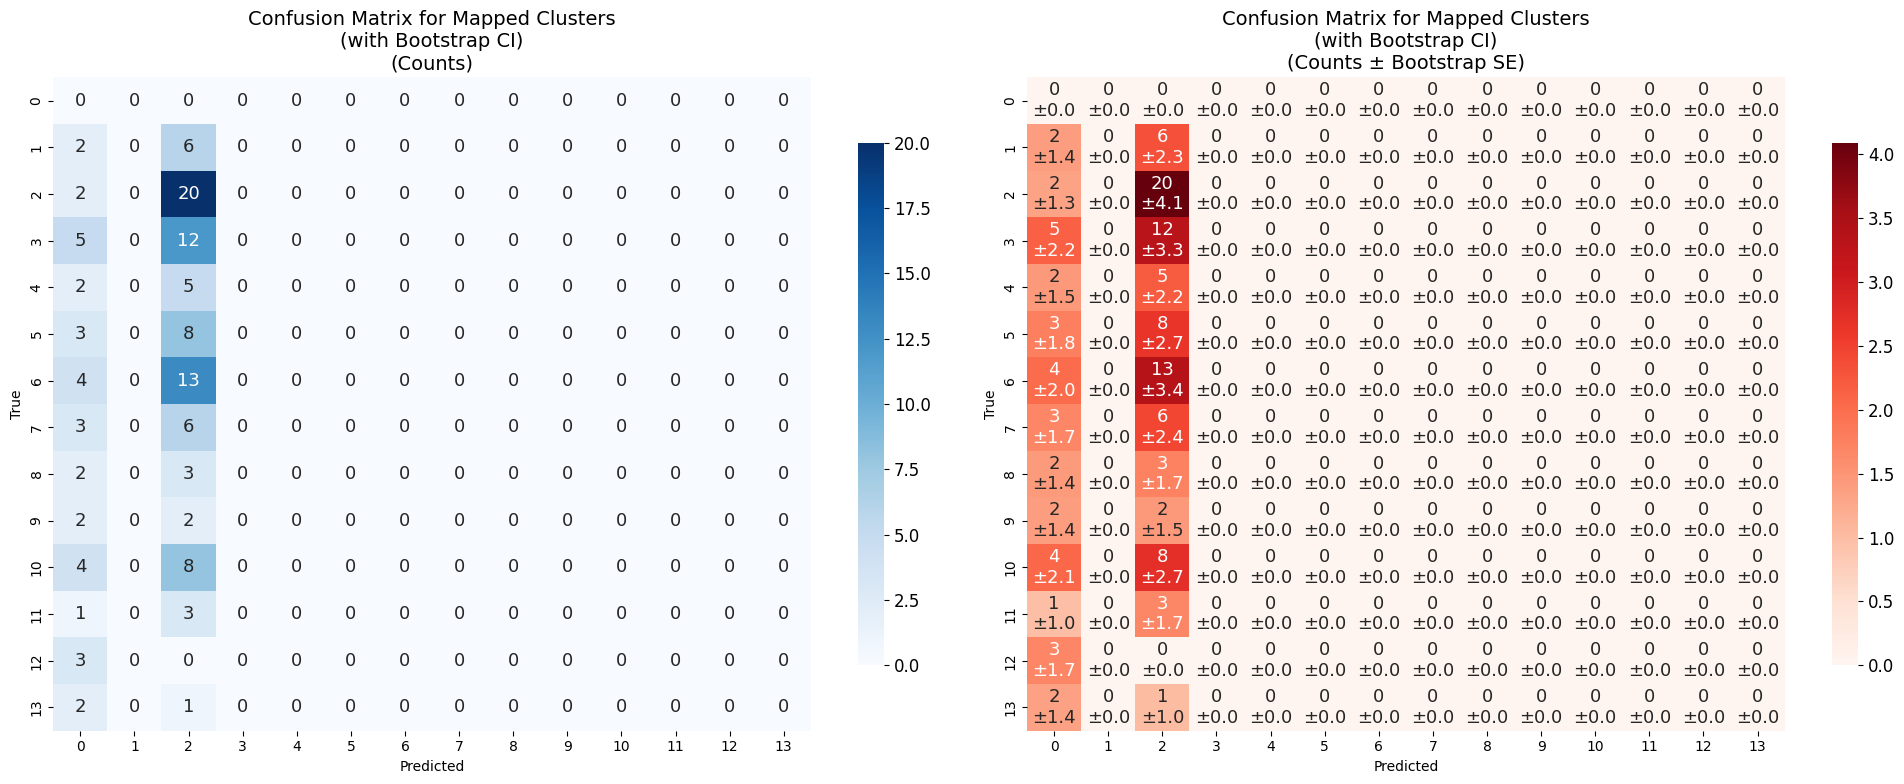


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\edge_betweenness_results

Processing: ./ValidationGeo/community_results\fast_greedy_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: fast_greedy_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 2
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.15
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 61.50
Ortalama Küme Saflığı: 20.54%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0032
Normalized Mutual Information: 0.0195

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2049 (95% CI: [0.1393, 0.3361])
F1-Score (Orijinal): 0.0997 (95% CI: [0.0547, 0.2066])
F1-Score (Adjusted): 0.0997 ⚠️


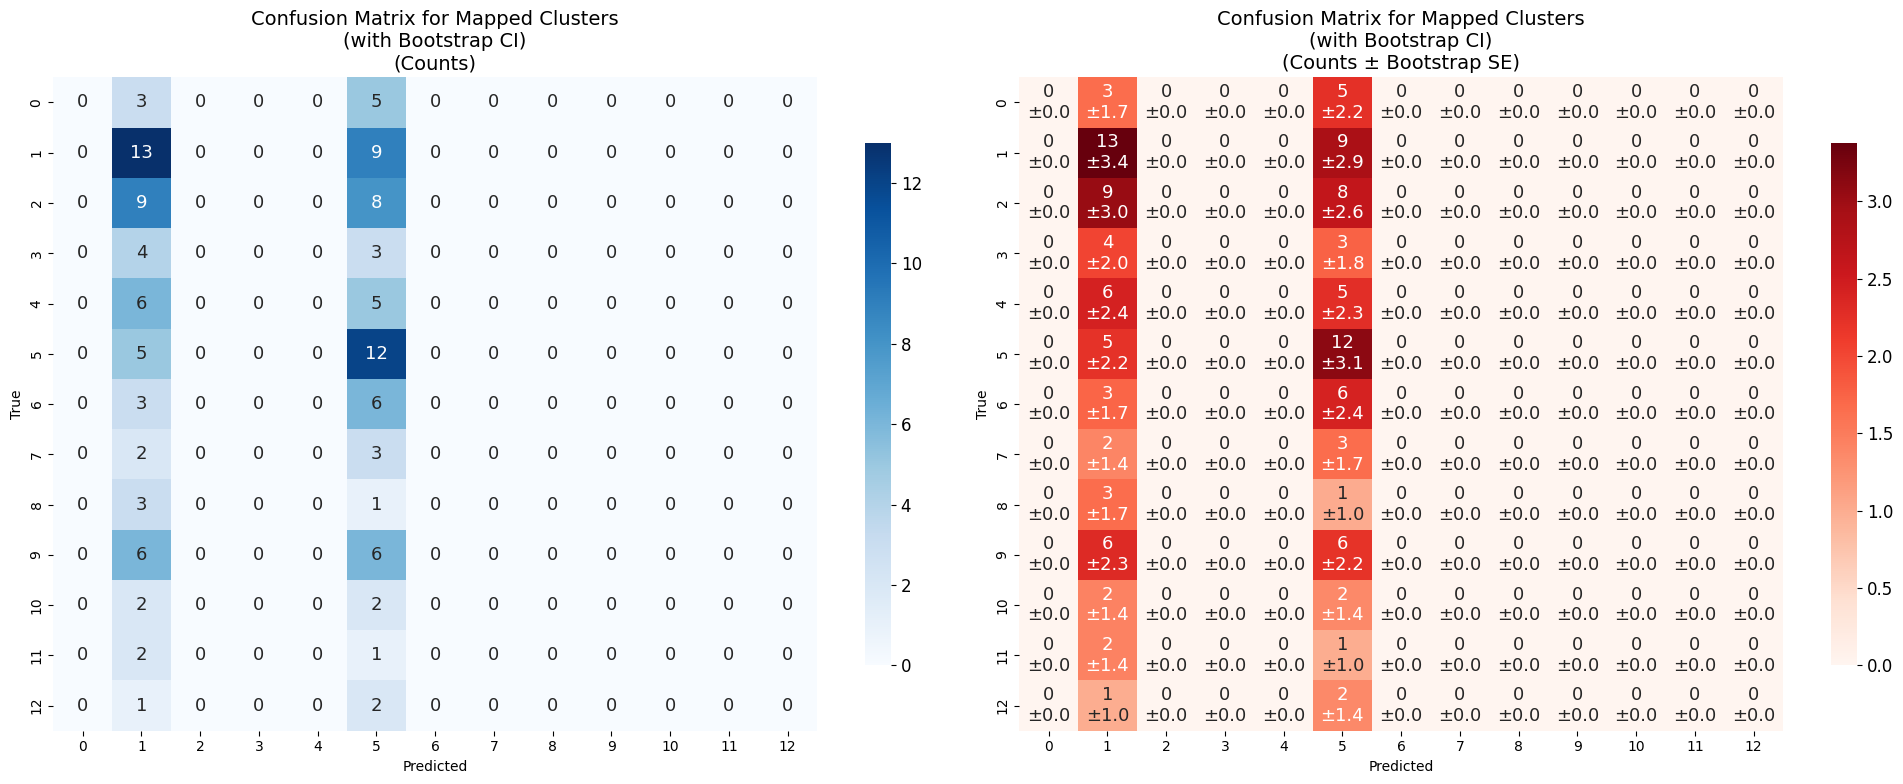


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\fast_greedy_results

Processing: ./ValidationGeo/community_results\gat_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gat_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 5
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.38
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 24.60
Ortalama Küme Saflığı: 32.26%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.1690
Normalized Mutual Information: 0.3880

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3333 (95% CI: [0.2520, 0.4553])
F1-Score (Orijinal): 0.1911 (95% CI: [0.1276, 0.3151])
F1-Score (Adjusted): 0.1911 ⚠️


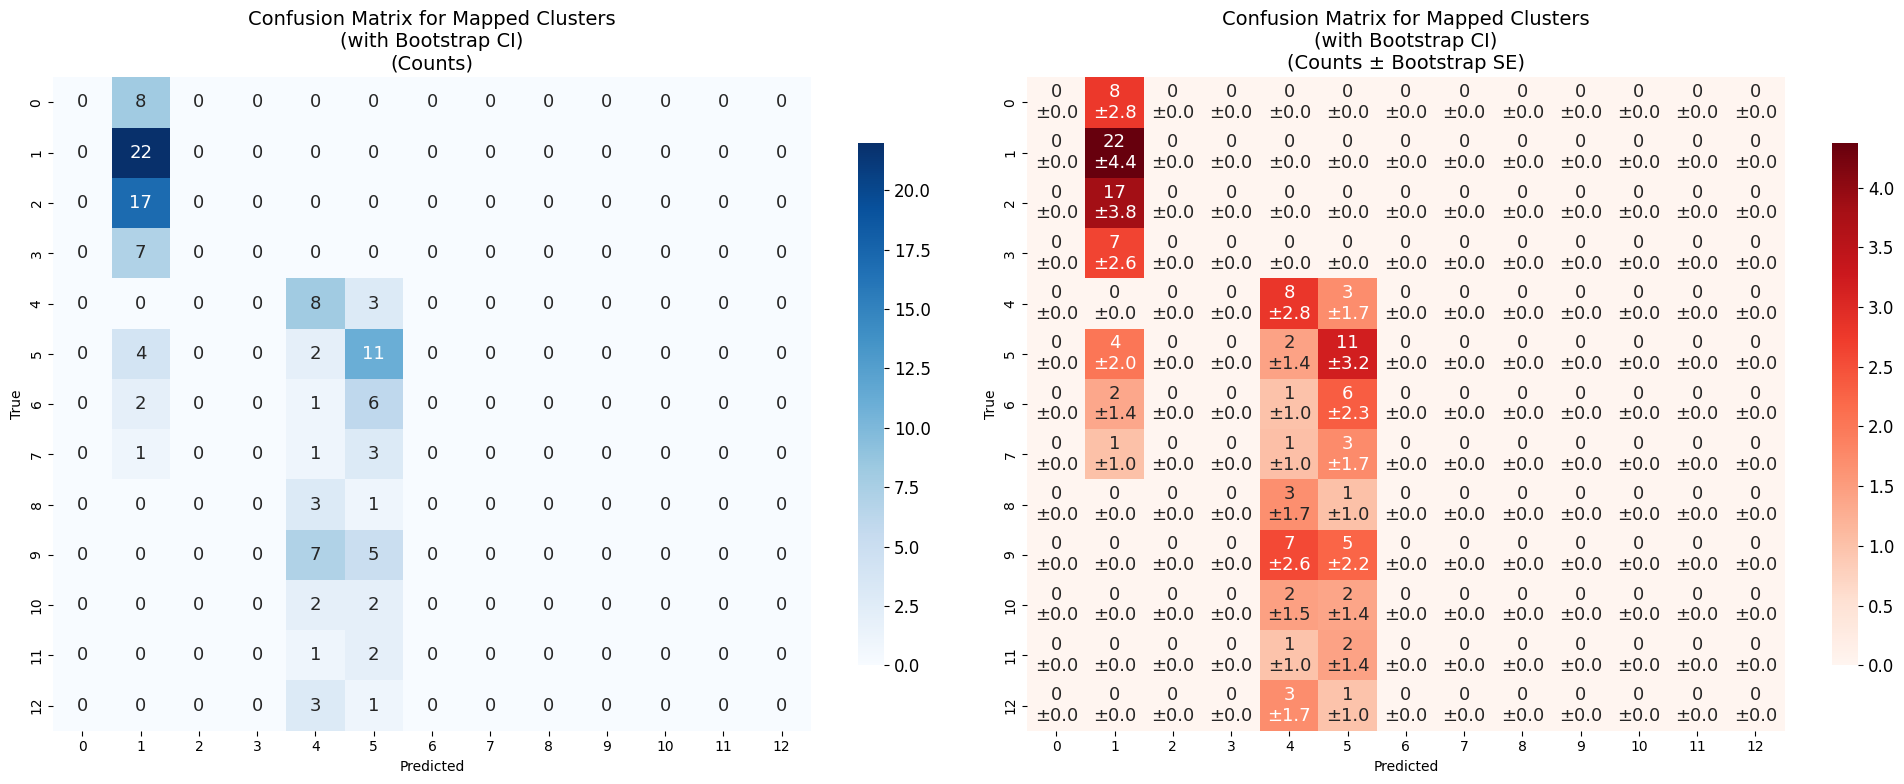


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\gat_gnn_results

Processing: ./ValidationGeo/community_results\gcn_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gcn_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 6.15
Ortalama Küme Saflığı: 54.11%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.1537
Normalized Mutual Information: 0.5071

--- Mapped Evaluation (with CI) ---
Accuracy: 0.4634 (95% CI: [0.3659, 0.6260])
F1-Score (Orijinal): 0.4250 (95% CI: [0.3321, 0.5978])
F1-Score (Adjusted): 0.4250 ⚠️


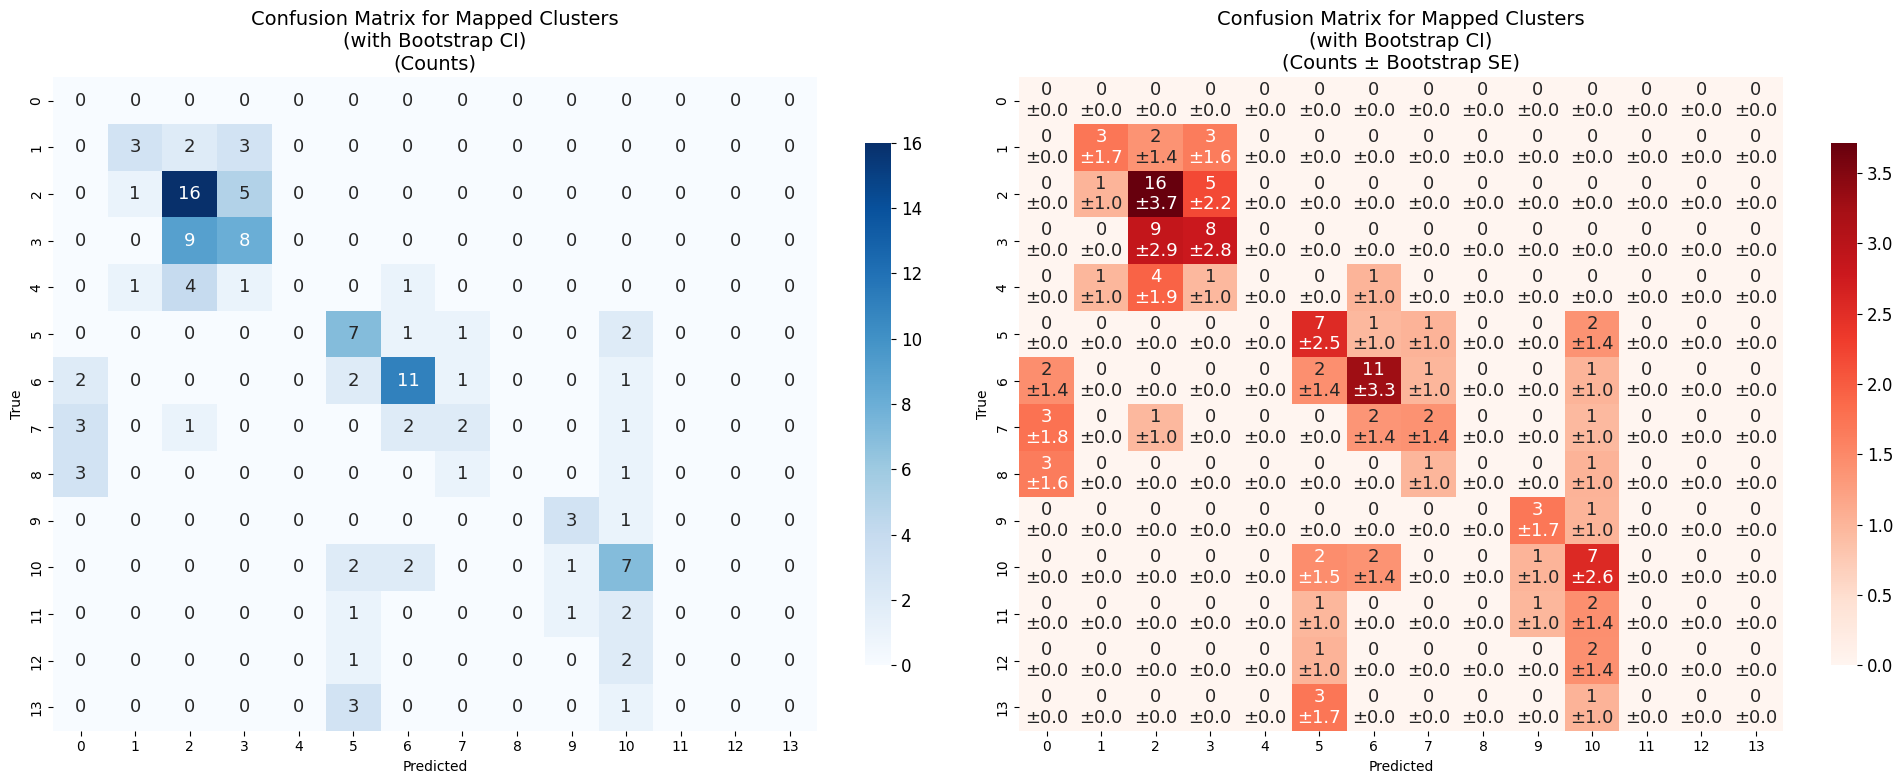


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\gcn_gnn_results

Processing: ./ValidationGeo/community_results\infomap_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: infomap_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 1
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.08
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 123.00
Ortalama Küme Saflığı: 18.03%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.0000

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1803 (95% CI: [0.1148, 0.2787])
F1-Score (Orijinal): 0.0551 (95% CI: [0.0205, 0.1675])
F1-Score (Adjusted): 0.0551 ⚠️


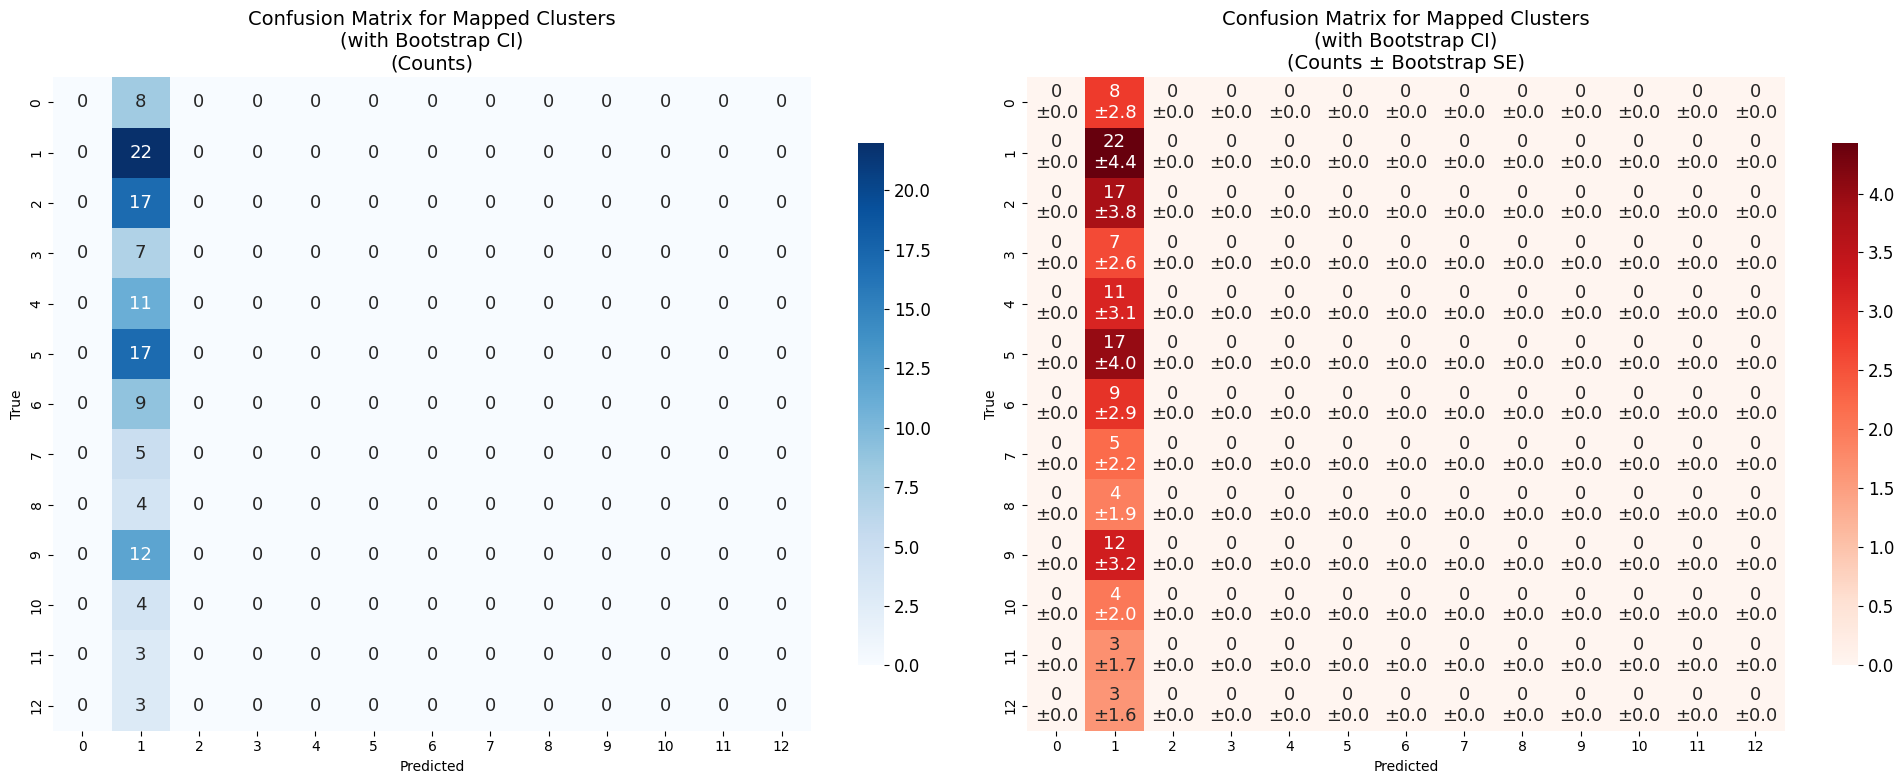


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\infomap_results

Processing: ./ValidationGeo/community_results\label_propagation_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: label_propagation_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 1
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.08
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 123.00
Ortalama Küme Saflığı: 18.03%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.0000

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1803 (95% CI: [0.1148, 0.2930])
F1-Score (Orijinal): 0.0551 (95% CI: [0.0236, 0.1279])
F1-Score (Adjusted): 0.0551 ⚠️


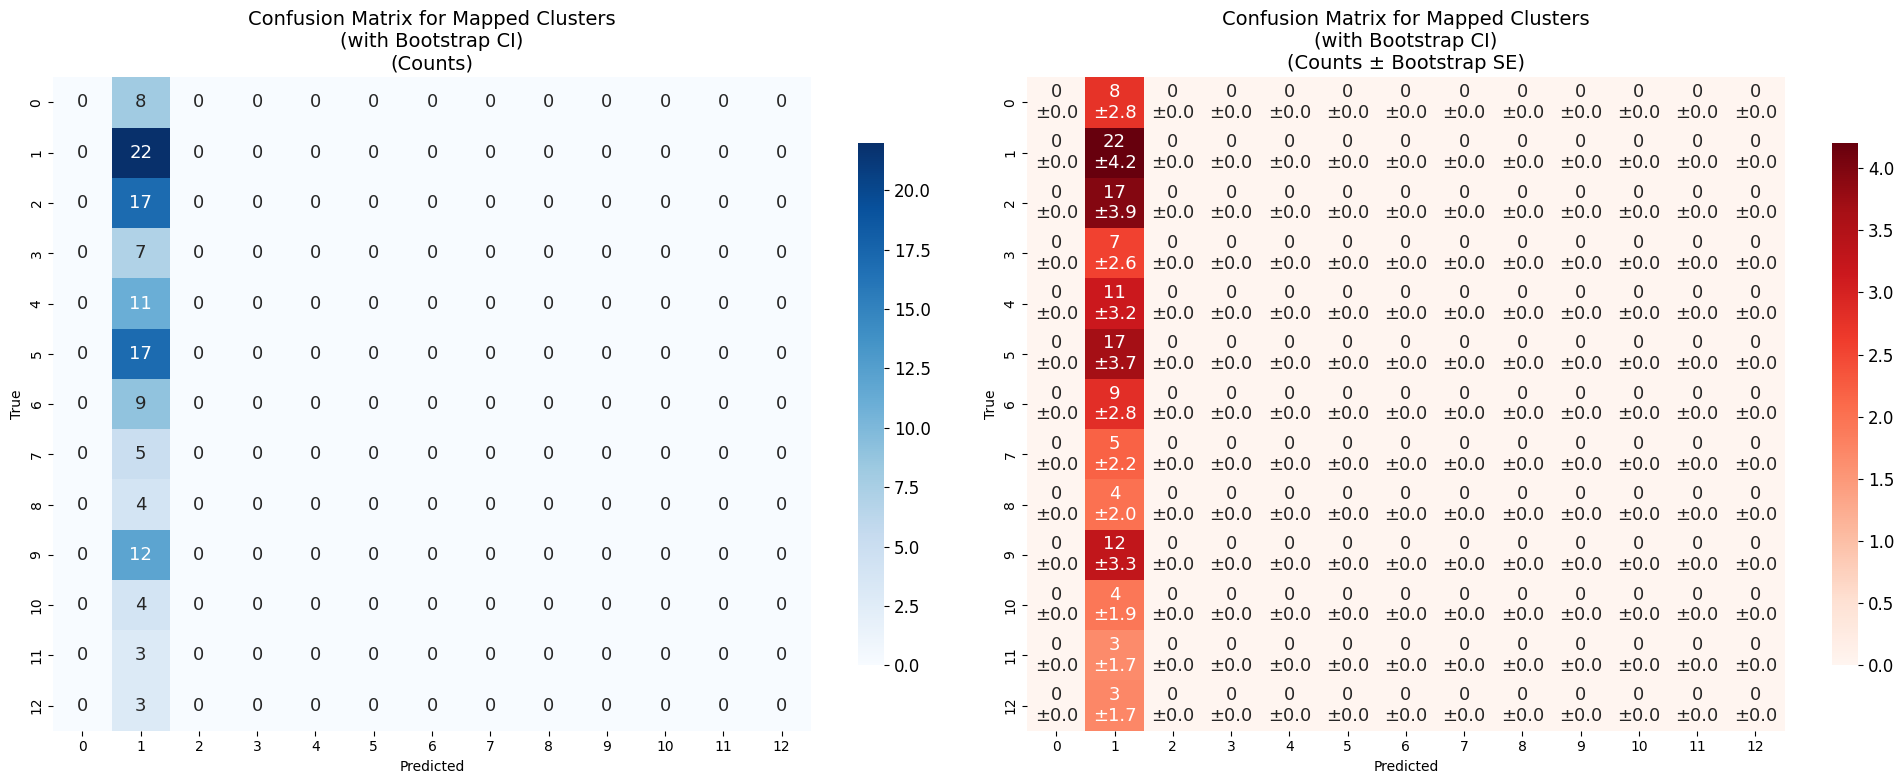


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\label_propagation_results

Processing: ./ValidationGeo/community_results\leiden_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: leiden_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 3
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.23
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 41.00
Ortalama Küme Saflığı: 29.98%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0047
Normalized Mutual Information: 0.0429

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1967 (95% CI: [0.1311, 0.3156])
F1-Score (Orijinal): 0.0966 (95% CI: [0.0535, 0.1862])
F1-Score (Adjusted): 0.0966 ⚠️


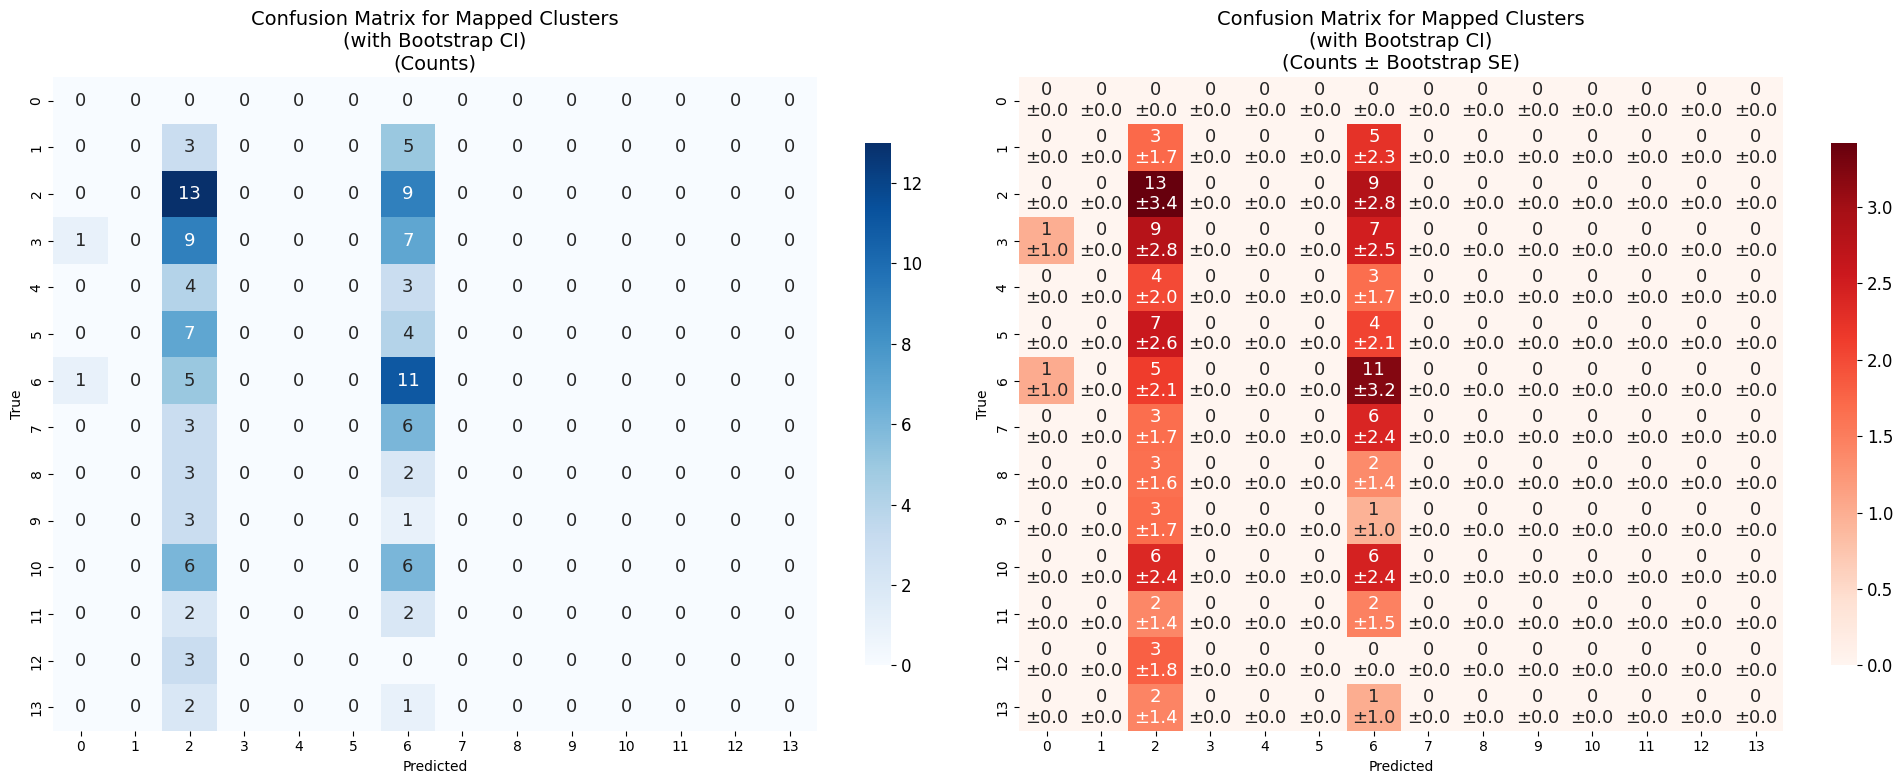


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\leiden_results

Processing: ./ValidationGeo/community_results\louvain_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: louvain_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 2
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.15
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 61.50
Ortalama Küme Saflığı: 19.74%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0029
Normalized Mutual Information: 0.0310

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1967 (95% CI: [0.1230, 0.3074])
F1-Score (Orijinal): 0.0953 (95% CI: [0.0495, 0.1875])
F1-Score (Adjusted): 0.0953 ⚠️


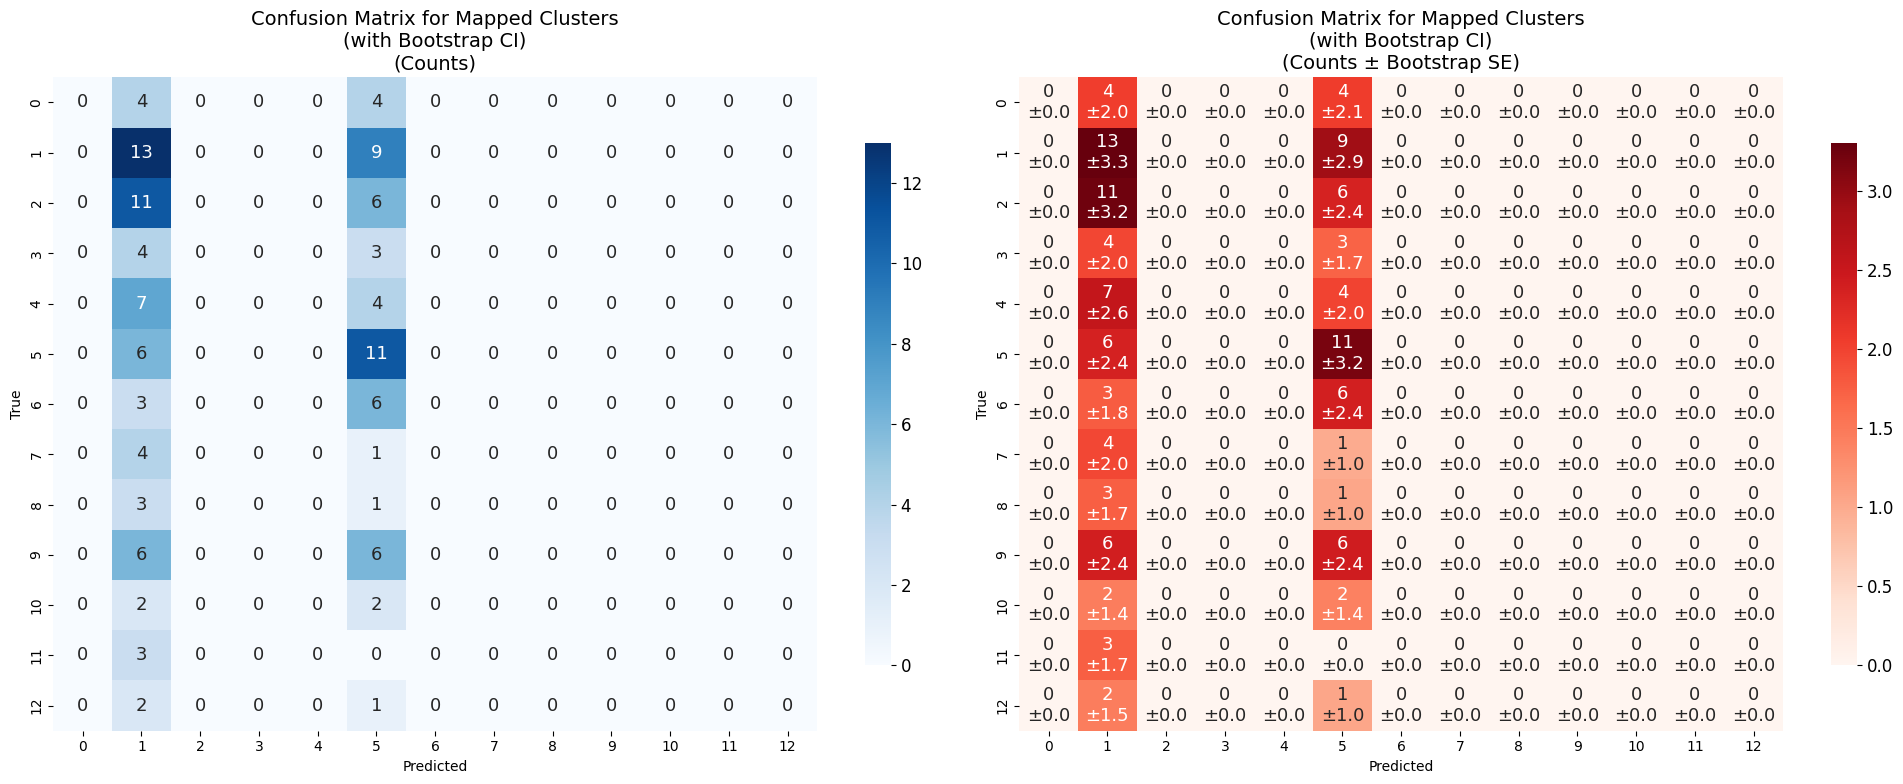


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\louvain_results

Processing: ./ValidationGeo/community_results\Node2Vec_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: Node2Vec_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 1
Singleton Oranı: 5.00%
Ortalama Küme Boyutu: 6.15
Ortalama Küme Saflığı: 75.69%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.2348
Normalized Mutual Information: 0.6005

--- Mapped Evaluation (with CI) ---
Accuracy: 0.5935 (95% CI: [0.5122, 0.7358])
F1-Score (Orijinal): 0.5738 (95% CI: [0.4800, 0.7374])
F1-Score (Adjusted): 0.5738 ⚠️


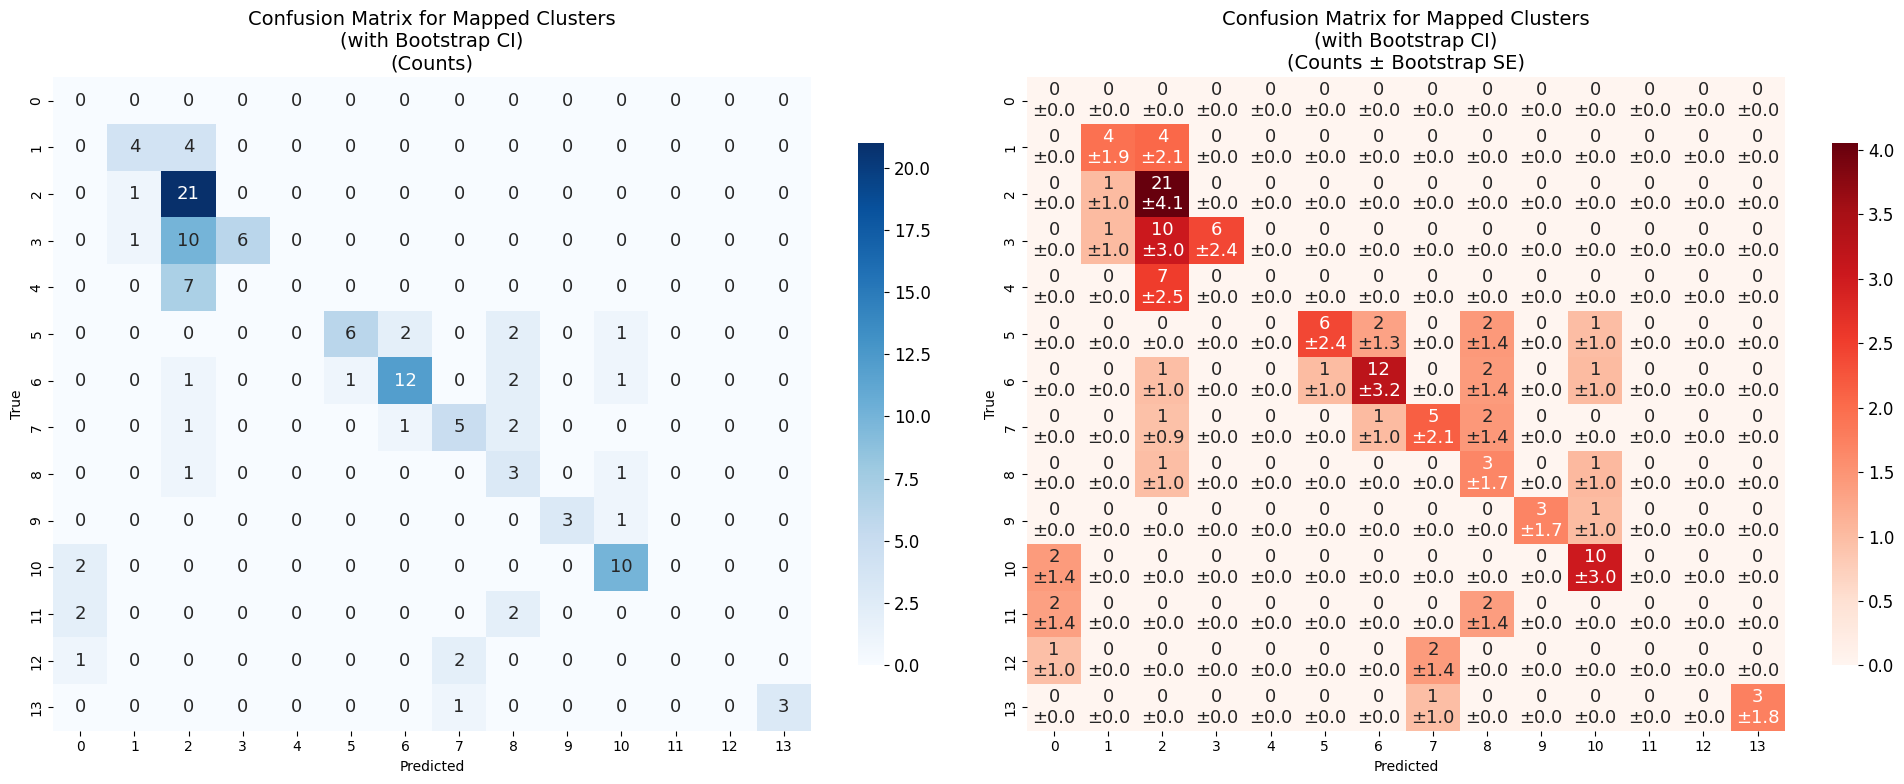


Tüm sonuçlar kaydedildi: ./ValidationGeo\results\Node2Vec_results
Found 9 result files.

Processing: ./ValidationWDE/community_results\edge_betweenness_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: edge_betweenness_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 36
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 2.77
Singleton (Tek Elemanlı) Küme Sayısı: 35
Singleton Oranı: 97.22%
Ortalama Küme Boyutu: 3.42
Ortalama Küme Saflığı: 97.86%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0340
Normalized Mutual Information: 0.3904

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1639 (95% CI: [0.0984, 0.2828])
F1-Score (Orijinal): 0.0662 (95% CI: [0.0298, 0.1420])
F1-Score (Adjusted): 0.0007 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (97.2%)!


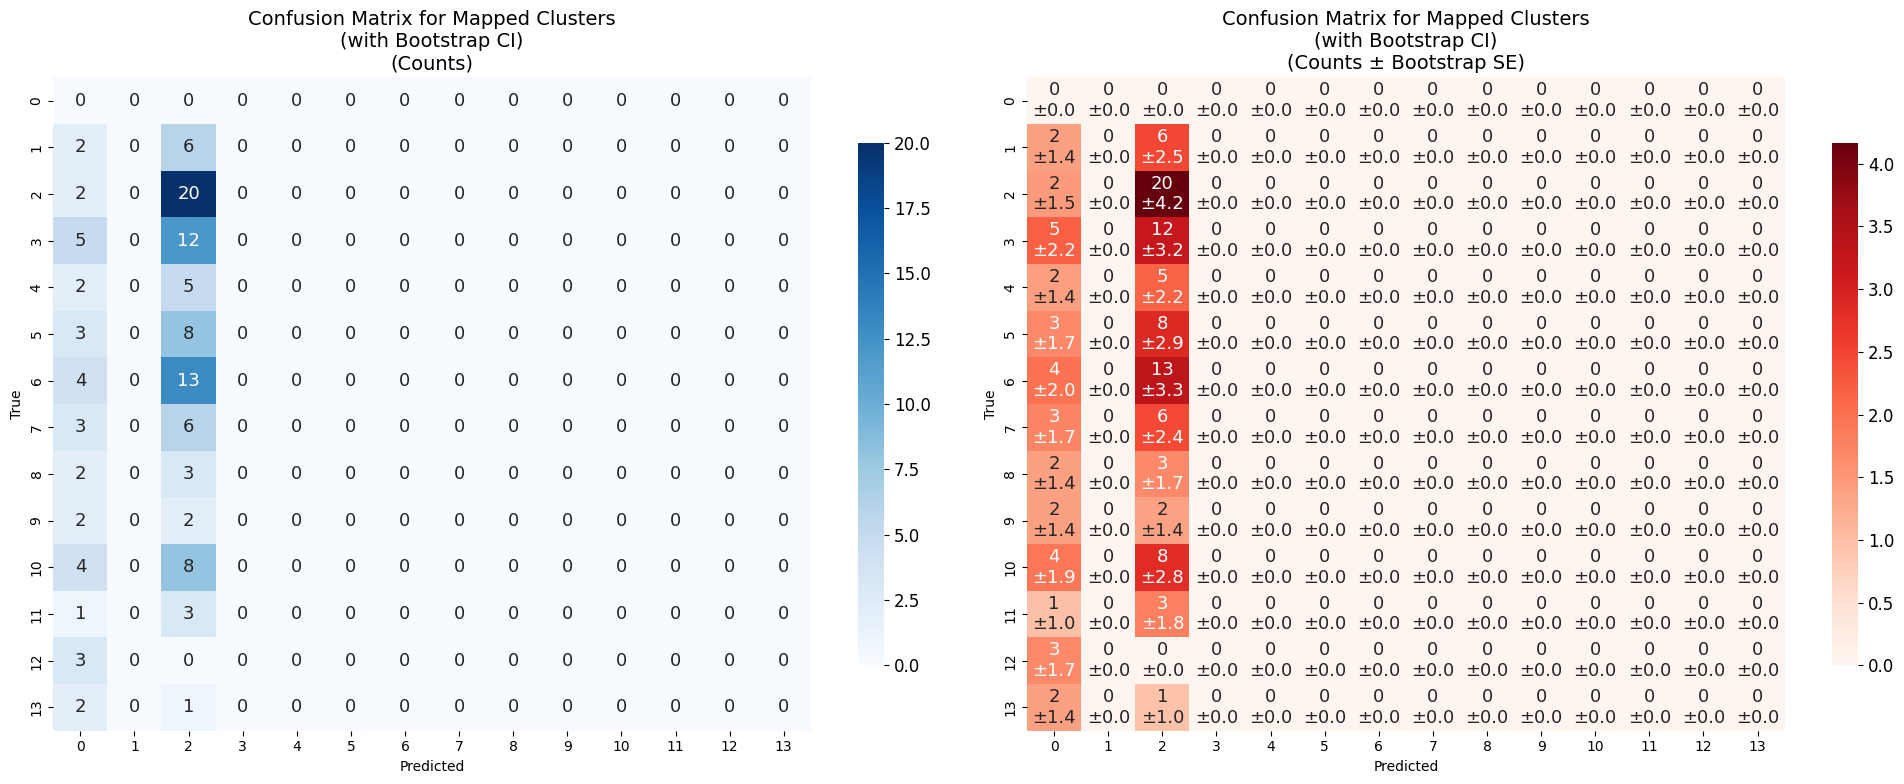


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\edge_betweenness_results

Processing: ./ValidationWDE/community_results\fast_greedy_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: fast_greedy_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 2
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.15
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 61.50
Ortalama Küme Saflığı: 20.54%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0032
Normalized Mutual Information: 0.0195

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2049 (95% CI: [0.1393, 0.3197])
F1-Score (Orijinal): 0.0997 (95% CI: [0.0534, 0.1848])
F1-Score (Adjusted): 0.0997 ⚠️


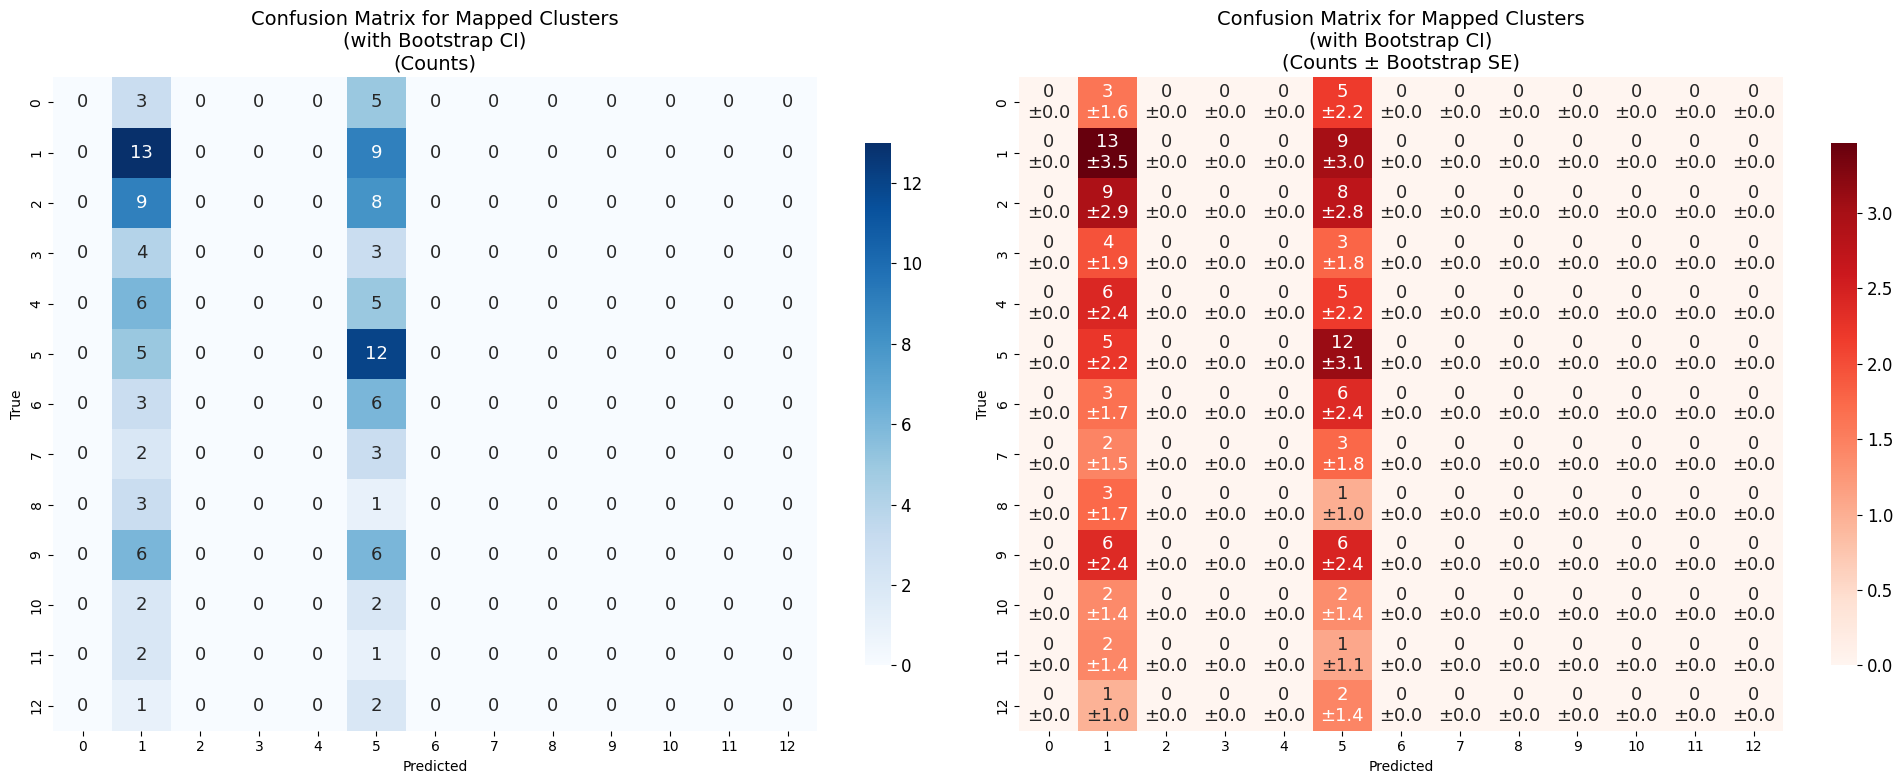


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\fast_greedy_results

Processing: ./ValidationWDE/community_results\gat_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gat_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 18
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.38
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 6.83
Ortalama Küme Saflığı: 54.36%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.1901
Normalized Mutual Information: 0.5086

--- Mapped Evaluation (with CI) ---
Accuracy: 0.5122 (95% CI: [0.4307, 0.6606])
F1-Score (Orijinal): 0.4796 (95% CI: [0.3832, 0.6200])
F1-Score (Adjusted): 0.4796 ⚠️


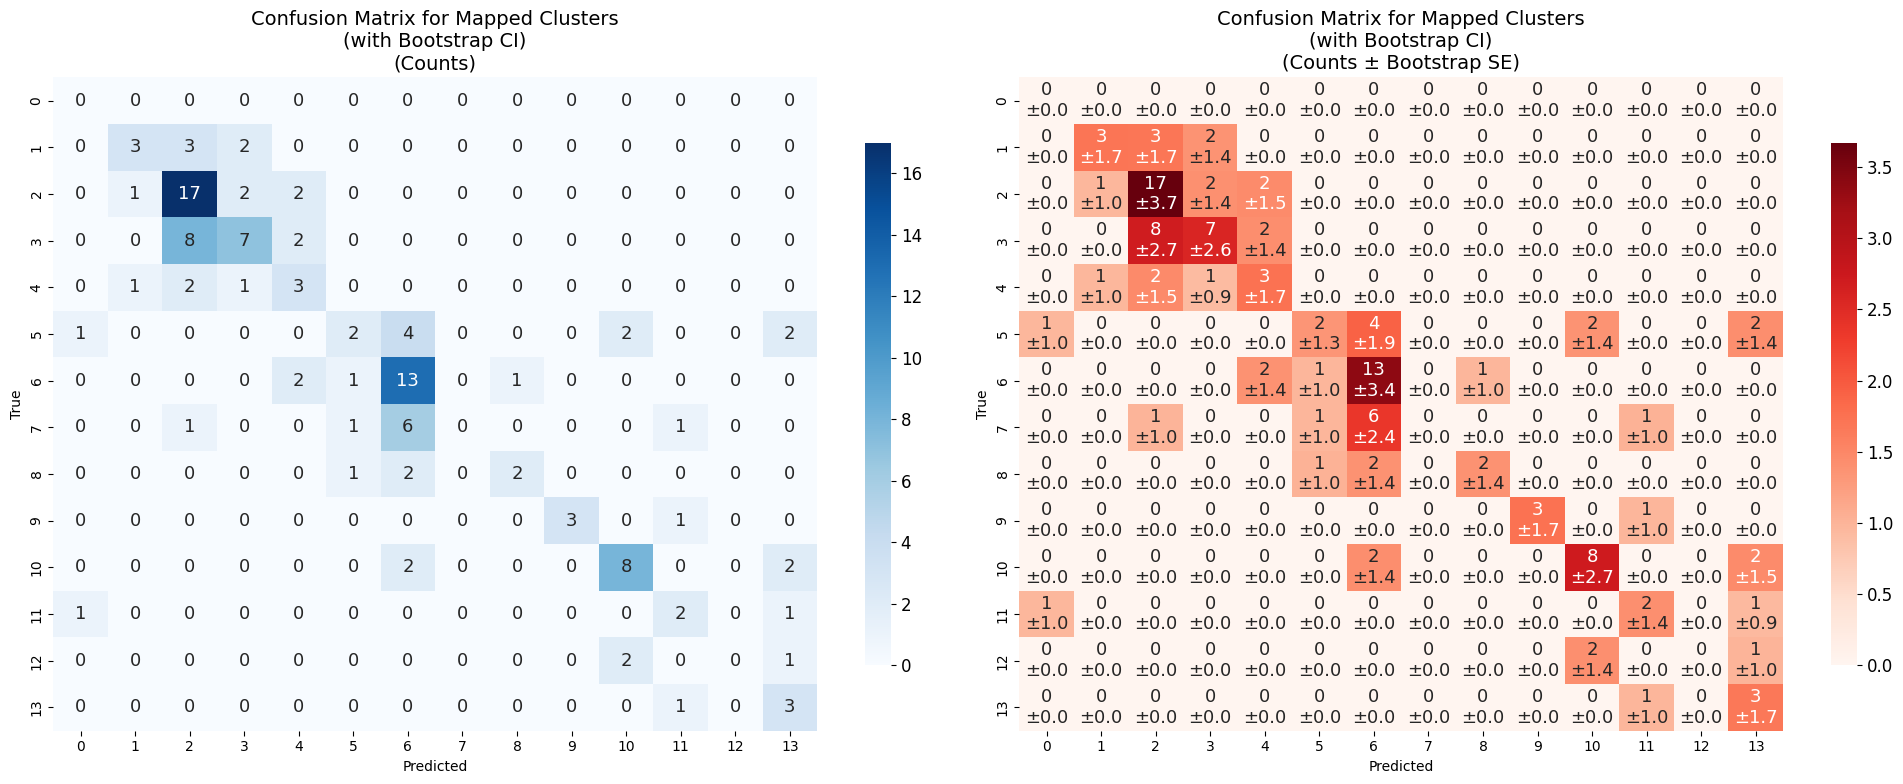


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\gat_gnn_results

Processing: ./ValidationWDE/community_results\gcn_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gcn_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 19
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.46
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 6.47
Ortalama Küme Saflığı: 54.60%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.1726
Normalized Mutual Information: 0.4973

--- Mapped Evaluation (with CI) ---
Accuracy: 0.4715 (95% CI: [0.3821, 0.6016])
F1-Score (Orijinal): 0.4249 (95% CI: [0.3354, 0.5688])
F1-Score (Adjusted): 0.4249 ⚠️


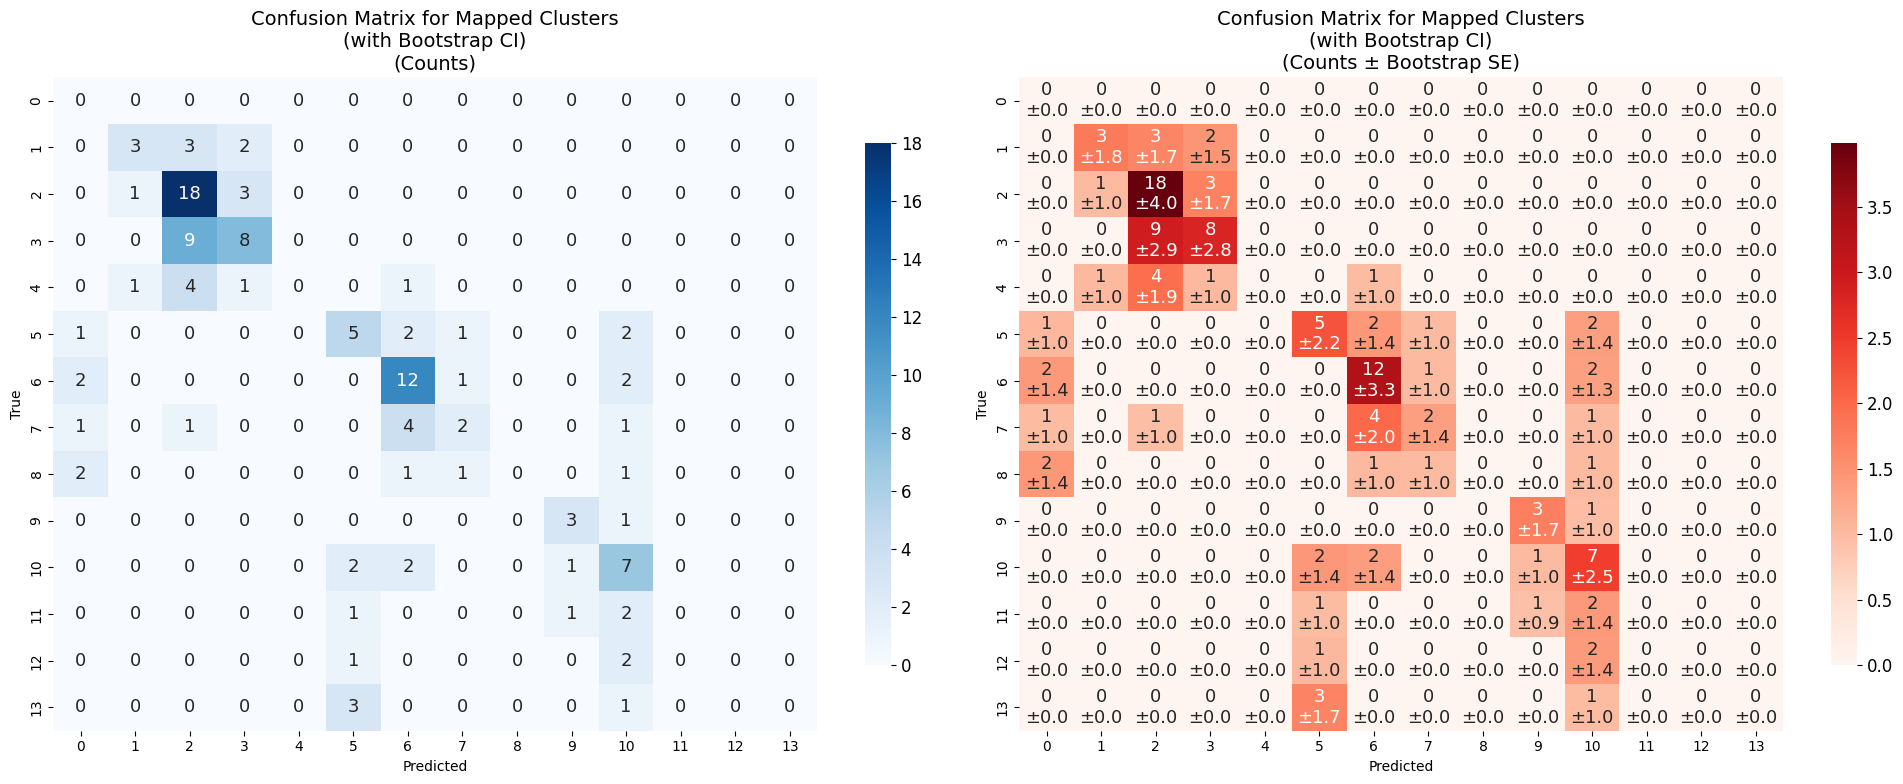


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\gcn_gnn_results

Processing: ./ValidationWDE/community_results\infomap_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: infomap_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 1
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.08
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 123.00
Ortalama Küme Saflığı: 18.03%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.0000

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1803 (95% CI: [0.1148, 0.2930])
F1-Score (Orijinal): 0.0551 (95% CI: [0.0236, 0.1345])
F1-Score (Adjusted): 0.0551 ⚠️


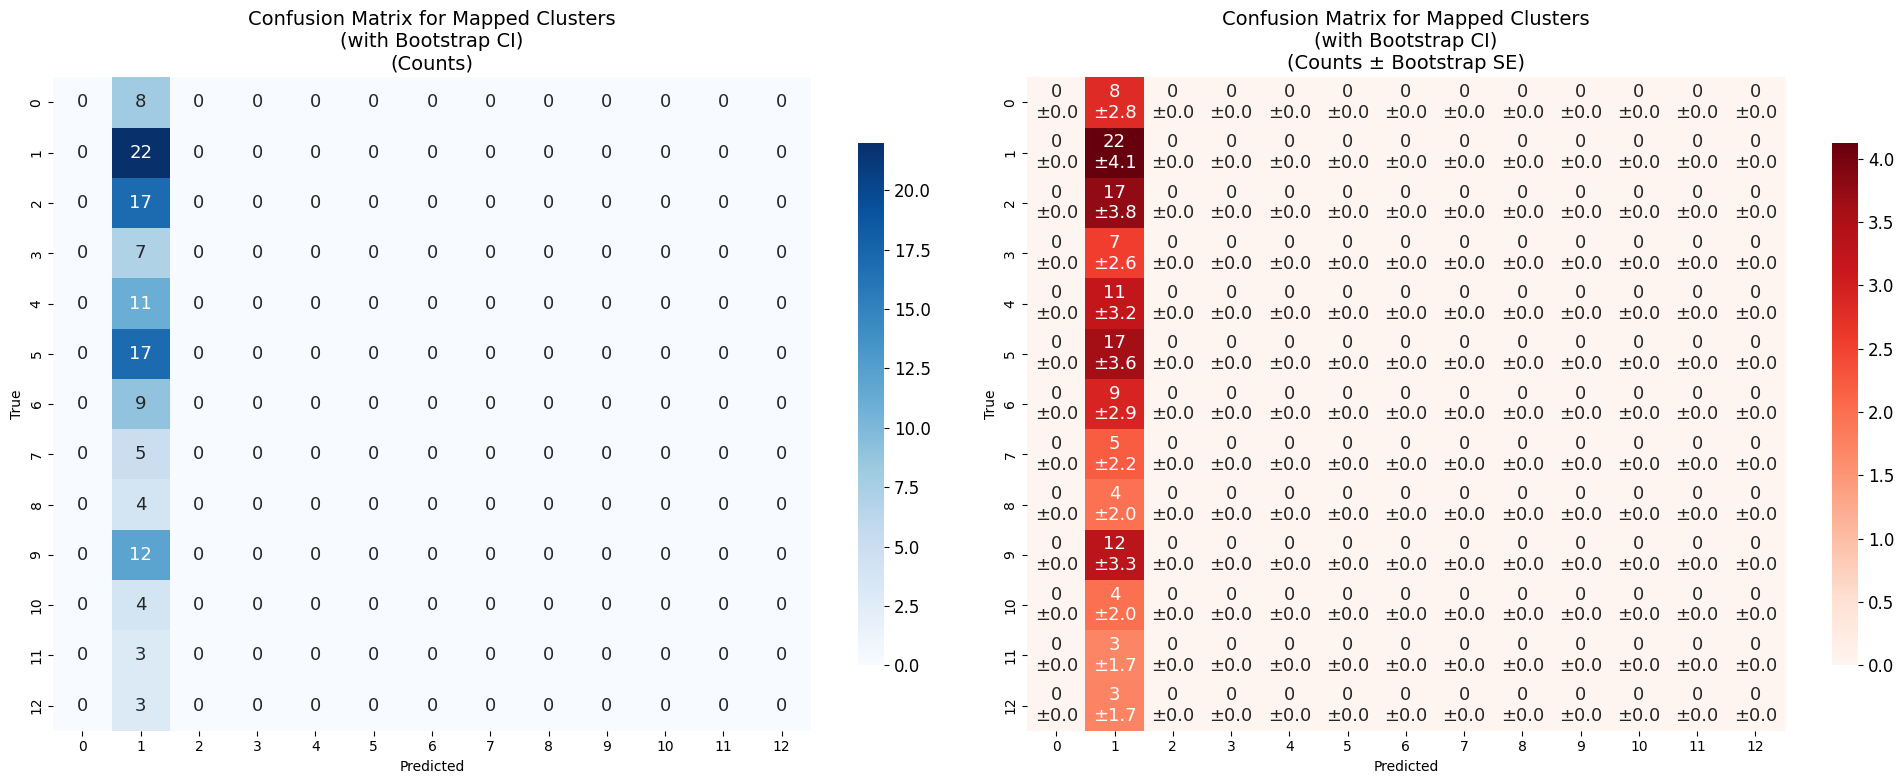


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\infomap_results

Processing: ./ValidationWDE/community_results\label_propagation_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: label_propagation_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 2
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.15
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 61.50
Ortalama Küme Saflığı: 20.58%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0013
Normalized Mutual Information: 0.0346

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2049 (95% CI: [0.1391, 0.3504])
F1-Score (Orijinal): 0.0993 (95% CI: [0.0566, 0.2033])
F1-Score (Adjusted): 0.0993 ⚠️


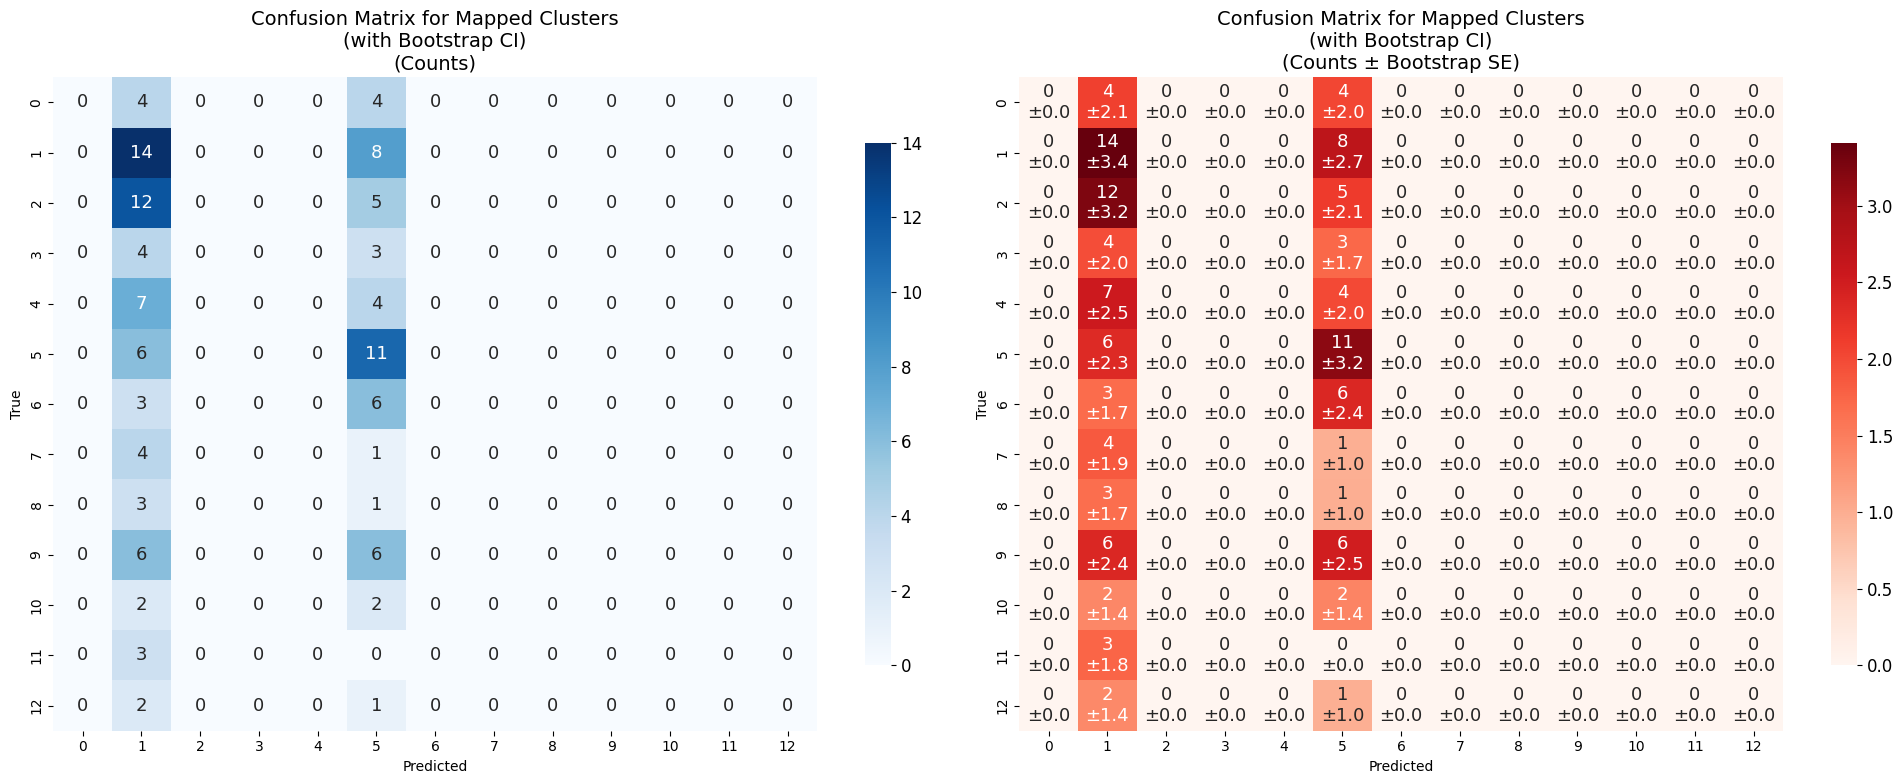


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\label_propagation_results

Processing: ./ValidationWDE/community_results\leiden_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: leiden_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 3
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.23
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 41.00
Ortalama Küme Saflığı: 19.87%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0027
Normalized Mutual Information: 0.0562

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2049 (95% CI: [0.1311, 0.3033])
F1-Score (Orijinal): 0.1082 (95% CI: [0.0639, 0.2167])
F1-Score (Adjusted): 0.1082 ⚠️


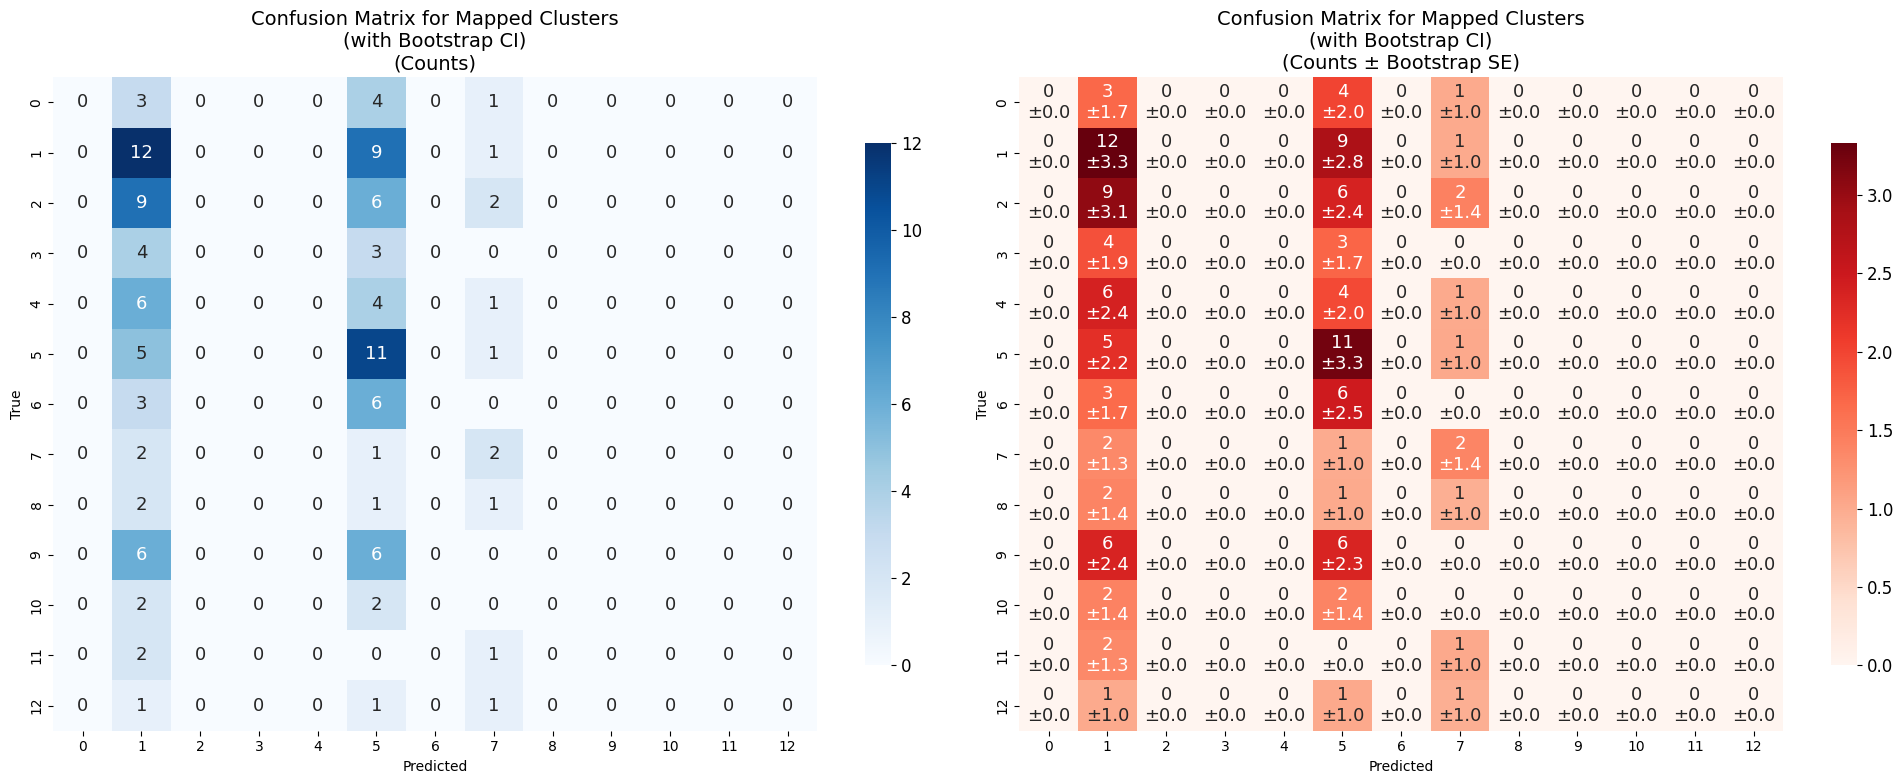


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\leiden_results

Processing: ./ValidationWDE/community_results\louvain_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: louvain_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 3
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.23
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 41.00
Ortalama Küme Saflığı: 19.87%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0027
Normalized Mutual Information: 0.0562

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2049 (95% CI: [0.1391, 0.3115])
F1-Score (Orijinal): 0.1082 (95% CI: [0.0621, 0.2081])
F1-Score (Adjusted): 0.1082 ⚠️


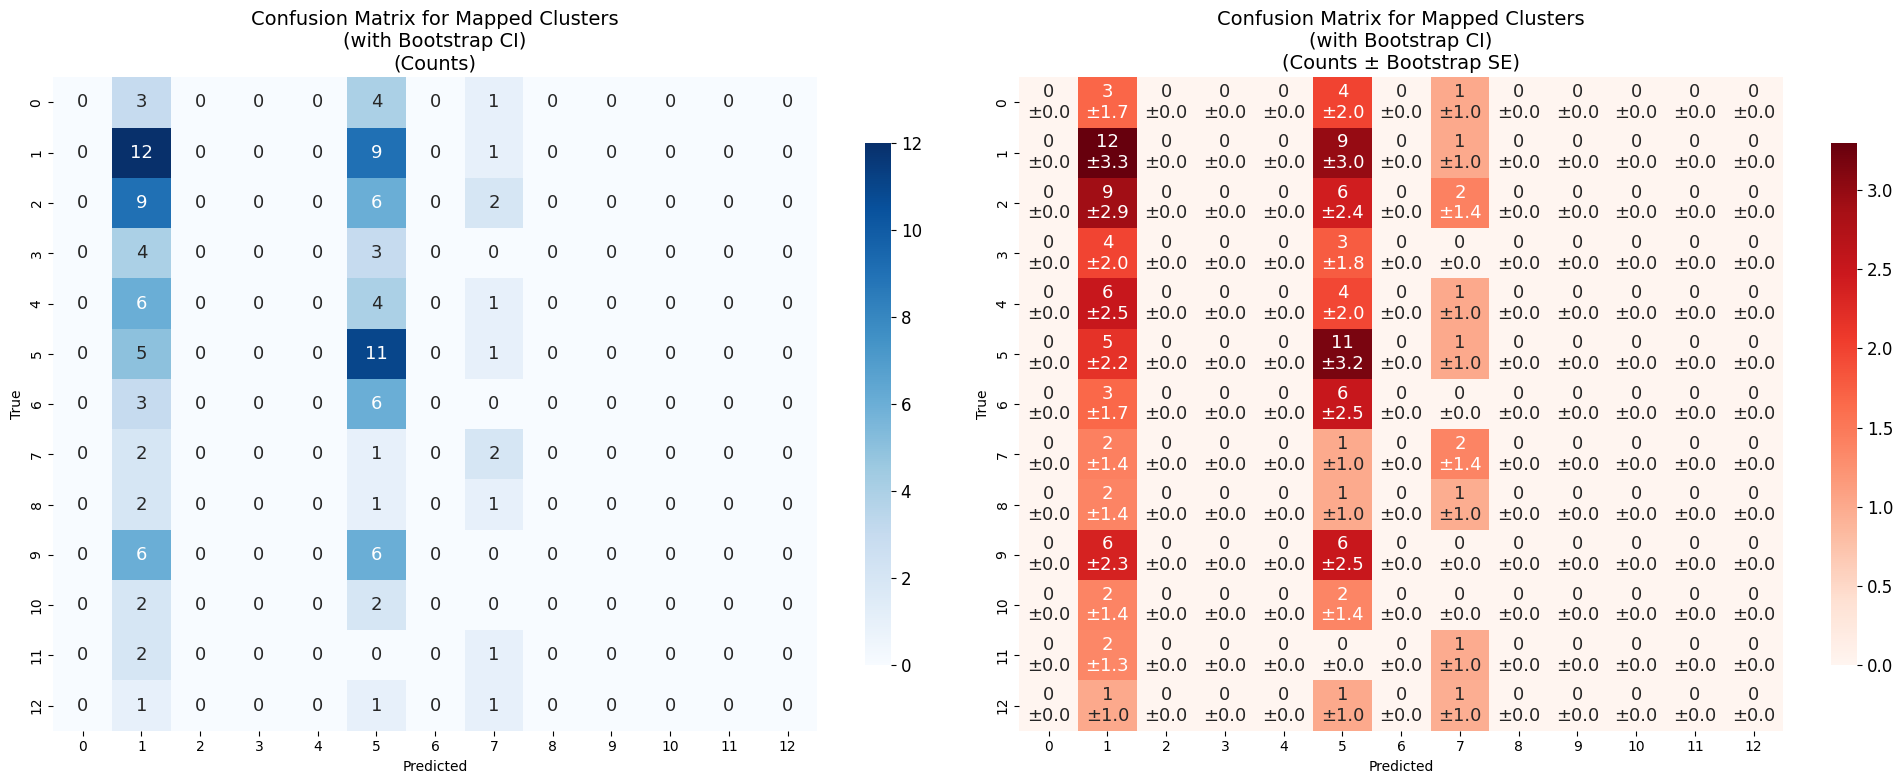


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\louvain_results

Processing: ./ValidationWDE/community_results\Node2Vec_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: Node2Vec_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 123
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 1
Singleton Oranı: 5.00%
Ortalama Küme Boyutu: 6.15
Ortalama Küme Saflığı: 75.69%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.2348
Normalized Mutual Information: 0.6005

--- Mapped Evaluation (with CI) ---
Accuracy: 0.5935 (95% CI: [0.5122, 0.7378])
F1-Score (Orijinal): 0.5738 (95% CI: [0.4858, 0.7440])
F1-Score (Adjusted): 0.5738 ⚠️


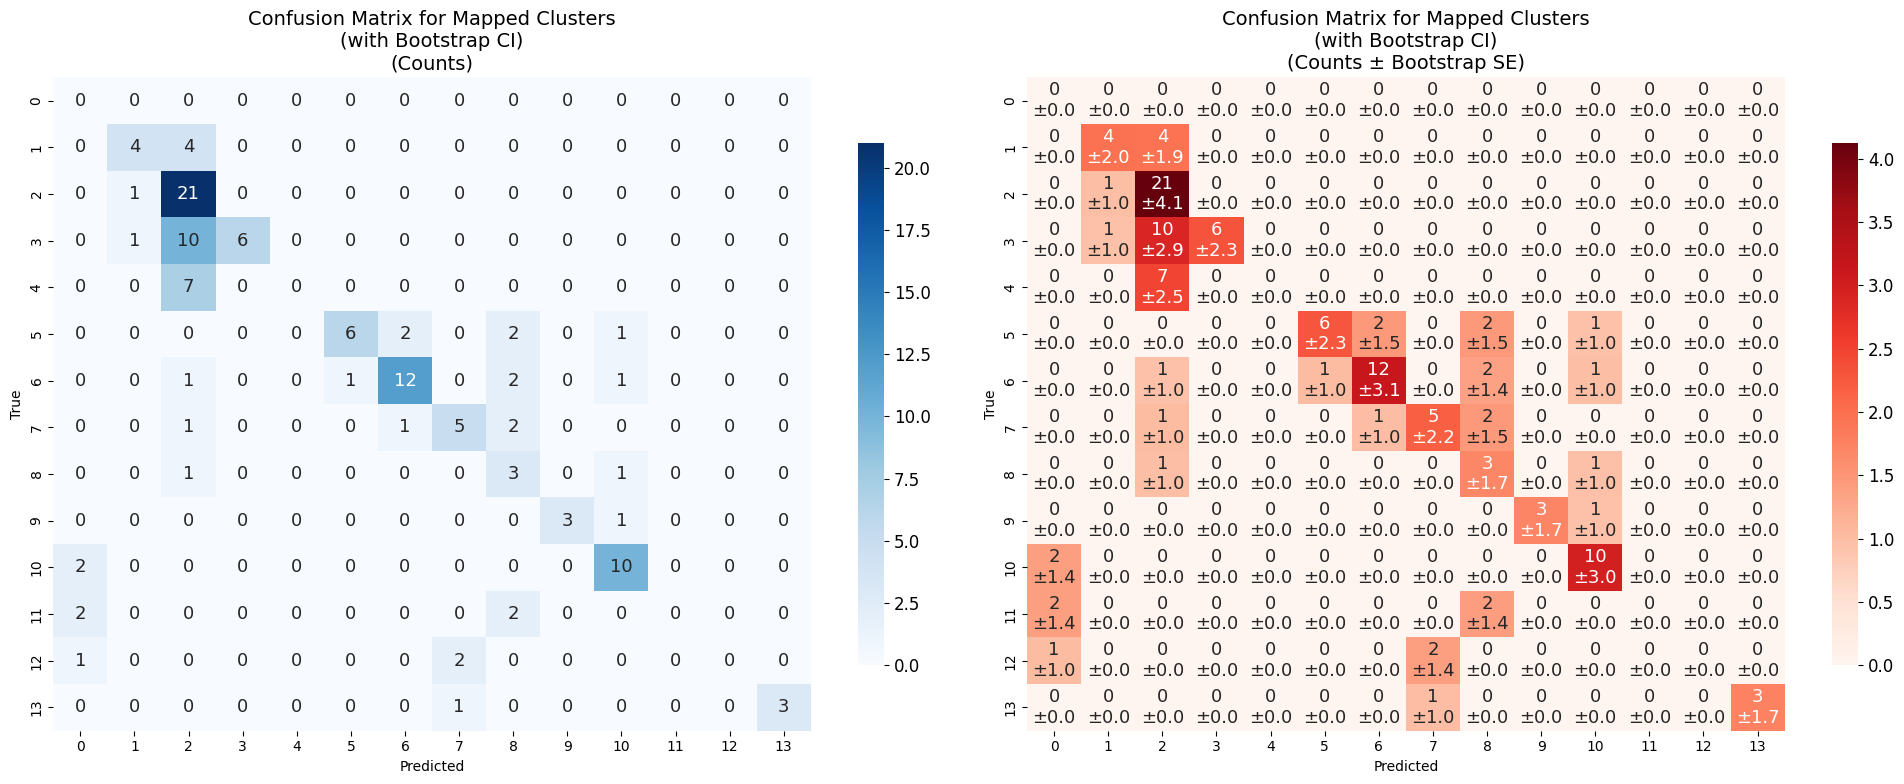


Tüm sonuçlar kaydedildi: ./ValidationWDE\results\Node2Vec_results
Found 9 result files.

Processing: ./TrainingGeo/community_results\edge_betweenness_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: edge_betweenness_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 43
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 3.31
Singleton (Tek Elemanlı) Küme Sayısı: 42
Singleton Oranı: 97.67%
Ortalama Küme Boyutu: 1.37
Ortalama Küme Saflığı: 98.04%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0193
Normalized Mutual Information: 0.6402

--- Mapped Evaluation (with CI) ---
Accuracy: 0.0517 (95% CI: [0.0000, 0.1552])
F1-Score (Orijinal): 0.0302 (95% CI: [0.0000, 0.1272])
F1-Score (Adjusted): 0.0002 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (97.7%)!
⚠️  UYARI: Küme sayısı kat sayısının 3.3x fazla!
⚠️  UYARI: Ortalama küme boyutu çok küçük (1.4)!


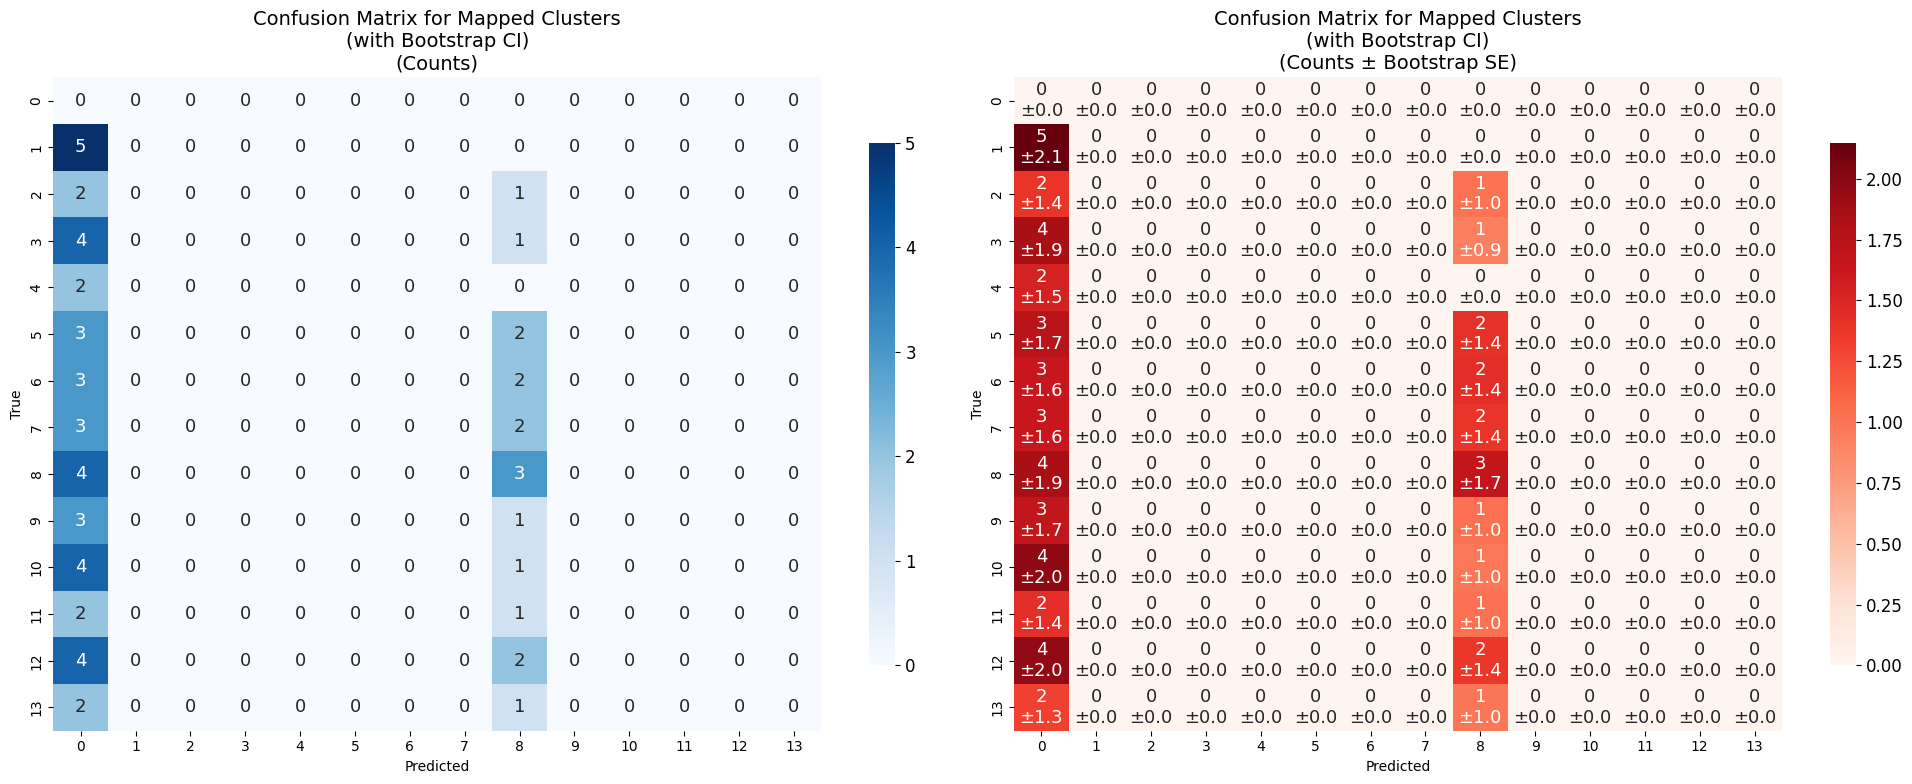


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\edge_betweenness_results

Processing: ./TrainingGeo/community_results\fast_greedy_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: fast_greedy_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 4
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.31
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 14.75
Ortalama Küme Saflığı: 25.00%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0050
Normalized Mutual Information: 0.1707

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2241 (95% CI: [0.1207, 0.4354])
F1-Score (Orijinal): 0.1261 (95% CI: [0.0622, 0.2967])
F1-Score (Adjusted): 0.1261 ⚠️


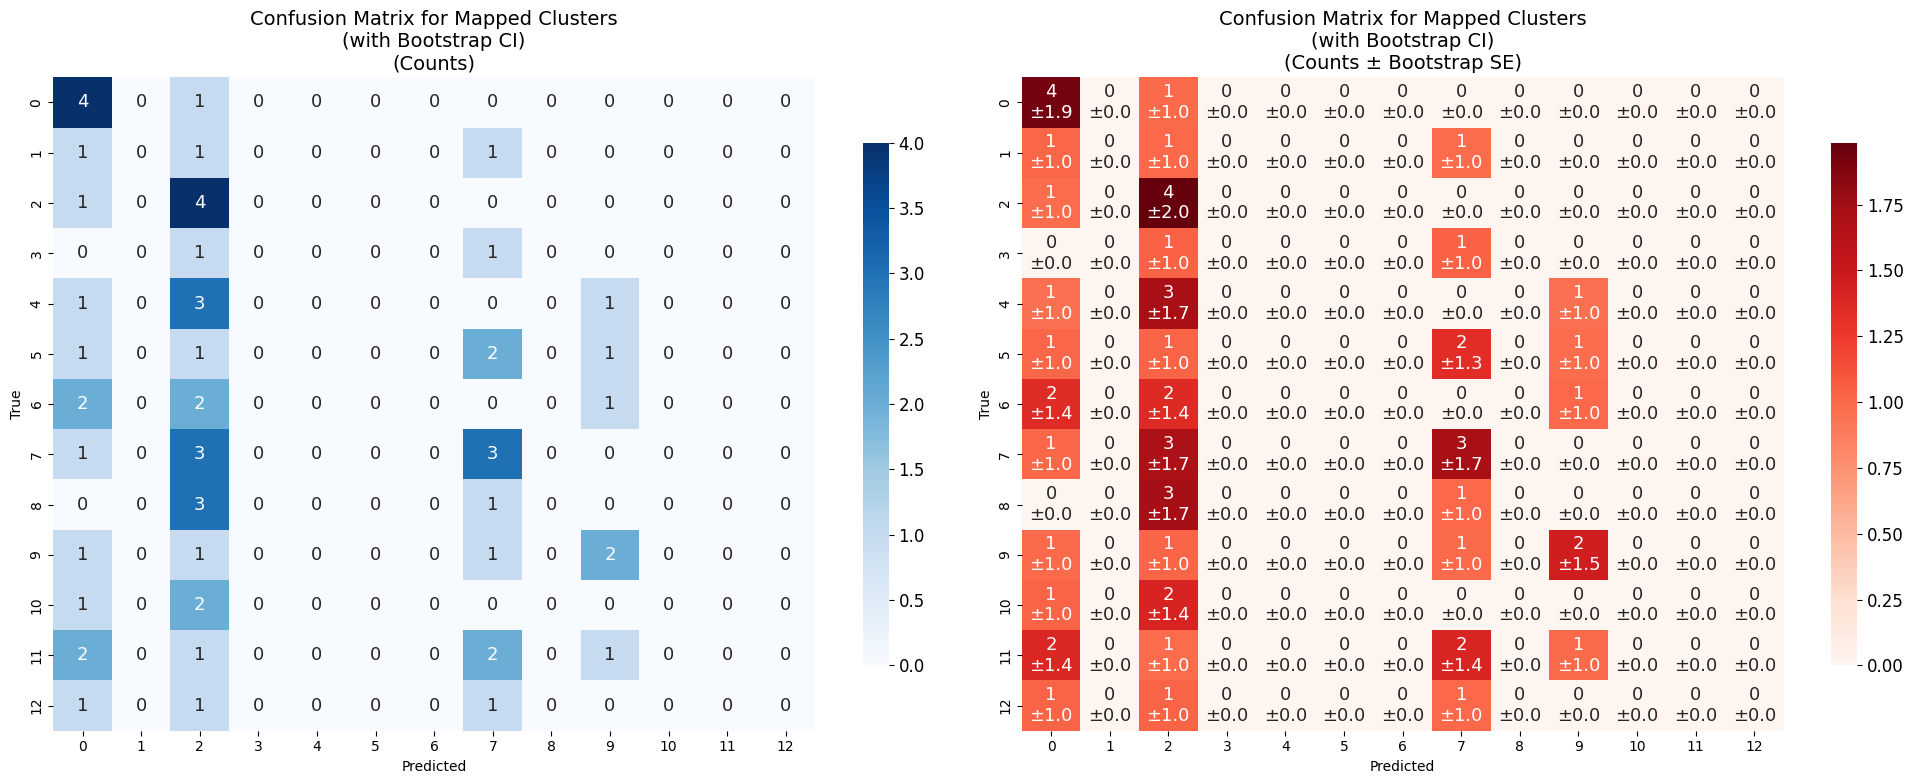


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\fast_greedy_results

Processing: ./TrainingGeo/community_results\gat_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gat_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 7
Singleton Oranı: 35.00%
Ortalama Küme Boyutu: 2.95
Ortalama Küme Saflığı: 77.48%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.2844
Normalized Mutual Information: 0.7219

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3729 (95% CI: [0.2542, 0.5551])
F1-Score (Orijinal): 0.3229 (95% CI: [0.2007, 0.5386])
F1-Score (Adjusted): 0.3229 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (35.0%)!


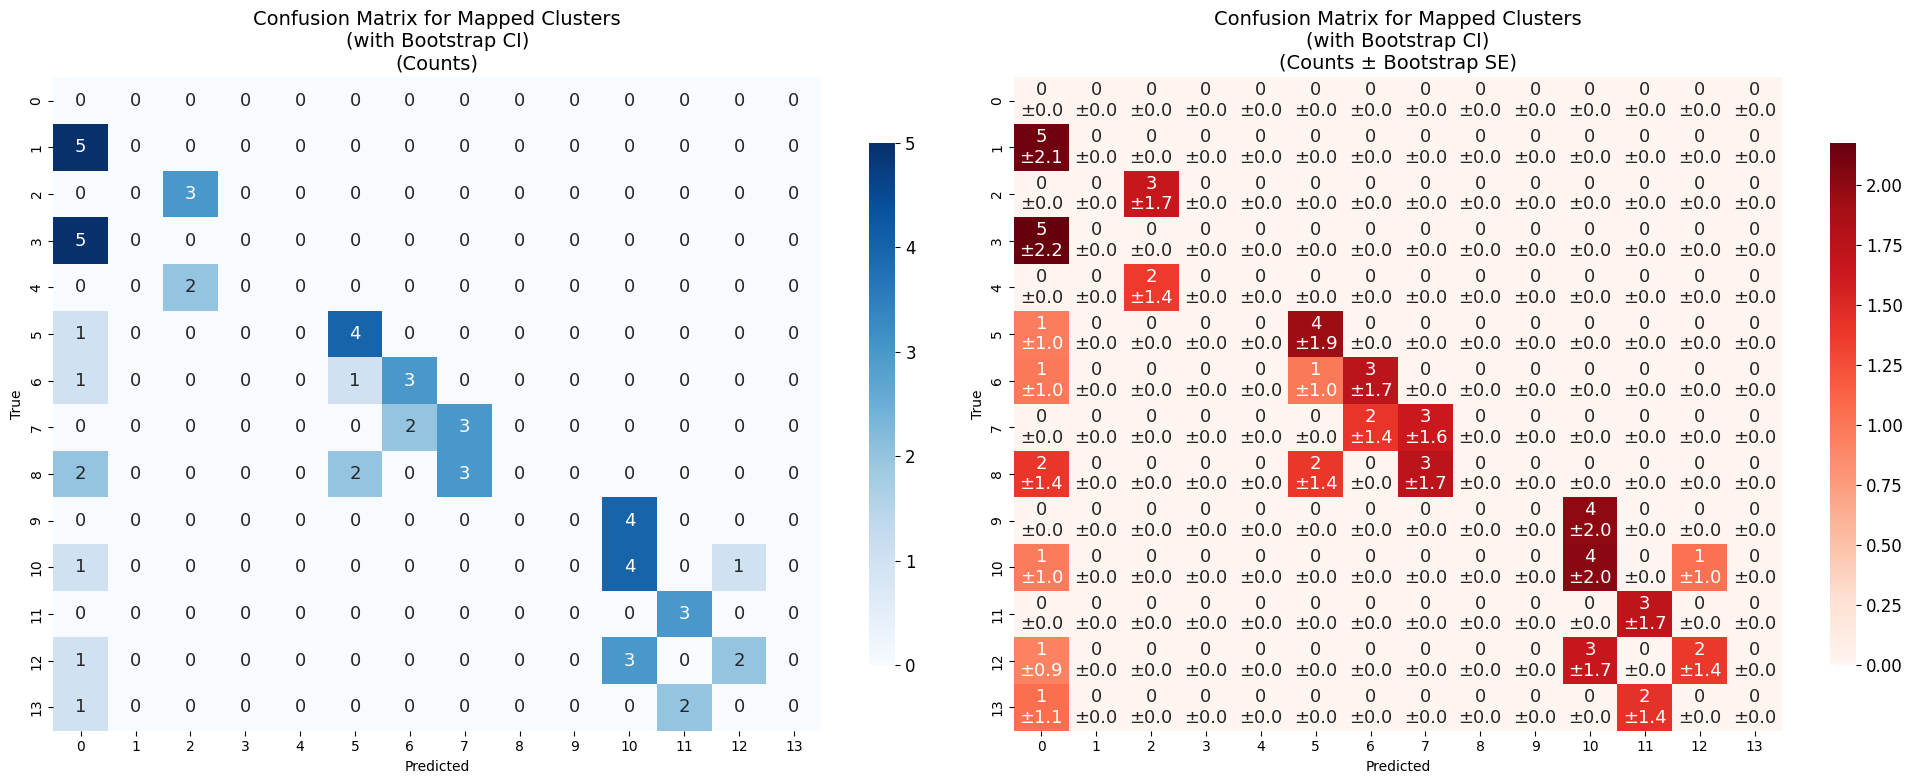


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\gat_gnn_results

Processing: ./TrainingGeo/community_results\gcn_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gcn_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 7
Singleton Oranı: 35.00%
Ortalama Küme Boyutu: 2.95
Ortalama Küme Saflığı: 81.04%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.2210
Normalized Mutual Information: 0.6856

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2881 (95% CI: [0.1864, 0.4661])
F1-Score (Orijinal): 0.2303 (95% CI: [0.1284, 0.4113])
F1-Score (Adjusted): 0.2303 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (35.0%)!


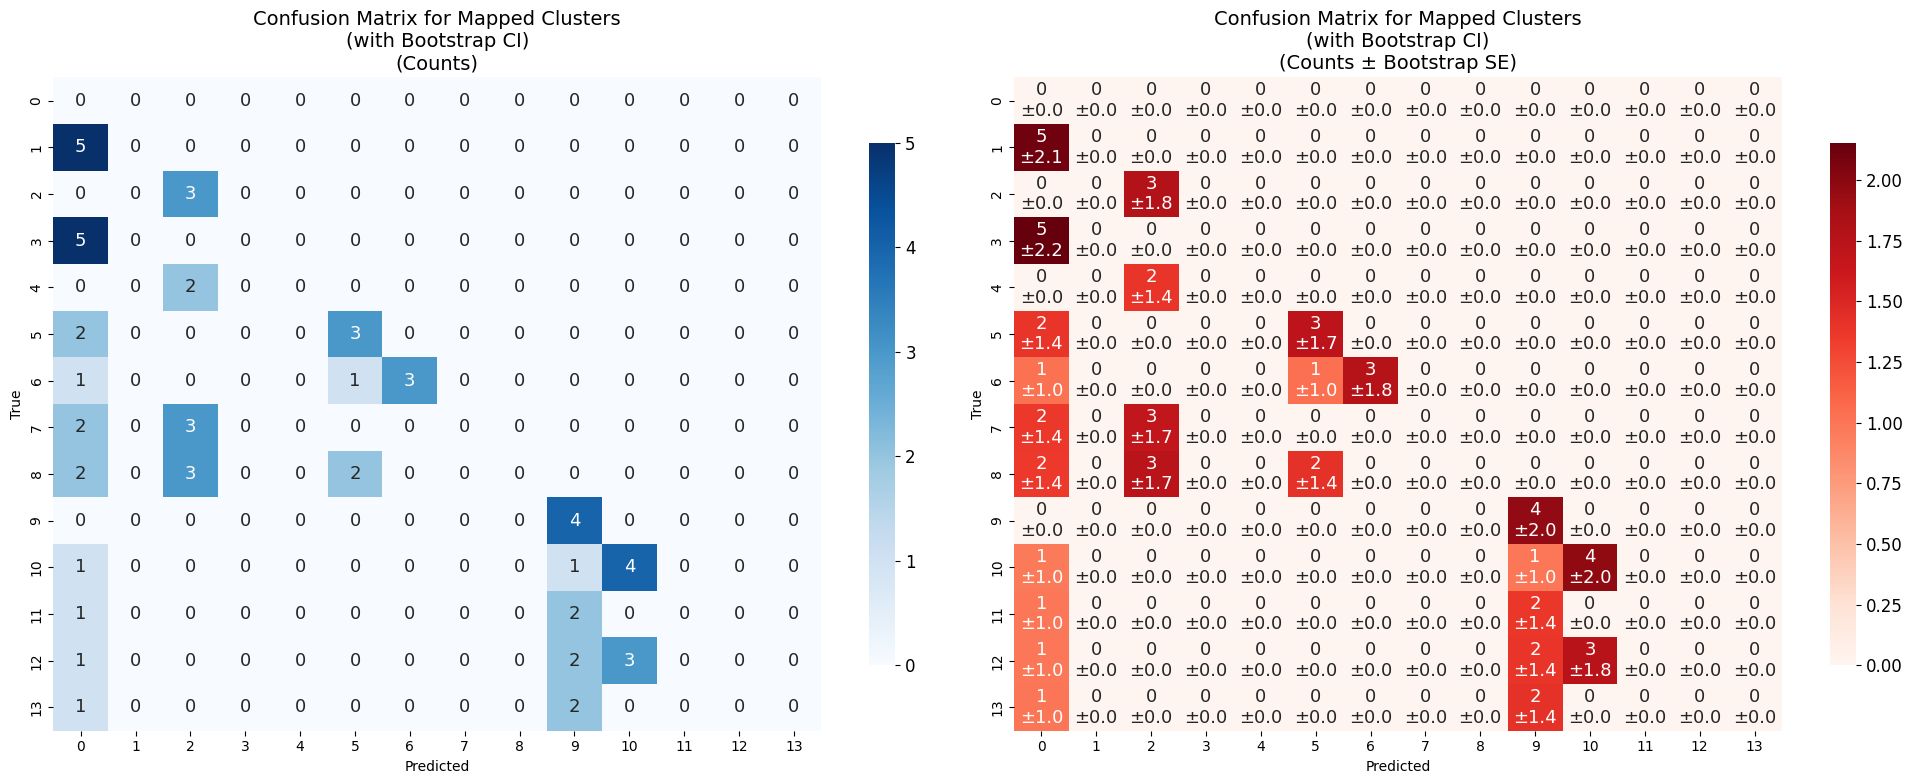


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\gcn_gnn_results

Processing: ./TrainingGeo/community_results\infomap_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: infomap_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 1
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.08
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 59.00
Ortalama Küme Saflığı: 12.07%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.0000

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1207 (95% CI: [0.0517, 0.2586])
F1-Score (Orijinal): 0.0260 (95% CI: [0.0023, 0.1160])
F1-Score (Adjusted): 0.0260 ⚠️


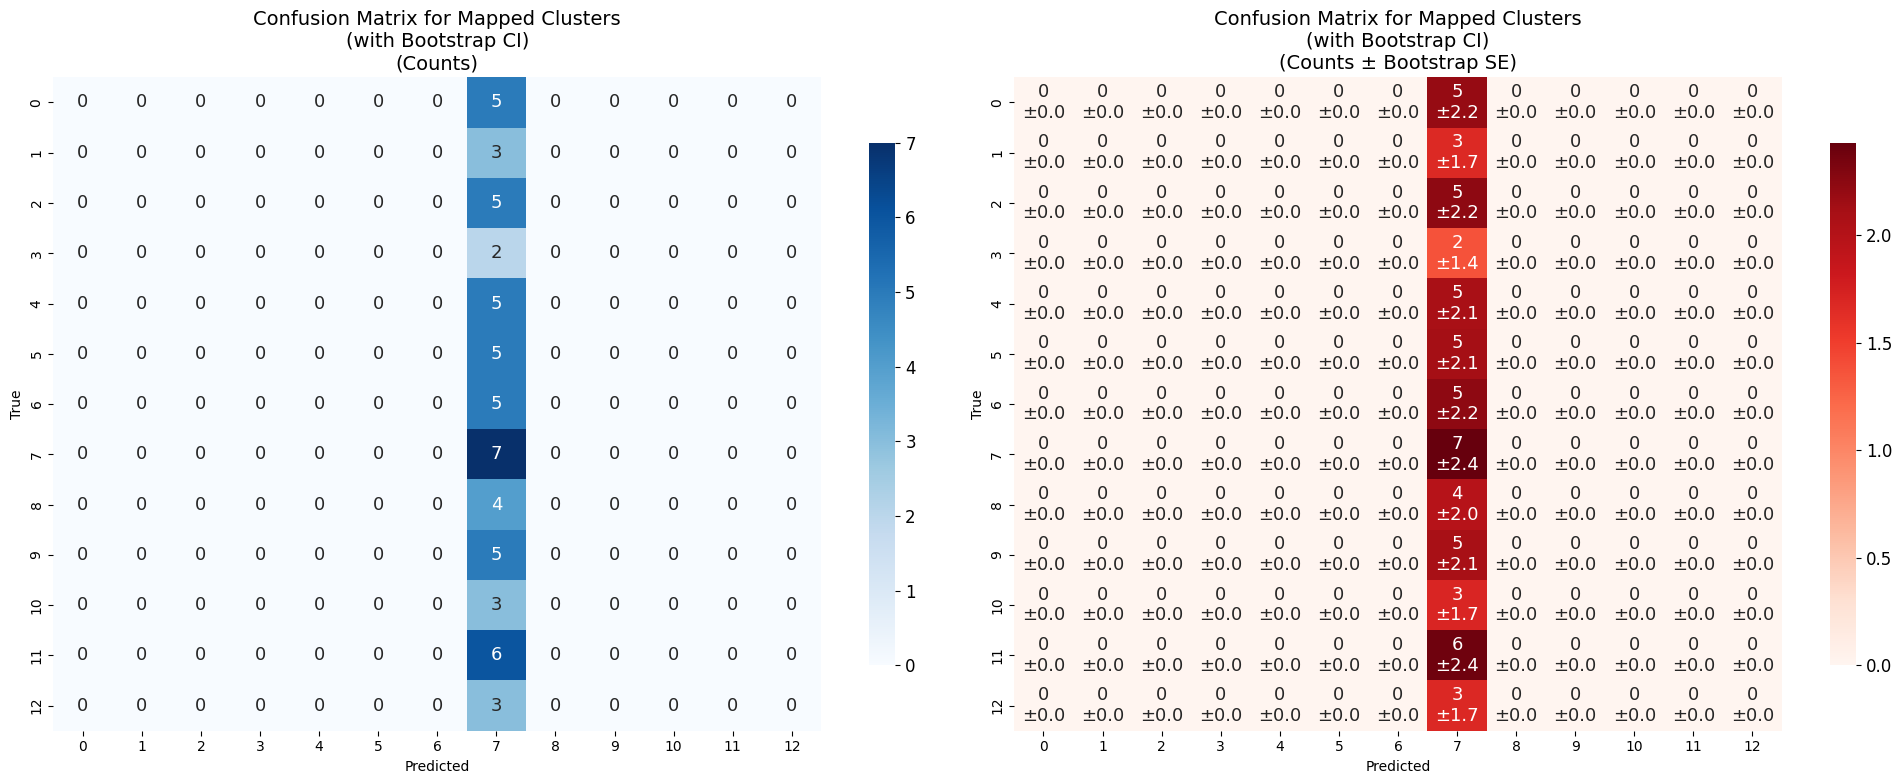


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\infomap_results

Processing: ./TrainingGeo/community_results\label_propagation_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: label_propagation_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 59
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 4.54
Singleton (Tek Elemanlı) Küme Sayısı: 59
Singleton Oranı: 100.00%
Ortalama Küme Boyutu: 1.00
Ortalama Küme Saflığı: 100.00%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.7655

--- Mapped Evaluation (with CI) ---
Accuracy: 0.0000 (95% CI: [0.0000, 0.0000])
F1-Score (Orijinal): 0.0000 (95% CI: [0.0000, 0.0000])
F1-Score (Adjusted): 0.0000 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (100.0%)!
⚠️  UYARI: Küme sayısı kat sayısının 4.5x fazla!
⚠️  UYARI: Ortalama küme boyutu çok küçük (1.0)!


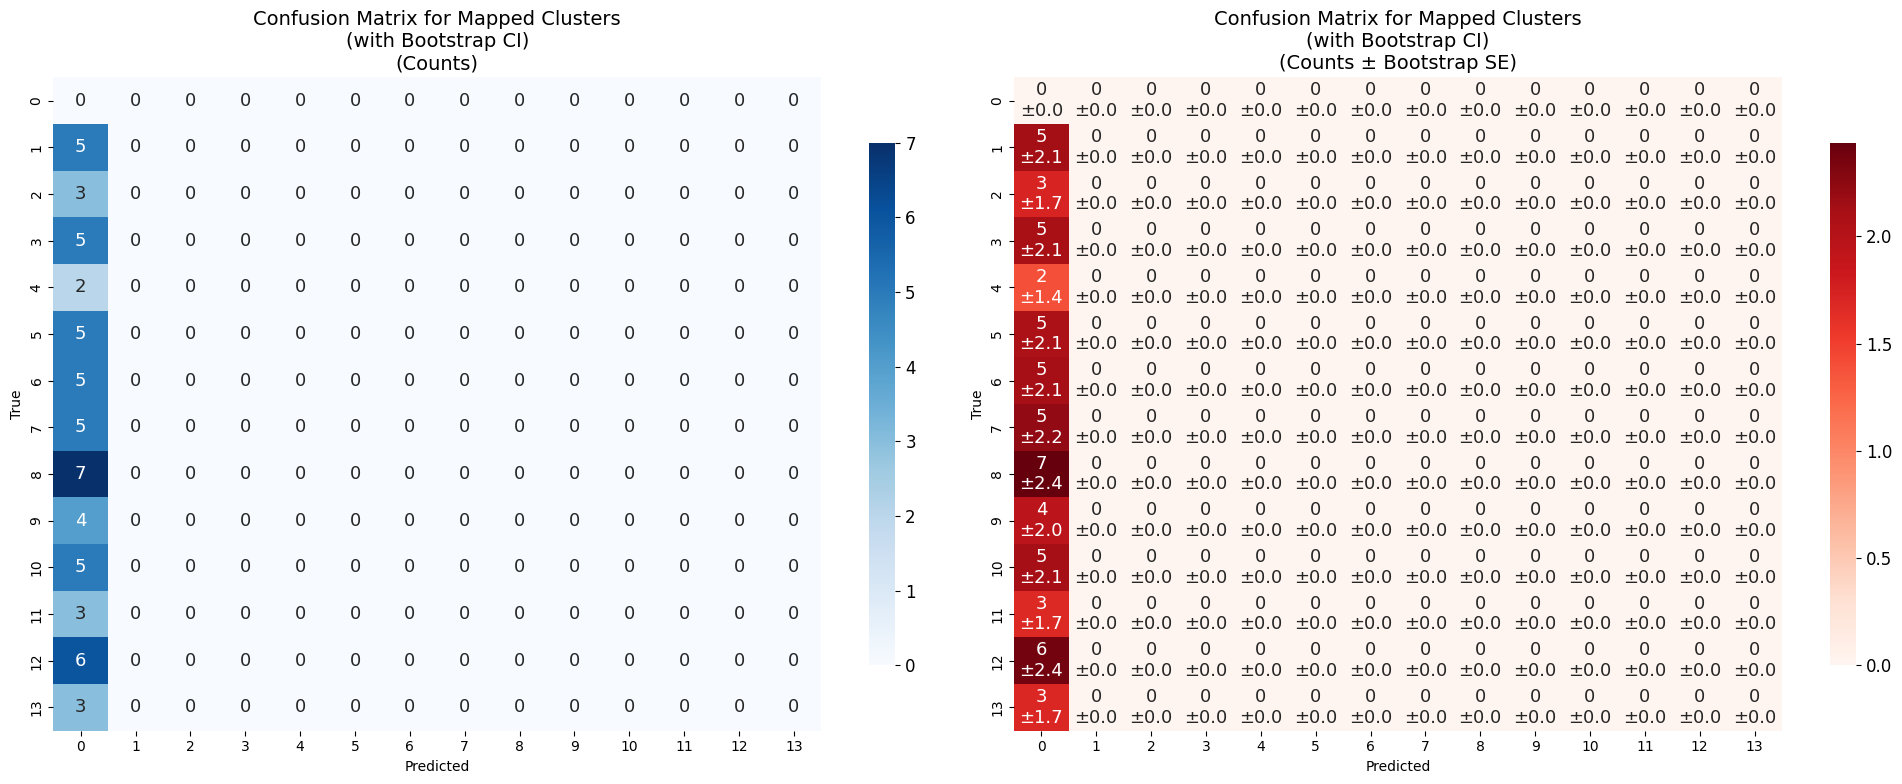


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\label_propagation_results

Processing: ./TrainingGeo/community_results\leiden_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: leiden_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 5
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.38
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 11.80
Ortalama Küme Saflığı: 23.45%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0061
Normalized Mutual Information: 0.2606

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2241 (95% CI: [0.1379, 0.3793])
F1-Score (Orijinal): 0.1439 (95% CI: [0.0718, 0.3325])
F1-Score (Adjusted): 0.1439 ⚠️


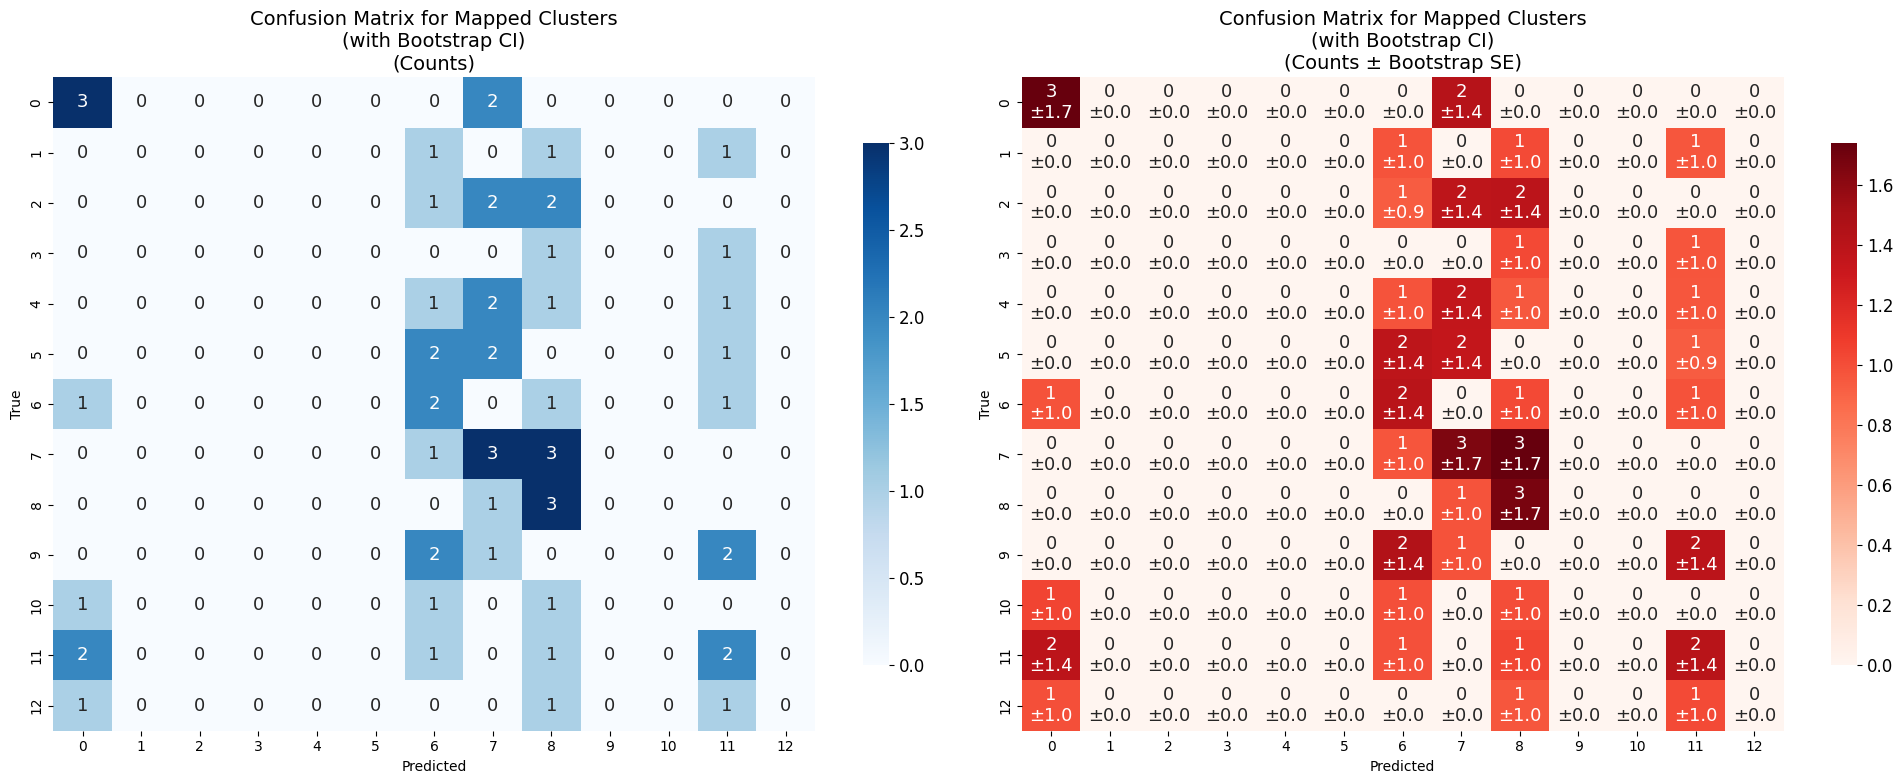


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\leiden_results

Processing: ./TrainingGeo/community_results\louvain_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: louvain_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 5
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.38
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 11.80
Ortalama Küme Saflığı: 16.86%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0333
Normalized Mutual Information: 0.1928

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1724 (95% CI: [0.0862, 0.3535])
F1-Score (Orijinal): 0.0943 (95% CI: [0.0332, 0.2229])
F1-Score (Adjusted): 0.0943 ⚠️


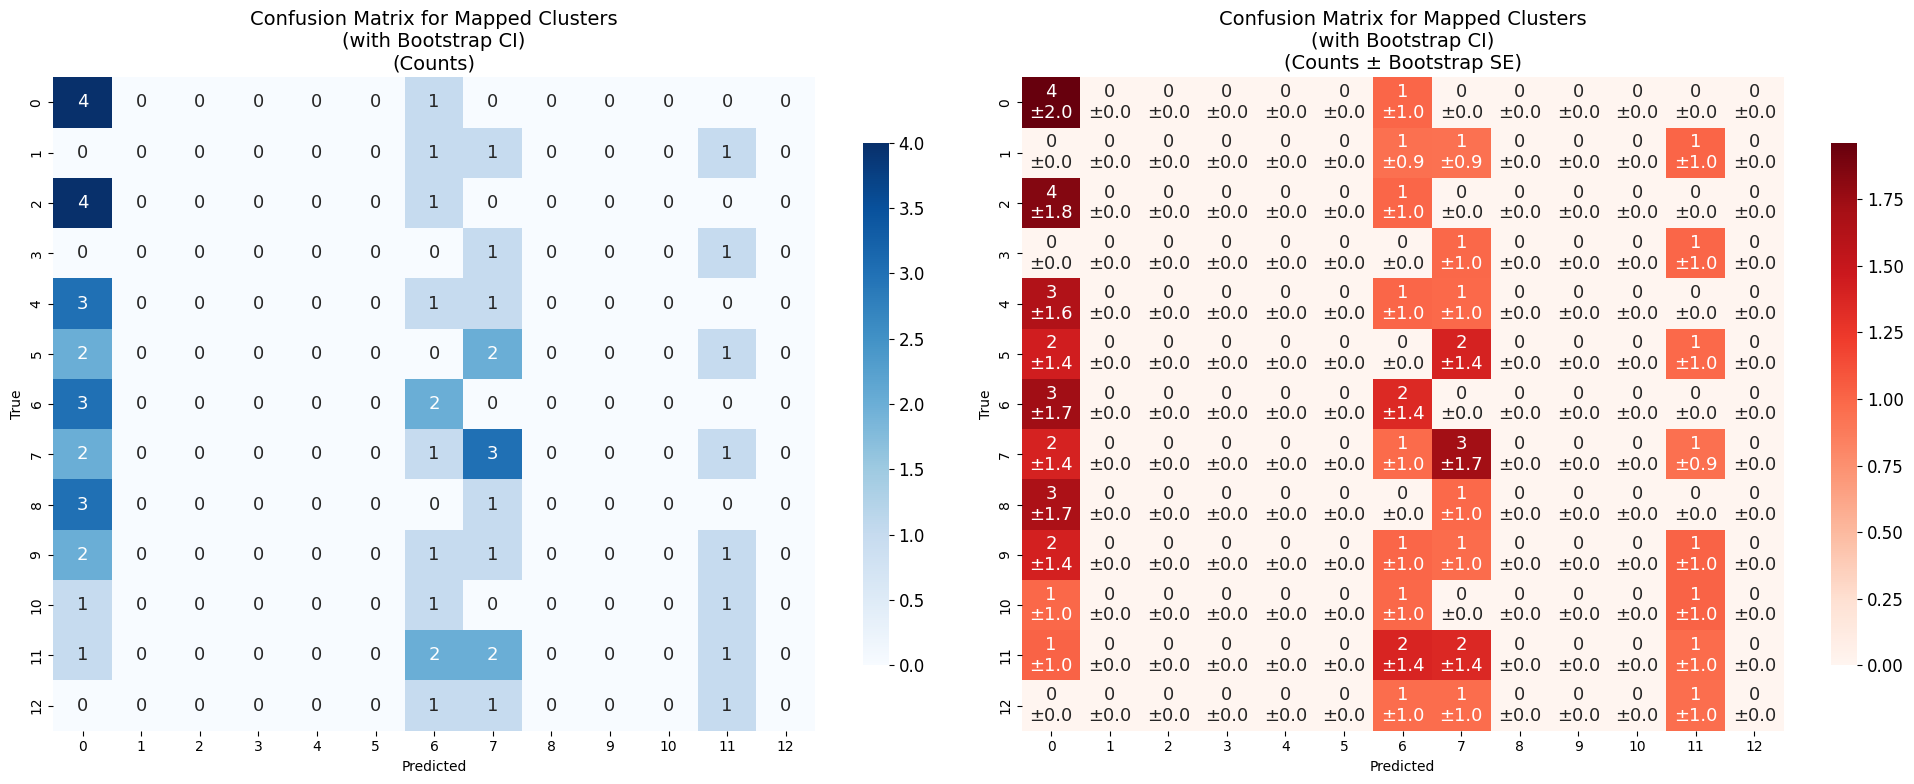


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\louvain_results

Processing: ./TrainingGeo/community_results\Node2Vec_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: Node2Vec_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 6
Singleton Oranı: 30.00%
Ortalama Küme Boyutu: 2.95
Ortalama Küme Saflığı: 89.88%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.4756
Normalized Mutual Information: 0.8003

--- Mapped Evaluation (with CI) ---
Accuracy: 0.6610 (95% CI: [0.5254, 0.8983])
F1-Score (Orijinal): 0.6892 (95% CI: [0.5692, 0.8913])
F1-Score (Adjusted): 0.6892 ⚠️


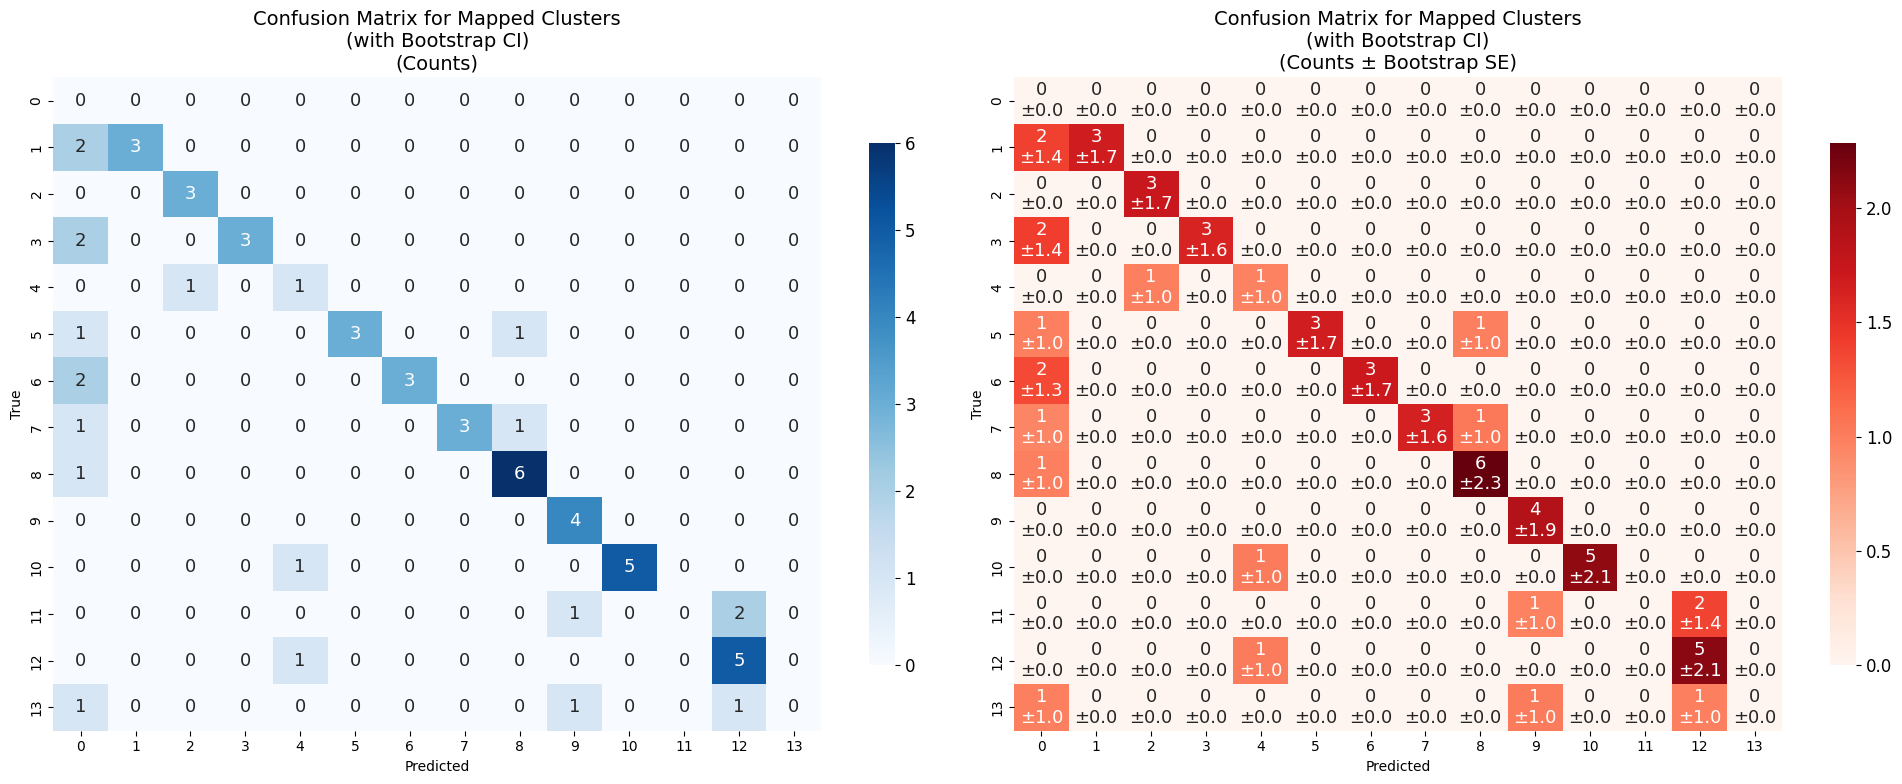


Tüm sonuçlar kaydedildi: ./TrainingGeo\results\Node2Vec_results
Found 9 result files.

Processing: ./TrainingWDE/community_results\edge_betweenness_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: edge_betweenness_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 43
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 3.31
Singleton (Tek Elemanlı) Küme Sayısı: 42
Singleton Oranı: 97.67%
Ortalama Küme Boyutu: 1.37
Ortalama Küme Saflığı: 98.04%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0193
Normalized Mutual Information: 0.6402

--- Mapped Evaluation (with CI) ---
Accuracy: 0.0517 (95% CI: [0.0000, 0.1767])
F1-Score (Orijinal): 0.0302 (95% CI: [0.0000, 0.1802])
F1-Score (Adjusted): 0.0002 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (97.7%)!
⚠️  UYARI: Küme sayısı kat sayısının 3.3x fazla!
⚠️  UYARI: Ortalama küme boyutu çok küçük (1.4)!


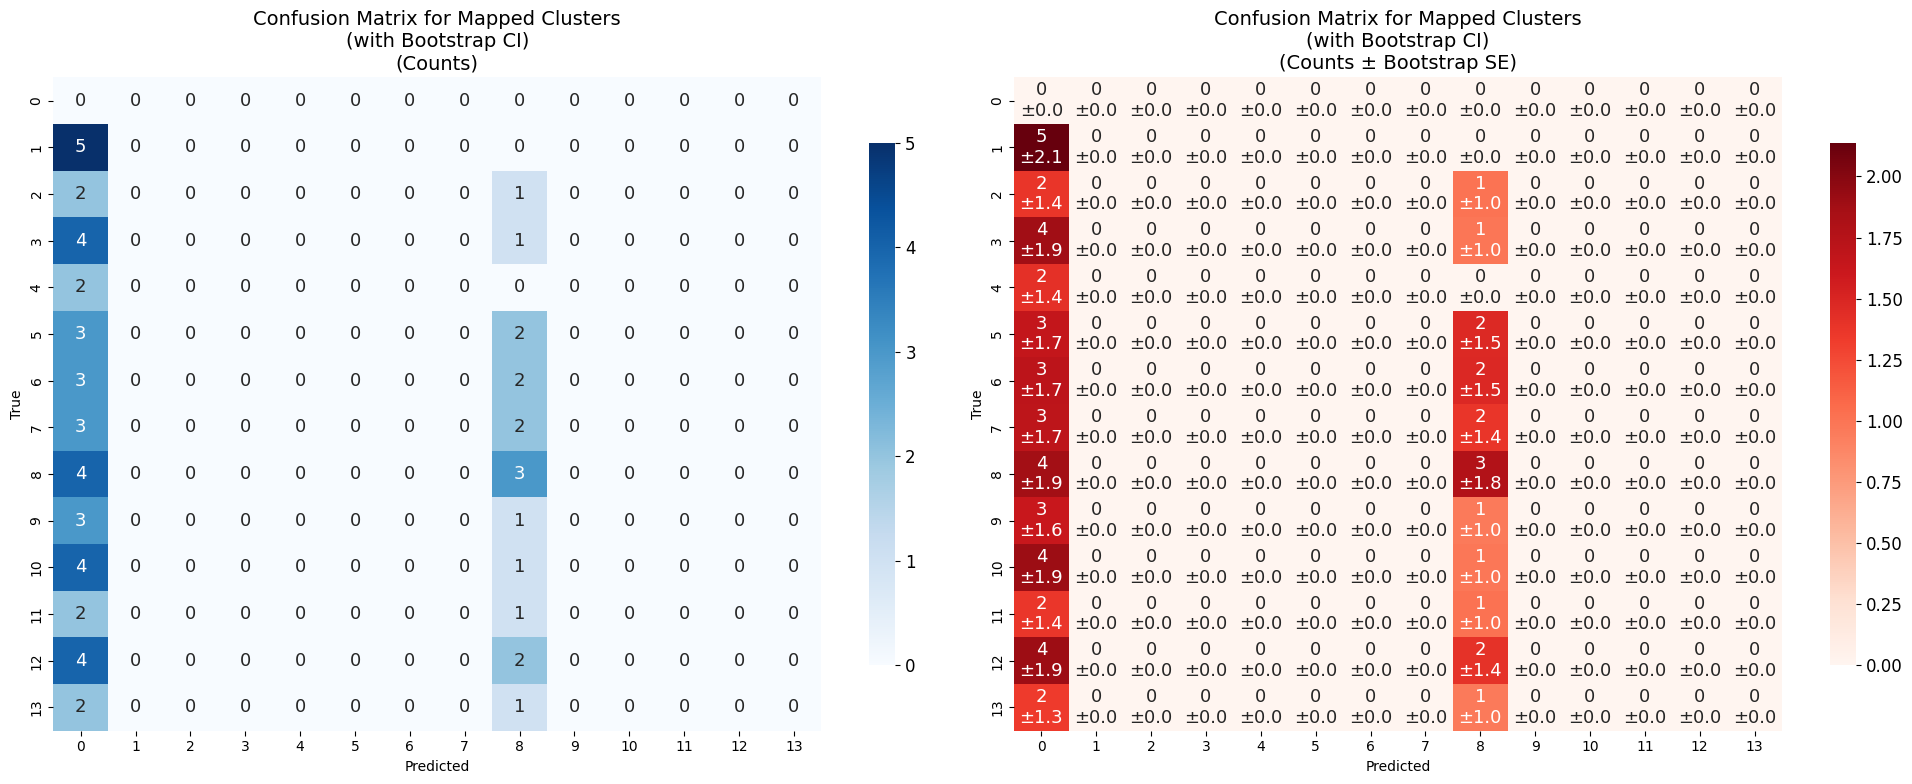


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\edge_betweenness_results

Processing: ./TrainingWDE/community_results\fast_greedy_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: fast_greedy_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 4
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.31
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 14.75
Ortalama Küme Saflığı: 25.00%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0050
Normalized Mutual Information: 0.1707

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2241 (95% CI: [0.1207, 0.3793])
F1-Score (Orijinal): 0.1261 (95% CI: [0.0570, 0.2956])
F1-Score (Adjusted): 0.1261 ⚠️


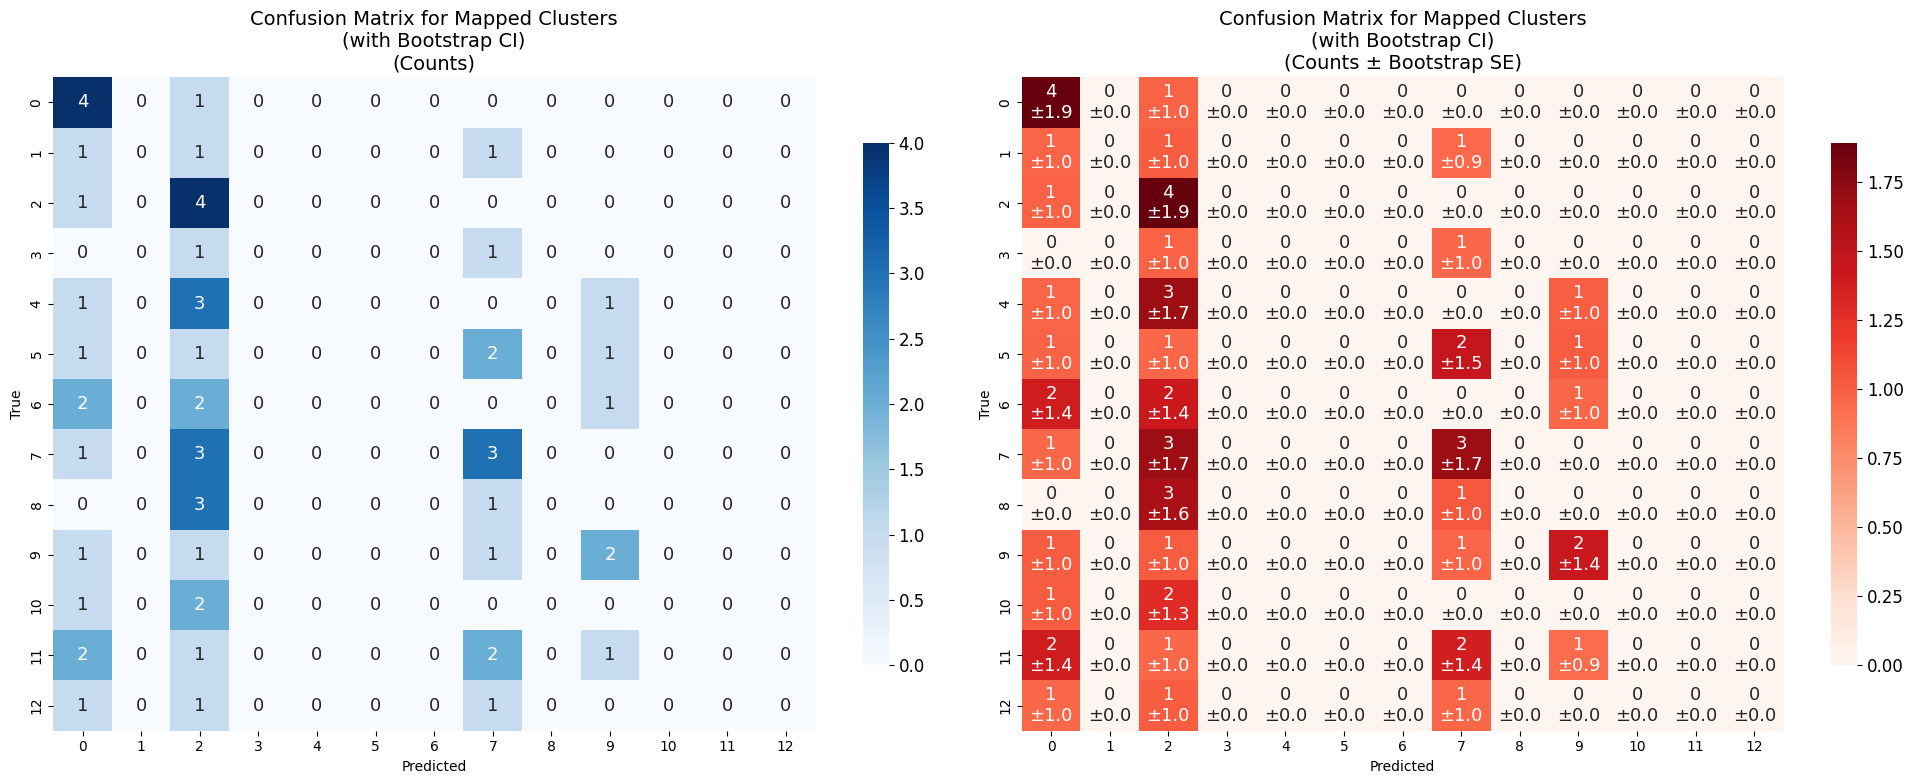


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\fast_greedy_results

Processing: ./TrainingWDE/community_results\gat_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gat_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 5
Singleton Oranı: 25.00%
Ortalama Küme Boyutu: 2.95
Ortalama Küme Saflığı: 78.48%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.2840
Normalized Mutual Information: 0.7267

--- Mapped Evaluation (with CI) ---
Accuracy: 0.3559 (95% CI: [0.2373, 0.5424])
F1-Score (Orijinal): 0.3232 (95% CI: [0.1984, 0.5316])
F1-Score (Adjusted): 0.3232 ⚠️


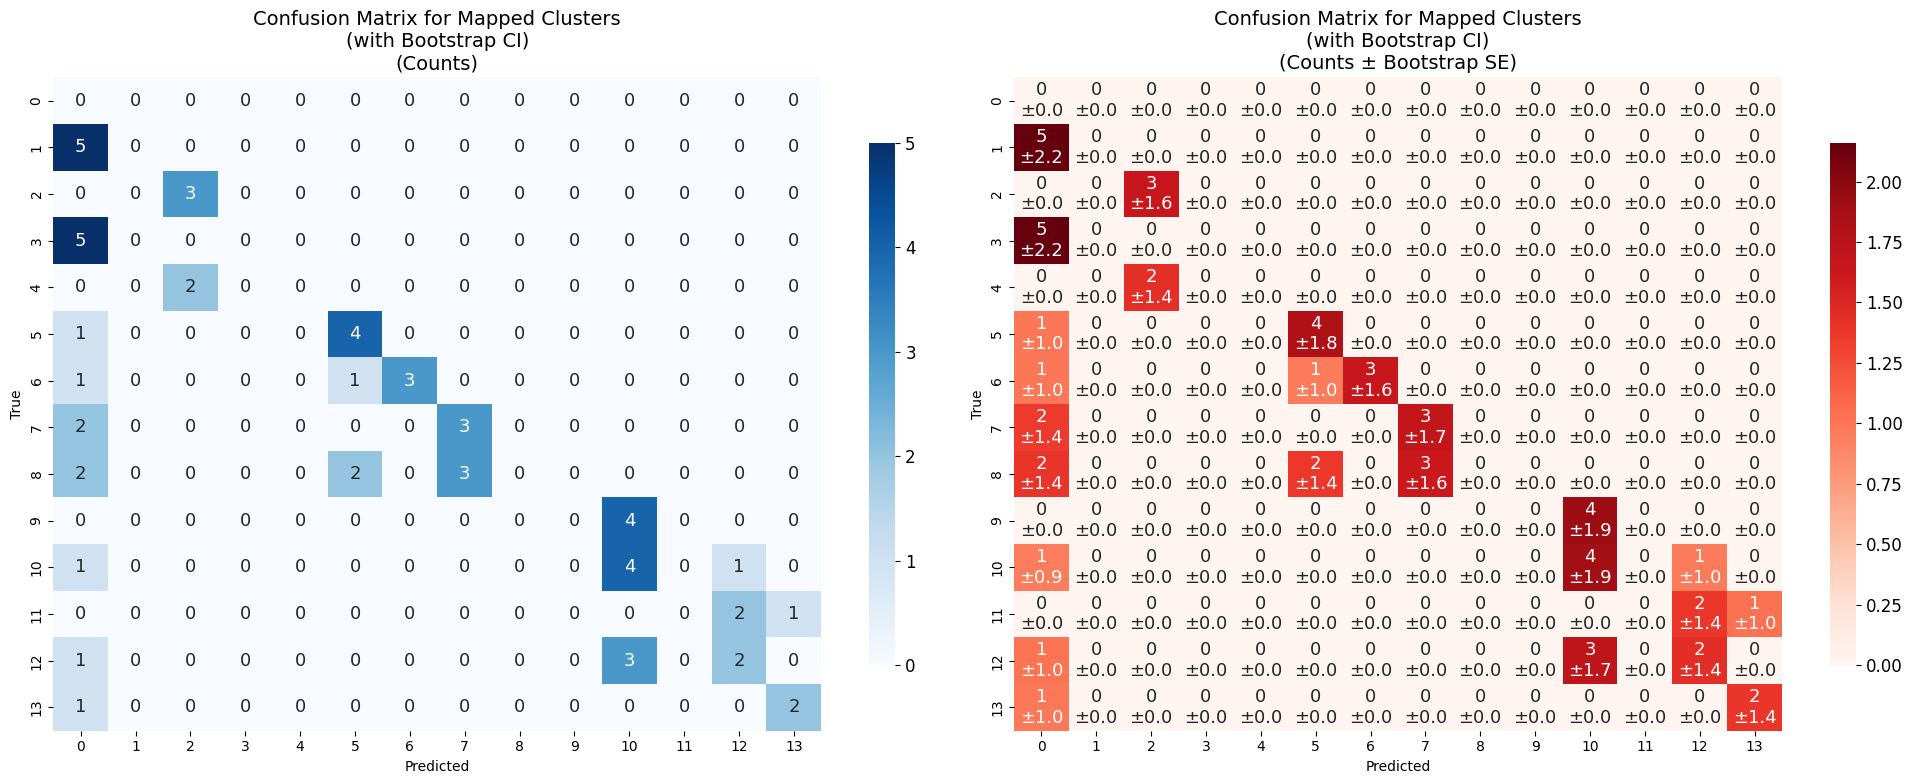


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\gat_gnn_results

Processing: ./TrainingWDE/community_results\gcn_gnn_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: gcn_gnn_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 7
Singleton Oranı: 35.00%
Ortalama Küme Boyutu: 2.95
Ortalama Küme Saflığı: 79.61%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.2002
Normalized Mutual Information: 0.6722

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2542 (95% CI: [0.1525, 0.4492])
F1-Score (Orijinal): 0.2115 (95% CI: [0.1122, 0.4099])
F1-Score (Adjusted): 0.2115 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (35.0%)!


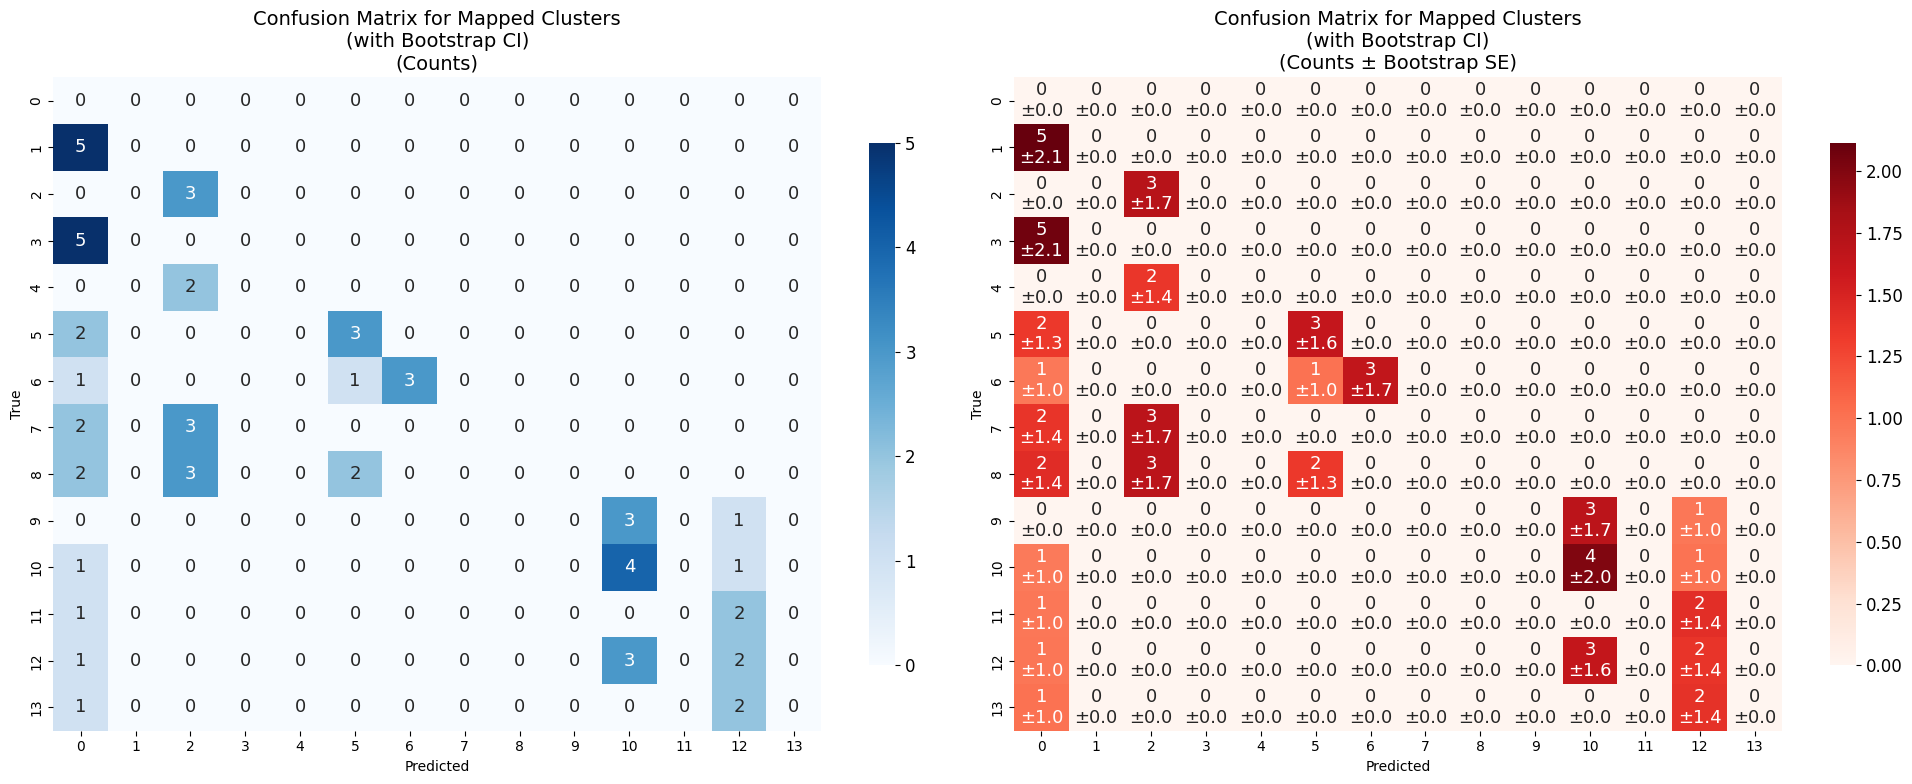


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\gcn_gnn_results

Processing: ./TrainingWDE/community_results\infomap_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: infomap_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 1
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.08
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 59.00
Ortalama Küme Saflığı: 12.07%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.0000

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1207 (95% CI: [0.0517, 0.3233])
F1-Score (Orijinal): 0.0260 (95% CI: [0.0051, 0.1063])
F1-Score (Adjusted): 0.0260 ⚠️


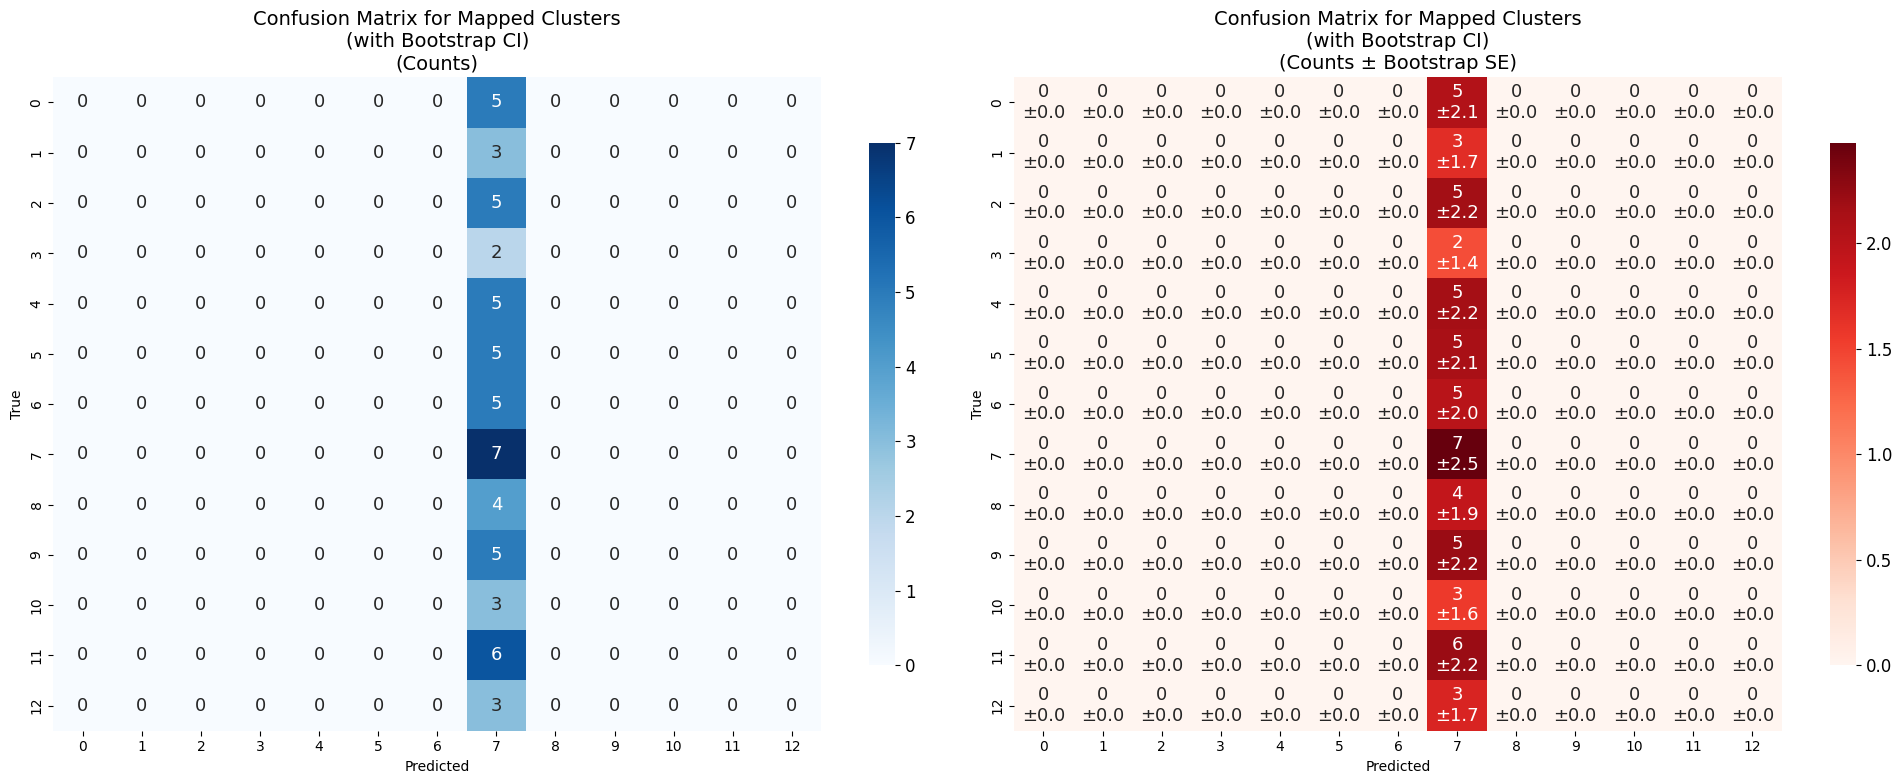


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\infomap_results

Processing: ./TrainingWDE/community_results\label_propagation_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: label_propagation_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 59
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 4.54
Singleton (Tek Elemanlı) Küme Sayısı: 59
Singleton Oranı: 100.00%
Ortalama Küme Boyutu: 1.00
Ortalama Küme Saflığı: 100.00%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.0000
Normalized Mutual Information: 0.7655

--- Mapped Evaluation (with CI) ---
Accuracy: 0.0000 (95% CI: [0.0000, 0.0000])
F1-Score (Orijinal): 0.0000 (95% CI: [0.0000, 0.0000])
F1-Score (Adjusted): 0.0000 ⚠️

⚠️  UYARI: Singleton küme oranı çok yüksek (100.0%)!
⚠️  UYARI: Küme sayısı kat sayısının 4.5x fazla!
⚠️  UYARI: Ortalama küme boyutu çok küçük (1.0)!


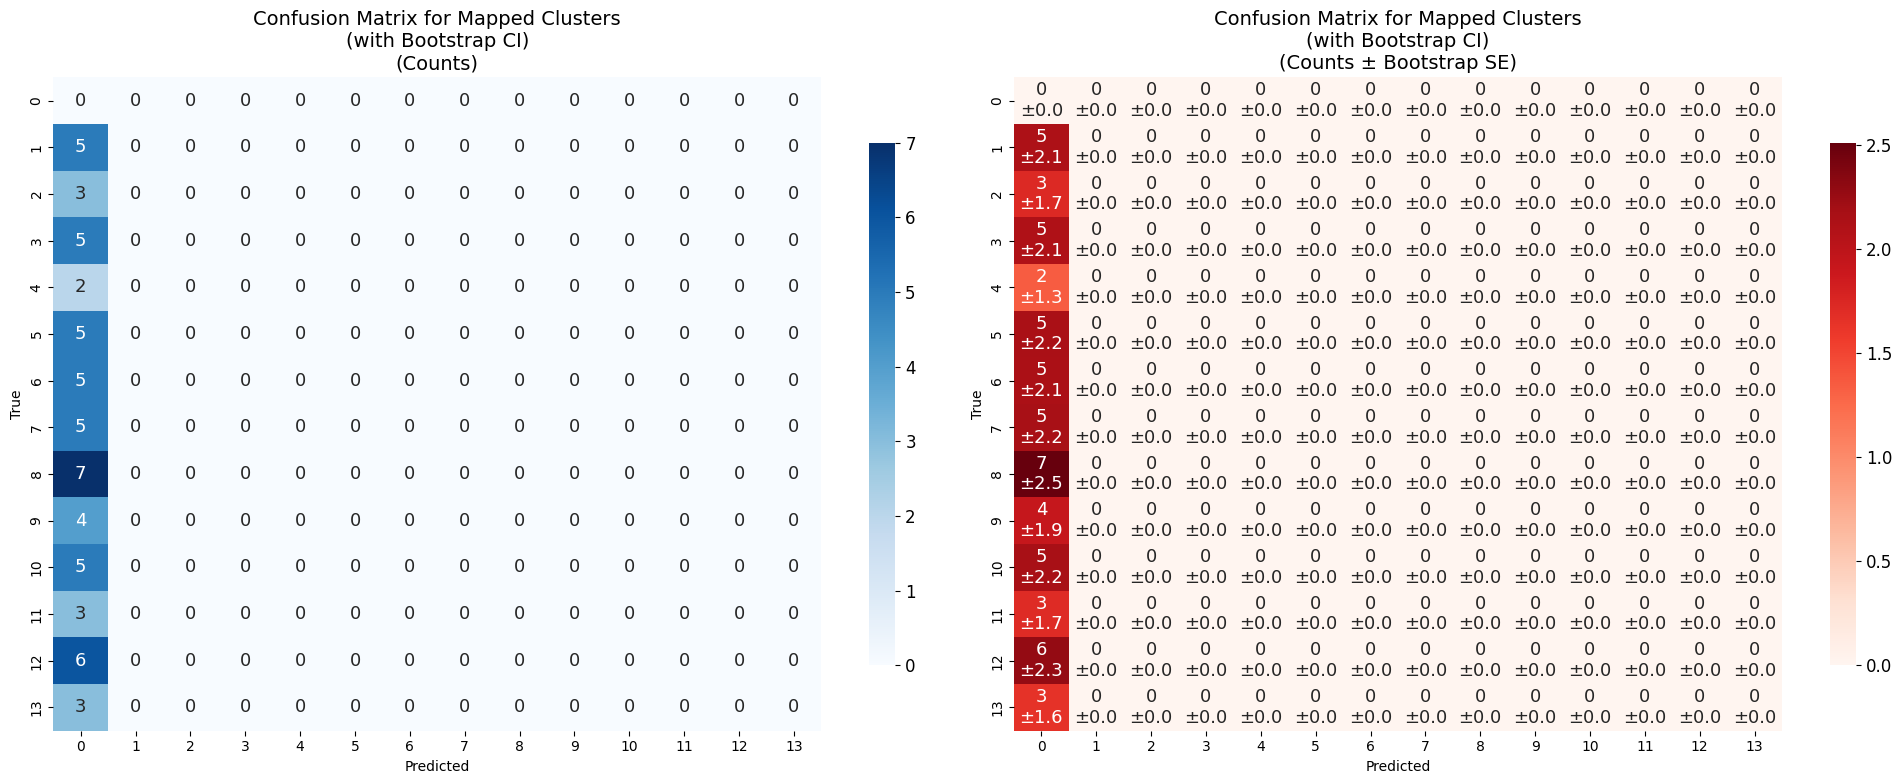


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\label_propagation_results

Processing: ./TrainingWDE/community_results\leiden_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: leiden_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 5
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.38
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 11.80
Ortalama Küme Saflığı: 23.45%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0028
Normalized Mutual Information: 0.2426

--- Mapped Evaluation (with CI) ---
Accuracy: 0.2241 (95% CI: [0.1207, 0.4095])
F1-Score (Orijinal): 0.1223 (95% CI: [0.0559, 0.2616])
F1-Score (Adjusted): 0.1223 ⚠️


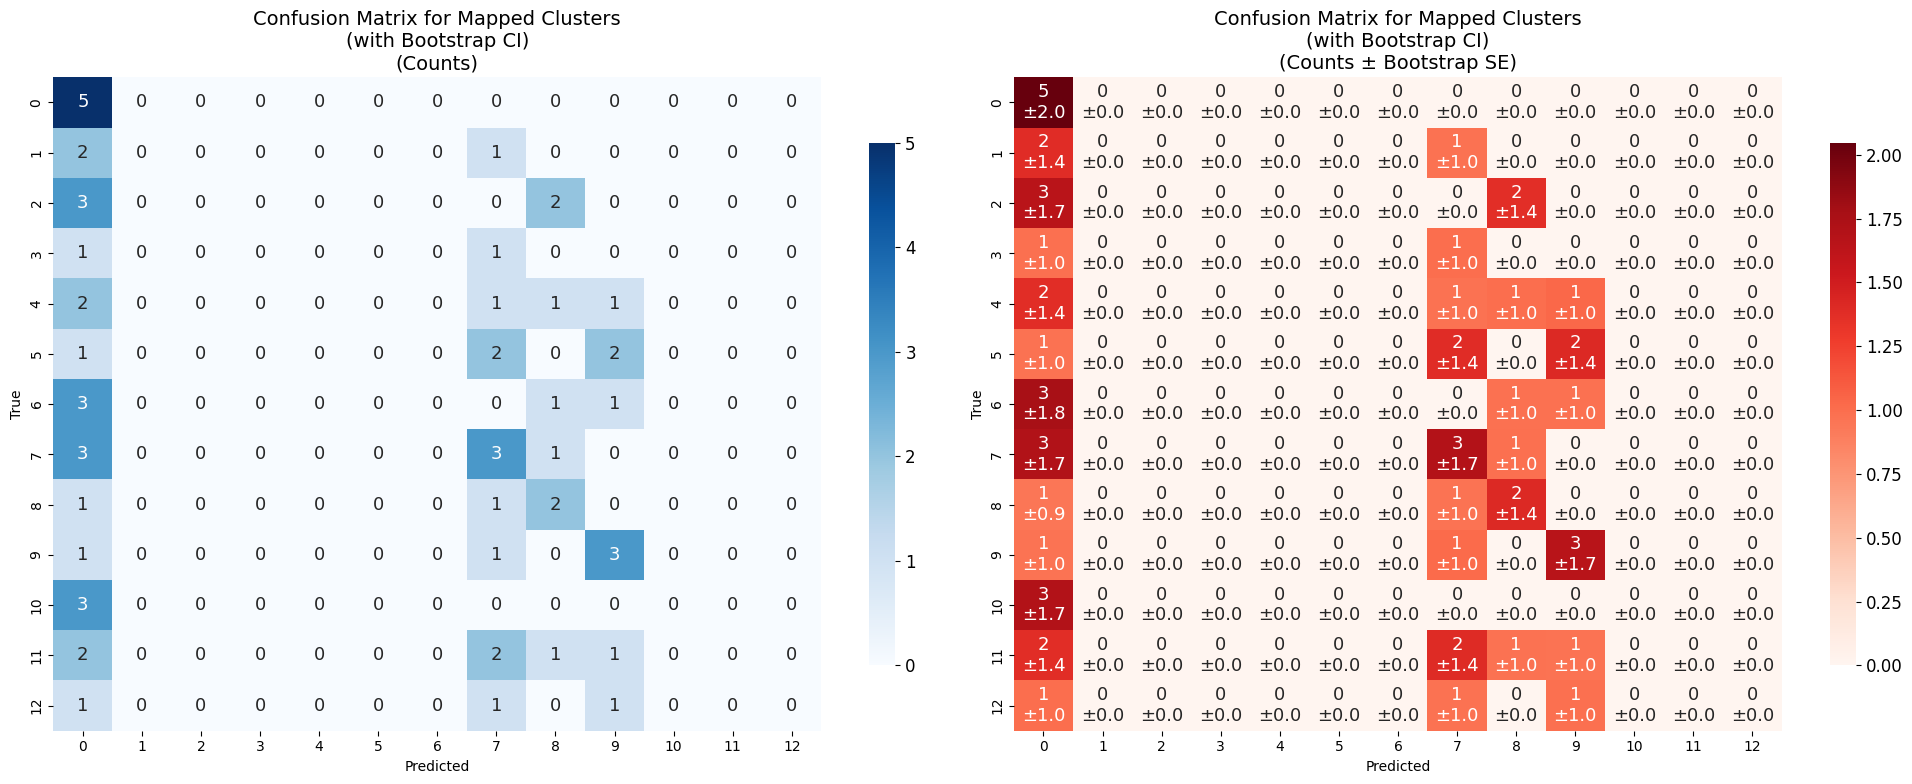


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\leiden_results

Processing: ./TrainingWDE/community_results\louvain_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: louvain_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 4
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 0.31
Singleton (Tek Elemanlı) Küme Sayısı: 0
Singleton Oranı: 0.00%
Ortalama Küme Boyutu: 14.75
Ortalama Küme Saflığı: 17.44%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: -0.0116
Normalized Mutual Information: 0.1900

--- Mapped Evaluation (with CI) ---
Accuracy: 0.1724 (95% CI: [0.0862, 0.3578])
F1-Score (Orijinal): 0.0818 (95% CI: [0.0294, 0.2170])
F1-Score (Adjusted): 0.0818 ⚠️


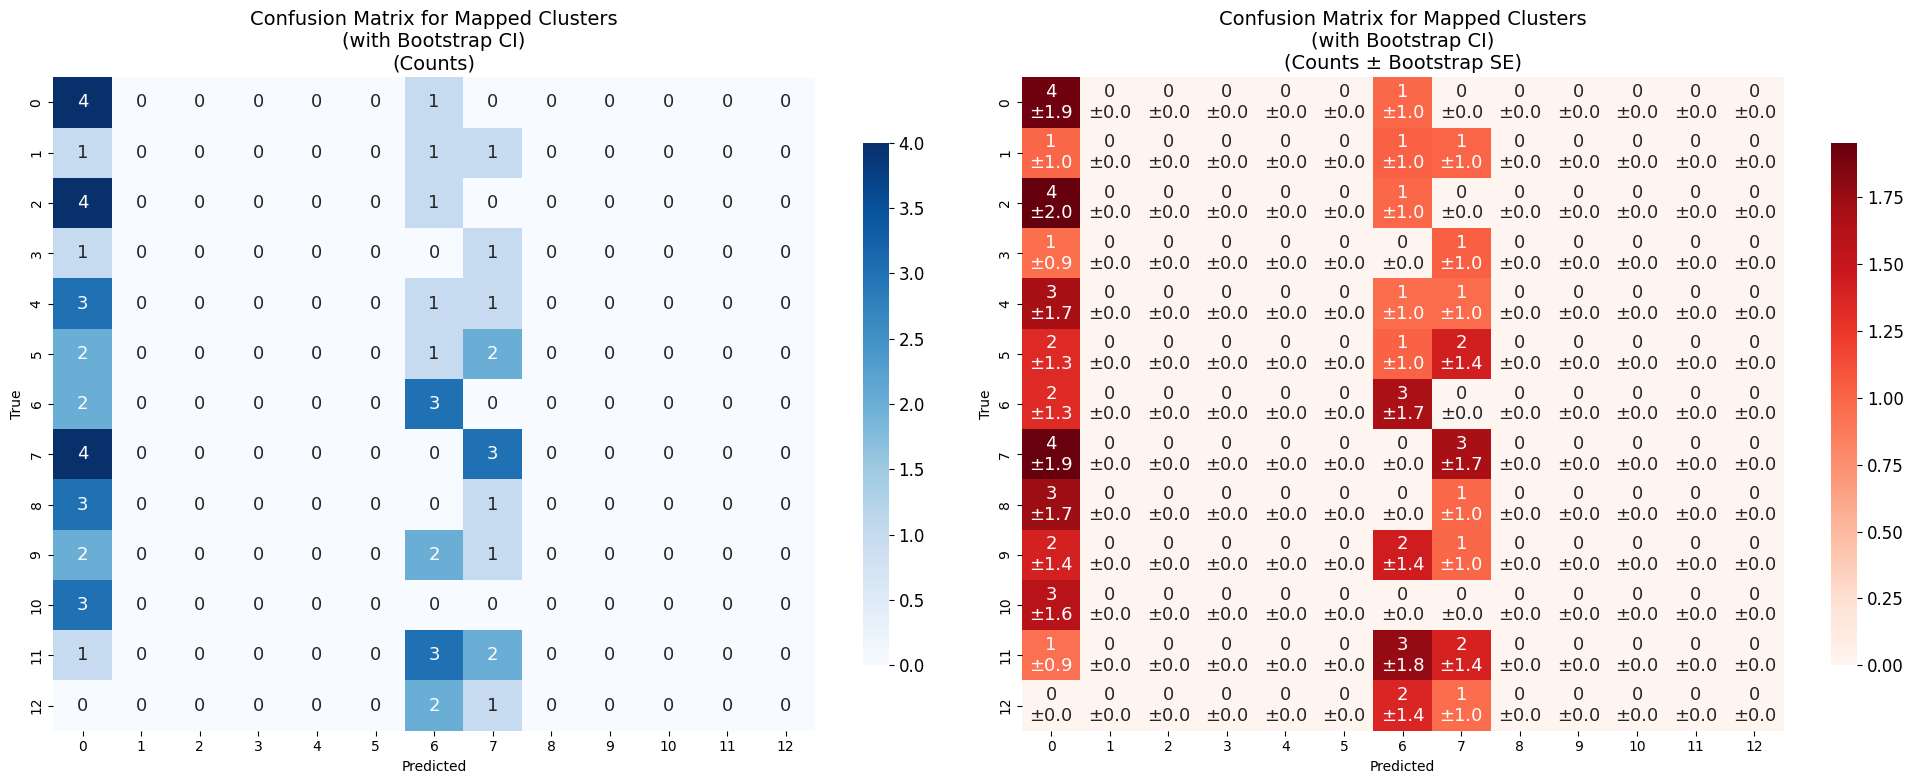


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\louvain_results

Processing: ./TrainingWDE/community_results\Node2Vec_communities.csv
Calculating metrics with Bootstrap CI...

ALGORITMA: Node2Vec_results

--- Kümeleme İstatistikleri ---
Toplam AP Sayısı: 59
Küme Sayısı: 20
Gerçek Kat Sayısı: 13
Küme/Kat Oranı: 1.54
Singleton (Tek Elemanlı) Küme Sayısı: 6
Singleton Oranı: 30.00%
Ortalama Küme Boyutu: 2.95
Ortalama Küme Saflığı: 89.88%

--- Raw Cluster Evaluation ---
Adjusted Rand Index: 0.4756
Normalized Mutual Information: 0.8003

--- Mapped Evaluation (with CI) ---
Accuracy: 0.6610 (95% CI: [0.5424, 0.8263])
F1-Score (Orijinal): 0.6892 (95% CI: [0.5604, 0.8846])
F1-Score (Adjusted): 0.6892 ⚠️


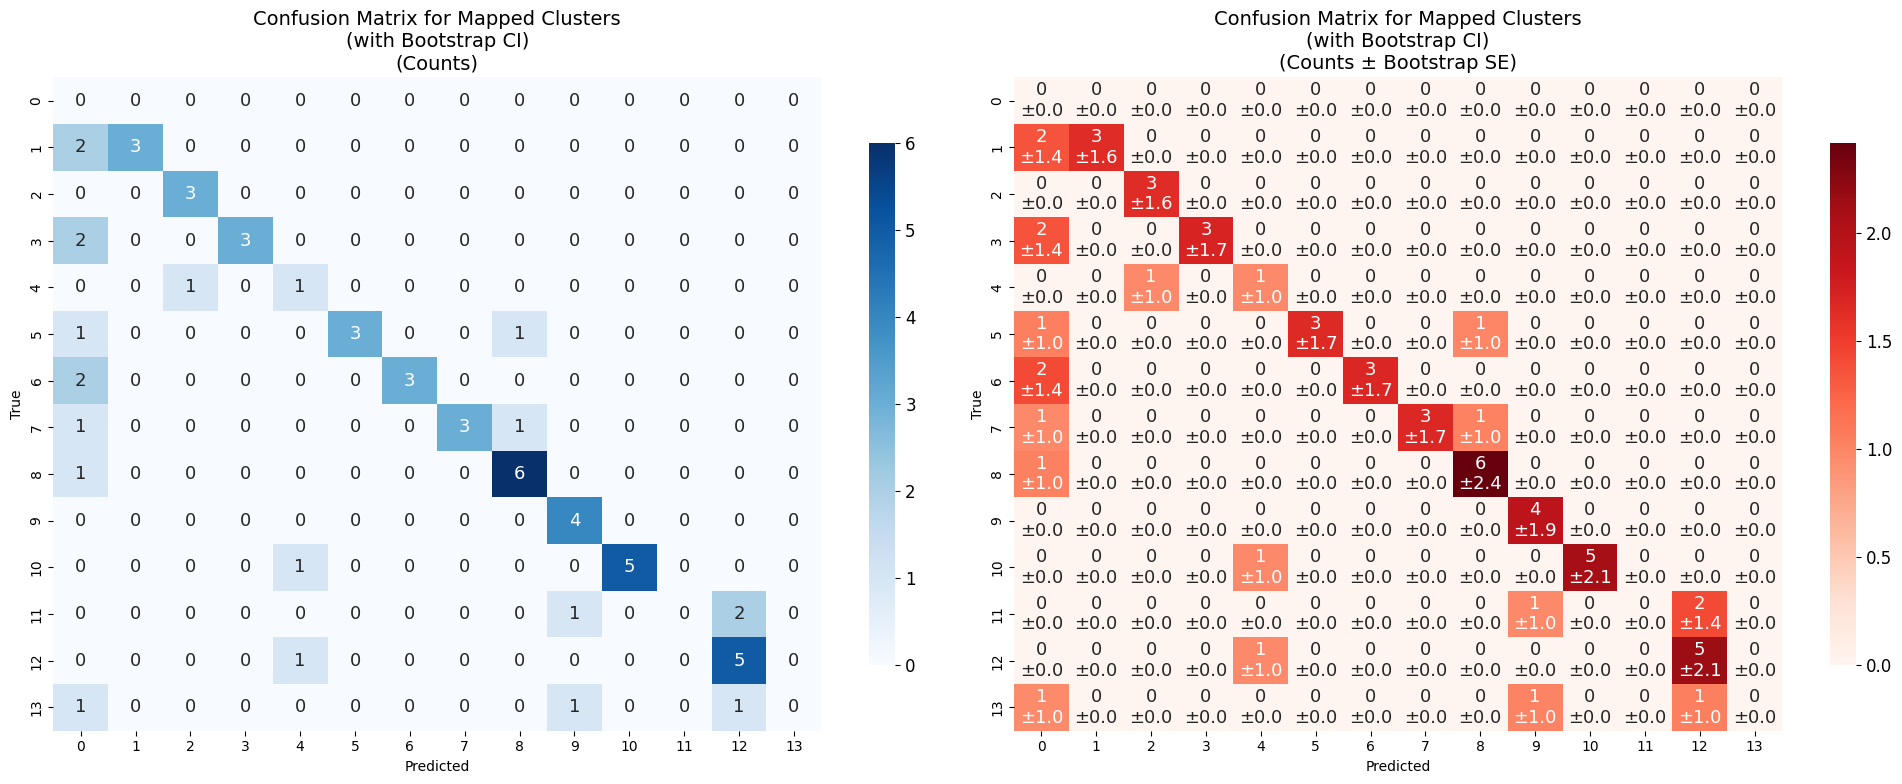


Tüm sonuçlar kaydedildi: ./TrainingWDE\results\Node2Vec_results

Tüm Sonuçlar Tablosu:


Algorithm   raw_ari   raw_nmi  raw_homogeneity  \
0           Node2Vec_results  0.234756  0.600451         0.647185   
1   edge_betweenness_results  0.034017  0.390443         0.328303   
2        fast_greedy_results -0.003191  0.019544         0.012622   
3            gat_gnn_results  0.168978  0.388000         0.319396   
4            gcn_gnn_results  0.153678  0.507124         0.554140   
5            infomap_results  0.000000  0.000000         0.000000   
6  label_propagation_results  0.000000  0.000000         0.000000   
7             leiden_results -0.004735  0.042891         0.028345   
8            louvain_results -0.002886  0.030973         0.019963   

   raw_completeness  raw_v_measure  mapped_ari  mapped_nmi  \
0          0.560012       0.600451    0.357782    0.613529   
1          0.481597       0.390443    0.019513    0.044353   
2          0.043288       0.019544   -0.003191    0.019544   
3          0.494138       0.388000    0.199069    0.365134   
4          0.467463       0.507124    0.267053    0.482875   
5          1.000000       0.000000    0.000000    0.000000   
6          1.000000       0.000000    0.000000    0.000000   
7          0.088106       0.042891   -0.004735    0.042891   
8          0.069069       0.030973   -0.002886    0.030973   

   mapped_homogeneity  mapped_completeness  ...  mapped_accuracy_ci_upper  \
0            0.568457             0.666364  ...                  0.735776   
1            0.027772             0.110071  ...                  0.274594   
2            0.012622             0.043288  ...                  0.336066   
3            0.262186             0.601192  ...                  0.455285   
4            0.445132             0.527611  ...                  0.626024   
5            0.000000             1.000000  ...                  0.278689   
6            0.000000             1.000000  ...                  0.293035   
7            0.028345             0.088106  ...                  0.315578   
8            0.019963             0.069069  ...                  0.307381   

   mapped_precision_mean  mapped_precision_ci_lower  \
0               0.651746                   0.565232   
1               0.043162                   0.016786   
2               0.068444                   0.035259   
3               0.141012                   0.083296   
4               0.423523                   0.325807   
5               0.033835                   0.013169   
6               0.033269                   0.013169   
7               0.066796                   0.033407   
8               0.065870                   0.032627   

   mapped_precision_ci_upper  mapped_recall_mean  mapped_recall_ci_lower  \
0                   0.769251            0.591244                0.495935   
1                   0.098773            0.162738                0.098361   
2                   0.142050            0.204631                0.139344   
3                   0.252382            0.331358                0.251829   
4                   0.613660            0.462390                0.373984   
5                   0.081145            0.180066                0.114754   
6                   0.085882            0.182336                0.114754   
7                   0.146756            0.198148                0.131148   
8                   0.135906            0.196672                0.131148   

   mapped_recall_ci_upper  mapped_f1_mean  mapped_f1_ci_lower  \
0                0.737807        0.572271            0.480015   
1                0.268445        0.068142            0.028368   
2                0.334018        0.102454            0.054719   
3                0.463415        0.195726            0.127571   
4                0.599596        0.425554            0.332129   
5                0.299184        0.055220            0.020522   
6                0.278689        0.056571            0.023626   
7                0.295082        0.097968            0.053517   
8                0.303279        0.0981


Tüm Sonuçlar Tablosu:


Algorithm   raw_ari   raw_nmi  raw_homogeneity  \
0           Node2Vec_results  0.234756  0.600451         0.647185   
1   edge_betweenness_results  0.034017  0.390443         0.328303   
2        fast_greedy_results -0.003191  0.019544         0.012622   
3            gat_gnn_results  0.190142  0.508584         0.545845   
4            gcn_gnn_results  0.172645  0.497270         0.536013   
5            infomap_results  0.000000  0.000000         0.000000   
6  label_propagation_results  0.001317  0.034630         0.022288   
7             leiden_results  0.002659  0.056179         0.039125   
8            louvain_results  0.002659  0.056179         0.039125   

   raw_completeness  raw_v_measure  mapped_ari  mapped_nmi  \
0          0.560012       0.600451    0.357782    0.613529   
1          0.481597       0.390443    0.019513    0.044353   
2          0.043288       0.019544   -0.003191    0.019544   
3          0.476086       0.508584    0.299340    0.532067   
4          0.463750       0.497270    0.274593    0.471067   
5          1.000000       0.000000    0.000000    0.000000   
6          0.077605       0.034630    0.001317    0.034630   
7          0.099587       0.056179    0.002659    0.056179   
8          0.099587       0.056179    0.002659    0.056179   

   mapped_homogeneity  mapped_completeness  ...  mapped_accuracy_ci_upper  \
0            0.568457             0.666364  ...                  0.737807   
1            0.027772             0.110071  ...                  0.282791   
2            0.012622             0.043288  ...                  0.319672   
3            0.506485             0.560371  ...                  0.660575   
4            0.429716             0.521224  ...                  0.601626   
5            0.000000             1.000000  ...                  0.293035   
6            0.022288             0.077605  ...                  0.350412   
7            0.039125             0.099587  ...                  0.303279   
8            0.039125             0.099587  ...                  0.311475   

   mapped_precision_mean  mapped_precision_ci_lower  \
0               0.655038                   0.570505   
1               0.042380                   0.017213   
2               0.069762                   0.036174   
3               0.502262                   0.403330   
4               0.422109                   0.323023   
5               0.033183                   0.013169   
6               0.068465                   0.036201   
7               0.077039                   0.038198   
8               0.076585                   0.039414   

   mapped_precision_ci_upper  mapped_recall_mean  mapped_recall_ci_lower  \
0                   0.772364            0.595187                0.504065   
1                   0.103352            0.163148                0.106557   
2                   0.156594            0.203811                0.131148   
3                   0.680589            0.512642                0.422764   
4                   0.597448            0.470821                0.390244   
5                   0.093342            0.178238                0.114754   
6                   0.142705            0.204844                0.131148   
7                   0.156236            0.204475                0.131148   
8                   0.155664            0.201311                0.131148   

   mapped_recall_ci_upper  mapped_f1_mean  mapped_f1_ci_lower  \
0                0.715447        0.572182            0.485846   
1                0.260248        0.067501            0.029835   
2                0.321727        0.100565            0.053364   
3                0.640246        0.477632            0.383235   
4                0.617886        0.425166            0.335405   
5                0.278689        0.056297            0.023626   
6                0.325822        0.100161            0.056594   
7                0.331971        0.110713            0.063933   
8                0.317625        0.1131


Tüm Sonuçlar Tablosu:


Algorithm   raw_ari   raw_nmi  raw_homogeneity  \
0           Node2Vec_results  0.475608  0.800332         0.847006   
1   edge_betweenness_results -0.019295  0.640173         0.730719   
2        fast_greedy_results -0.005032  0.170698         0.128775   
3            gat_gnn_results  0.284400  0.721902         0.750701   
4            gcn_gnn_results  0.220979  0.685553         0.699899   
5            infomap_results  0.000000  0.000000         0.000000   
6  label_propagation_results  0.000000  0.765491         1.000000   
7             leiden_results  0.006059  0.260562         0.212412   
8            louvain_results -0.033287  0.192820         0.157507   

   raw_completeness  raw_v_measure  mapped_ari  mapped_nmi  \
0          0.758534       0.800332    0.427959    0.732560   
1          0.569592       0.640173   -0.016568    0.037633   
2          0.253094       0.170698   -0.005032    0.170698   
3          0.695231       0.721902    0.259025    0.631093   
4          0.671783       0.685553    0.156716    0.507662   
5          1.000000       0.000000    0.000000    0.000000   
6          0.620077       0.765491    0.000000    0.000000   
7          0.336941       0.260562    0.006059    0.260562   
8          0.248542       0.192820   -0.003771    0.178416   

   mapped_homogeneity  mapped_completeness  ...  mapped_accuracy_ci_upper  \
0            0.712228             0.754087  ...                  0.898305   
1            0.023337             0.097137  ...                  0.155172   
2            0.128775             0.253094  ...                  0.435358   
3            0.558428             0.725498  ...                  0.555089   
4            0.418410             0.645314  ...                  0.466110   
5            0.000000             1.000000  ...                  0.258621   
6            0.000000             1.000000  ...                  0.000000   
7            0.212412             0.336941  ...                  0.379310   
8            0.135168             0.262361  ...                  0.353457   

   mapped_precision_mean  mapped_precision_ci_lower  \
0               0.782592                   0.657595   
1               0.024389                   0.000000   
2               0.107653                   0.038290   
3               0.334150                   0.198134   
4               0.236431                   0.117415   
5               0.015639                   0.002675   
6               0.000000                   0.000000   
7               0.122808                   0.053064   
8               0.080402                   0.022857   

   mapped_precision_ci_upper  mapped_recall_mean  mapped_recall_ci_lower  \
0                   0.962173            0.657136                0.542373   
1                   0.099482            0.052362                0.000000   
2                   0.265531            0.224000                0.120690   
3                   0.546268            0.375271                0.254237   
4                   0.430295            0.288119                0.186441   
5                   0.073798            0.120397                0.034483   
6                   0.000000            0.000000                0.000000   
7                   0.280018            0.221983                0.120690   
8                   0.246228            0.171362                0.086207   

   mapped_recall_ci_upper  mapped_f1_mean  mapped_f1_ci_lower  \
0                0.826275        0.688135            0.569205   
1                0.181043        0.032205            0.000000   
2                0.448276        0.134542            0.062178   
3                0.601703        0.325992            0.200698   
4                0.504242        0.236182            0.128359   
5                0.241379        0.028604            0.002299   
6                0.000000        0.000000            0.000000   
7                0.422422        0.150657            0.071837   
8                0.357763        0.0993


Tüm Sonuçlar Tablosu:


Algorithm   raw_ari   raw_nmi  raw_homogeneity  \
0           Node2Vec_results  0.475608  0.800332         0.847006   
1   edge_betweenness_results -0.019295  0.640173         0.730719   
2        fast_greedy_results -0.005032  0.170698         0.128775   
3            gat_gnn_results  0.283985  0.726675         0.760509   
4            gcn_gnn_results  0.200186  0.672182         0.687011   
5            infomap_results  0.000000  0.000000         0.000000   
6  label_propagation_results  0.000000  0.765491         1.000000   
7             leiden_results -0.002814  0.242636         0.197091   
8            louvain_results -0.011635  0.190049         0.147276   

   raw_completeness  raw_v_measure  mapped_ari  mapped_nmi  \
0          0.758534       0.800332    0.427959    0.732560   
1          0.569592       0.640173   -0.016568    0.037633   
2          0.253094       0.170698   -0.005032    0.170698   
3          0.695723       0.726675    0.220486    0.600412   
4          0.657980       0.672182    0.144499    0.491348   
5          1.000000       0.000000    0.000000    0.000000   
6          0.620077       0.765491    0.000000    0.000000   
7          0.315555       0.242636    0.002732    0.200362   
8          0.267836       0.190049    0.003488    0.157104   

   mapped_homogeneity  mapped_completeness  ...  mapped_accuracy_ci_upper  \
0            0.712228             0.754087  ...                  0.826275   
1            0.023337             0.097137  ...                  0.176737   
2            0.128775             0.253094  ...                  0.379310   
3            0.525153             0.700849  ...                  0.542373   
4            0.405523             0.623255  ...                  0.449161   
5            0.000000             1.000000  ...                  0.323297   
6            0.000000             1.000000  ...                  0.000000   
7            0.149883             0.302110  ...                  0.409487   
8            0.110560             0.271327  ...                  0.357763   

   mapped_precision_mean  mapped_precision_ci_lower  \
0               0.779977                   0.660587   
1               0.023801                   0.000000   
2               0.106711                   0.038477   
3               0.342078                   0.202821   
4               0.221499                   0.106658   
5               0.016342                   0.002675   
6               0.000000                   0.000000   
7               0.102716                   0.038646   
8               0.063132                   0.018139   

   mapped_precision_ci_upper  mapped_recall_mean  mapped_recall_ci_lower  \
0                   0.943508            0.661712                0.542373   
1                   0.126102            0.053052                0.000000   
2                   0.267206            0.219690                0.120690   
3                   0.600968            0.355017                0.237288   
4                   0.487821            0.254542                0.152542   
5                   0.064732            0.121466                0.051724   
6                   0.000000            0.000000                0.000000   
7                   0.254465            0.223328                0.120690   
8                   0.211503            0.172828                0.086207   

   mapped_recall_ci_upper  mapped_f1_mean  mapped_f1_ci_lower  \
0                0.847458        0.685508            0.560435   
1                0.168108        0.032472            0.000000   
2                0.396552        0.135025            0.057020   
3                0.593237        0.324736            0.198403   
4                0.478826        0.215776            0.112242   
5                0.275862        0.029151            0.005088   
6                0.000000        0.000000            0.000000   
7                0.409487        0.131431            0.055918   
8                0.353457        0.0867

In [34]:
# Main Execution
paths = [args.path]

# Load baseline if provided
baseline_ap_to_cluster = None
baseline_clusters = None
if args.baseline_file:
    print(f"Loading baseline from: {args.baseline_file}")
    try:
        baseline_ap_to_cluster, baseline_clusters = load_clustering_result(args.baseline_file)
    except Exception as e:
        print(f"Error loading baseline file: {e}")
paths=folders= ["./ValidationGeo", "./ValidationWDE", "./TrainingGeo", "./TrainingWDE"]
# Iterate paths
for p in paths:
    path = f"{p}/community_results"
    if not os.path.exists(path):
        print(f"Directory not found: {path}")
        continue
        
    files_add = find_the_way(path, '_communities.csv')
    print(f"Found {len(files_add)} result files.")

    for file in files_add:
        print(f"\nProcessing: {file}")
        # 1. Setup file paths
        gt_file = os.path.join(p, 'data_GT.json')
        result_file = file
        
        if not os.path.exists(gt_file):
            print(f"Ground truth file not found: {gt_file}")
            continue
        
        folder_name = os.path.basename(file).replace('_communities.csv', '') + '_results'
        
        output_dir = os.path.join(p, 'results', folder_name)
        os.makedirs(output_dir, exist_ok=True)
        
        # 2. Load data
        ap_to_floor = load_ground_truth(gt_file)
        ap_to_cluster, clusters = load_clustering_result(result_file)
        cluster_to_floor = map_clusters_to_floors(ap_to_floor, ap_to_cluster, clusters)
        common_aps, y_true, y_pred_raw, y_pred_mapped = create_true_pred_arrays(
            ap_to_floor, ap_to_cluster, cluster_to_floor
        )
        
        # 3. Evaluate clustering
        raw_results = evaluate_clustering(y_true, y_pred_raw, prefix="raw_")
        mapped_results = evaluate_clustering(y_true, y_pred_mapped, prefix="mapped_")
        
        # 3.5 Calculate Metrics with CI
        print("Calculating metrics with Bootstrap CI...")
        metrics_with_ci = calculate_metrics_with_ci(
            y_true, y_pred_mapped, 
            n_bootstrap=args.n_bootstrap, 
            confidence_level=args.confidence_level
        )
        
        # 4. *** YENI: Küme kalite metrikleri ***
        quality_metrics = calculate_cluster_quality_metrics(clusters, ap_to_floor)
        
        # 5. *** YENI: Adjusted score hesapla ***
        adjusted_f1 = calculate_adjusted_score(
            mapped_results['mapped_f1'],
            quality_metrics['singleton_ratio'],
            quality_metrics['cluster_floor_ratio']
        )
        
        # Statistical Comparison with Baseline
        statistical_results = {}
        if baseline_ap_to_cluster:
            print("Performing statistical comparison with baseline...")
            baseline_cluster_to_floor = map_clusters_to_floors(ap_to_floor, baseline_ap_to_cluster, baseline_clusters)
            _, _, _, y_pred_baseline = create_true_pred_arrays(
                ap_to_floor, baseline_ap_to_cluster, baseline_cluster_to_floor
            )
            
            common_all = sorted(set(ap_to_floor.keys()) & set(ap_to_cluster.keys()) & set(baseline_ap_to_cluster.keys()))
            y_true_common = np.array([ap_to_floor[ap] for ap in common_all])
            y_pred_mapped_common = np.array([cluster_to_floor[ap_to_cluster[ap]] for ap in common_all])
            y_pred_baseline_common = np.array([baseline_cluster_to_floor[baseline_ap_to_cluster[ap]] for ap in common_all])
            
            sig_test_mcnemar = statistical_significance_test(y_true_common, y_pred_mapped_common, y_pred_baseline_common, 'mcnemar')
            sig_test_ttest = statistical_significance_test(y_true_common, y_pred_mapped_common, y_pred_baseline_common, 'paired_t')
            sig_test_wilcoxon = statistical_significance_test(y_true_common, y_pred_mapped_common, y_pred_baseline_common, 'wilcoxon')
            
            statistical_results = {
                'baseline_comparison': {
                    'mcnemar': sig_test_mcnemar,
                    'paired_t': sig_test_ttest,
                    'wilcoxon': sig_test_wilcoxon
                }
            }

        # Tüm sonuçları birleştir
        all_results = {
            **raw_results,
            **mapped_results,
            **quality_metrics,
            'adjusted_f1_score': adjusted_f1,
            'metrics_ci': metrics_with_ci,
            **statistical_results
        }
        
        # 6. Print Results
        print(f"\n{'='*60}")
        print(f"ALGORITMA: {folder_name}")
        print(f"{'='*60}")
        
        print("\n--- Kümeleme İstatistikleri ---")
        print(f"Toplam AP Sayısı: {quality_metrics['total_aps']}")
        print(f"Küme Sayısı: {quality_metrics['num_clusters']}")
        print(f"Gerçek Kat Sayısı: {quality_metrics['num_unique_floors']}")
        print(f"Küme/Kat Oranı: {quality_metrics['cluster_floor_ratio']:.2f}")
        print(f"Singleton (Tek Elemanlı) Küme Sayısı: {quality_metrics['singleton_clusters']}")
        print(f"Singleton Oranı: {quality_metrics['singleton_ratio']:.2%}")
        print(f"Ortalama Küme Boyutu: {quality_metrics['avg_cluster_size']:.2f}")
        print(f"Ortalama Küme Saflığı: {quality_metrics['avg_cluster_purity']:.2%}")
        
        print("\n--- Raw Cluster Evaluation ---")
        print(f"Adjusted Rand Index: {raw_results['raw_ari']:.4f}")
        print(f"Normalized Mutual Information: {raw_results['raw_nmi']:.4f}")
        
        print("\n--- Mapped Evaluation (with CI) ---")
        print(f"Accuracy: {mapped_results['mapped_accuracy']:.4f} (95% CI: [{metrics_with_ci['mapped_accuracy']['ci_lower']:.4f}, {metrics_with_ci['mapped_accuracy']['ci_upper']:.4f}])")
        print(f"F1-Score (Orijinal): {mapped_results['mapped_f1']:.4f} (95% CI: [{metrics_with_ci['mapped_f1']['ci_lower']:.4f}, {metrics_with_ci['mapped_f1']['ci_upper']:.4f}])")
        print(f"F1-Score (Adjusted): {adjusted_f1:.4f} ⚠️")
        
        if statistical_results:
            print("\n--- Statistical Significance vs Baseline ---")
            print(f"McNemar p-value: {statistical_results['baseline_comparison']['mcnemar']['p_value']:.6f}")
            print(f"Paired t-test p-value: {statistical_results['baseline_comparison']['paired_t']['p_value']:.6f}")
            print(f"Wilcoxon p-value: {statistical_results['baseline_comparison']['wilcoxon']['p_value']:.6f}")

        # *** YENI: UYARI SİSTEMİ ***
        warnings_list = []
        if quality_metrics['singleton_ratio'] > 0.3:
            warnings_list.append(f"⚠️  UYARI: Singleton küme oranı çok yüksek ({quality_metrics['singleton_ratio']:.1%})!")
        if quality_metrics['cluster_floor_ratio'] > 3:
            warnings_list.append(f"⚠️  UYARI: Küme sayısı kat sayısının {quality_metrics['cluster_floor_ratio']:.1f}x fazla!")
        if quality_metrics['avg_cluster_size'] < 2:
            warnings_list.append(f"⚠️  UYARI: Ortalama küme boyutu çok küçük ({quality_metrics['avg_cluster_size']:.1f})!")
        
        if warnings_list:
            print("\n" + "="*60)
            for warning in warnings_list:
                print(warning)
            print("="*60)
        
        # 7. Save results
        with open(os.path.join(output_dir, 'performance_metrics.json'), 'w', encoding='utf-8') as f:
            json.dump(all_results, f, ensure_ascii=False, indent=4)
        
        # 8. Generate plots
        generate_confusion_matrix_with_ci(
            y_true, y_pred_mapped,
            os.path.join(output_dir, 'confusion_matrix_mapped_ci.pdf'),
            'Confusion Matrix for Mapped Clusters\n(with Bootstrap CI)',
            n_bootstrap=args.n_bootstrap
        )
        
        cluster_analysis = analyze_clusters(clusters, ap_to_floor, output_dir)
        
        print(f"\nTüm sonuçlar kaydedildi: {output_dir}")

# Compile table
for p in paths:
    search_path = f"{p}/results"
    df_results = compile_metrics_to_table(search_path)
    
    if df_results is not None:
        print("\nTüm Sonuçlar Tablosu:")
        display(df_results)
        df_results.to_excel(os.path.join(p, "sonuc.xlsx"), index=False)